In [2]:
"""
Emerging Knowledge Discovery on Twitter: A Hybrid Framework
Complete Analysis Pipeline
"""

# Step 0: Install required packages
# pip install bertopic umap-learn hdbscan plotly matplotlib pandas numpy scipy scikit-learn openai transformers sentencepiece torch

import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModel
import openai
from datetime import datetime, timedelta
import plotly.express as px
import matplotlib.pyplot as plt
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import string
import warnings
import nltk
warnings.simplefilter(action='ignore',category=FutureWarning)
from nltk.corpus import stopwords
# Download stopwords if it's your first time
nltk.download('stopwords')
# Define stop words set
stop_words = set(stopwords.words('english'))

from nltk.stem import PorterStemmer #to stem words
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import numpy as np
import glob
import json
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
import random
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from operator import itemgetter
import gensim
from gensim.utils import simple_preprocess
import pprint 
from sklearn.decomposition import NMF
from gensim.models.nmf import Nmf
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
nltk.download('words')
words = set(nltk.corpus.words.words())
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer
import torch
from transformers import TFAutoModelForSequenceClassification
from nltk.util import ngrams
from wordcloud import WordCloud
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import openai # for generate themes and others
from openai import OpenAI
from collections import defaultdict
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import ollama

[nltk_data] Downloading package stopwords to /Users/Adam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/Adam/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
# Step 1: Data Loading and Overview
#def load_data(file_path):
    #"""Load and overview the Twitter dataset"""
    #print("Step 1: Loading data...")

In [80]:
df = pd.read_csv('/Users/Adam/Downloads/Tweets/tweets_theme.csv')

In [82]:
df.head(1)

,date,place,text,sentiment,topic,topic_words,topic_name,topic_keywords,theme_broad,theme_specific,theme_full,theme
0,2020-01-22,Jamaica,talking about the jamaica look out for this w...,neutral,1,"nigeria, africa, lagos, nigerians, south afric...",1_nigeria_africa_lagos_nigerians,"nigeria, africa, lagos, nigerians, south africa",Other,Nigeria & Africa & Lagos,Other: Nigeria & Africa & Lagos,Vaccination Rollout & Hesitancy


In [84]:
df.shape

(595929, 12)

In [ ]:
# Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Basic overview
    print(f"Dataset shape: {df.shape}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Sample of the data
    print("\nSample of data:")
    print(df.head())
    

In [10]:
import emoji

In [12]:
####### labelling text using BERTweet####
# ✅ Check MPS for Apple Silicon

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🚀 Using Apple MPS backend (Metal GPU)")
else:
    device = torch.device("cpu")
    print("⚠️ MPS not available. Using CPU.")

# ✅ Load a public emotion classification model (GoEmotions)
MODEL_NAME = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device)
model.eval()

# ✅ Emotion labels
emotion_labels = model.config.id2label  # dict like {0:'anger', 1:'disgust', ...}

# ✅ Preprocess
def preprocess_tweet(text):
    return emoji.demojize(str(text)).strip()

# ✅ Function to label DataFrame with progress bar
def label_emotions_dataframe(df, text_column='text', batch_size=32):
    texts = df[text_column].tolist()
    all_labels = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Labelling tweets"):
        batch_texts = [preprocess_tweet(t) for t in texts[i:i+batch_size]]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

        batch_labels = [emotion_labels[p] for p in predictions]
        all_labels.extend(batch_labels)

    df['emotion'] = all_labels
    return df
    

🚀 Using Apple MPS backend (Metal GPU)


In [4]:
  # ✅ Run labelling   
#df = label_emotions_dataframe(df, text_column='text', batch_size=16)

In [10]:
df.rename(columns={'emotion': 'sentiment'}, inplace=True)

In [12]:
df.rename(columns={'theme_label': 'theme'}, inplace=True)

In [23]:
# Download stopwords if not already
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

[nltk_data] Downloading package stopwords to /Users/Adam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


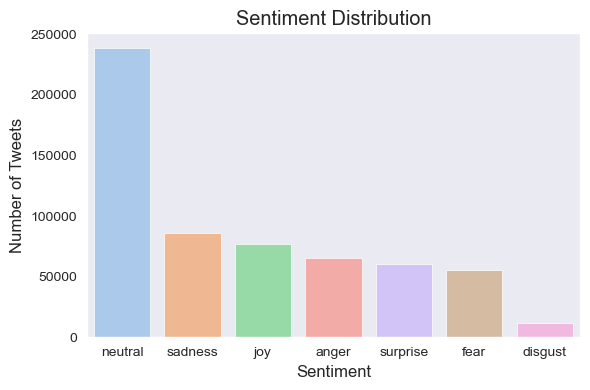

In [27]:
# =========================
# 1. Sentiment Distribution
# =========================
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="pastel")
plt.title("Sentiment Distribution")
plt.ylabel("Number of Tweets")
plt.xlabel("Sentiment")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

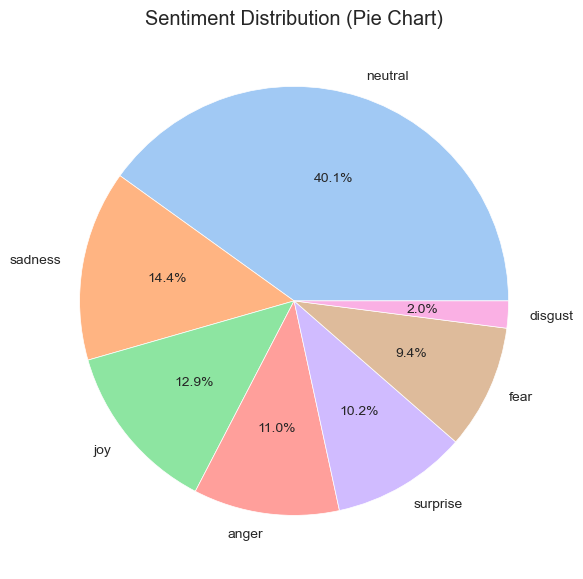

In [248]:
# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Sentiment Distribution (Pie Chart)")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

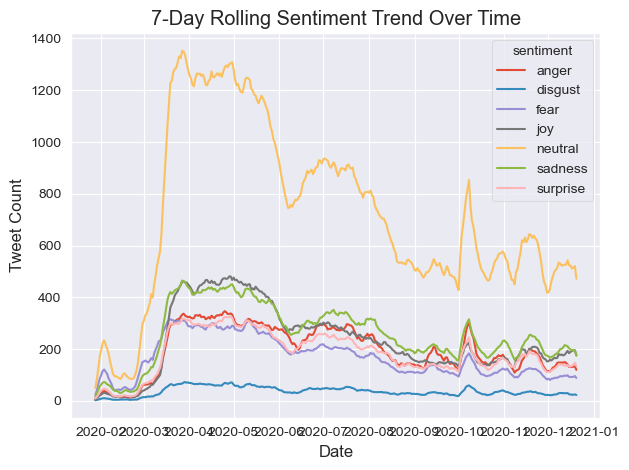

In [252]:
# ==============================
# 2. Time-based Sentiment Trends
# ==============================
df['date_only'] = df['date'].dt.date
daily_sentiment = df.groupby(['date_only', 'sentiment']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
daily_sentiment.rolling(7).mean().plot()
plt.title("7-Day Rolling Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [256]:
 # ===============================
# 3. Common Words per Sentiment
# ===============================

def get_top_n_words(text_series, n=10):
    # Drop any NaNs and ensure all entries are strings
    text_series = text_series.dropna().astype(str)
    words = ' '.join(text_series).split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return Counter(words).most_common(n)

# Top 10 words per sentiment
for emotion in ['neutral', 'sadness', 'joy', 'anger', 'surprise', 'fear', 'disgust']:
    top_words = get_top_n_words(df[df['sentiment'] == emotion]['text'], n=10)
    print(f"\nTop words in {sentiment} tweets:")
    for word, count in top_words:
        print(f"  {word}: {count}")
        


Top words in surprise tweets:
  cases: 16426
  people: 14925
  amp: 14659
  new: 12970
  get: 11721
  please: 9585
  like: 9196
  one: 9183
  need: 8933
  dont: 8604

Top words in surprise tweets:
  amp: 8659
  people: 8125
  due: 5395
  cases: 5238
  deaths: 5035
  get: 4900
  new: 4285
  one: 4262
  dont: 4203
  died: 4035

Top words in surprise tweets:
  amp: 9137
  thank: 6581
  great: 6441
  good: 6308
  people: 4566
  time: 3791
  day: 3707
  like: 3674
  work: 3594
  one: 3590

Top words in surprise tweets:
  people: 9351
  amp: 6022
  trump: 5870
  dont: 4540
  like: 4037
  get: 4022
  fuck: 3048
  one: 2826
  fucking: 2681
  stop: 2553

Top words in surprise tweets:
  cases: 6238
  people: 5910
  new: 5267
  amp: 3832
  like: 3593
  one: 3260
  dont: 3118
  deaths: 2850
  think: 2808
  many: 2783

Top words in surprise tweets:
  people: 6886
  amp: 6054
  cases: 3675
  health: 3586
  risk: 3232
  dont: 2992
  like: 2910
  new: 2786
  trump: 2583
  one: 2546

Top words in surp

In [258]:
# ===============================
# 4. Most Frequent Trigrams
# ===============================

def get_top_Trigrams(text_series, n=10):
    text_series = text_series.dropna().astype(str)  # Ensure text only
    all_Trigrams = []
    
    for text in text_series:
        tokens = [word for word in text.split() if word not in stop_words and len(word) > 3]
        Trigrams = list(ngrams(tokens, 3))
        all_Trigrams.extend(Trigrams)
    
    return Counter(all_Trigrams).most_common(n)

# Top bigrams per sentiment
for emotion in ['neutral', 'sadness', 'joy', 'anger', 'surprise', 'fear', 'disgust']:
    top_Trigrams = get_top_Trigrams(df[df['sentiment'] == sentiment]['text'], n=10)
    print(f"\nTop bigrams in {sentiment} tweets:")
    for Trigram, count in top_Trigrams:
        print(f"  {' '.join(Trigram)}: {count}")
        


Top bigrams in surprise tweets:
  including active cases: 165
  number confirmed cases: 115
  total number cases: 115
  rises including active: 108
  cases state rises: 89
  state rises including: 87
  total number confirmed: 78
  total positive cases: 76
  reported state today: 71
  cases deaths reported: 70

Top bigrams in surprise tweets:
  including active cases: 165
  number confirmed cases: 115
  total number cases: 115
  rises including active: 108
  cases state rises: 89
  state rises including: 87
  total number confirmed: 78
  total positive cases: 76
  reported state today: 71
  cases deaths reported: 70

Top bigrams in surprise tweets:
  including active cases: 165
  number confirmed cases: 115
  total number cases: 115
  rises including active: 108
  cases state rises: 89
  state rises including: 87
  total number confirmed: 78
  total positive cases: 76
  reported state today: 71
  cases deaths reported: 70

Top bigrams in surprise tweets:
  including active cases: 165
 

In [6]:
import os
import re
import numpy as np
import pandas as pd
import torch
from tqdm import trange
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

# -----------------------
# File and column settings
# -----------------------
INPUT_CSV   = "tweets.csv"   # 🔸 Replace with your dataset filename
TEXT_COL    = "text"         # 🔸 The column containing the cleaned tweet text

# -----------------------
# Performance settings
# -----------------------
EMB_DIM     = 384       # MiniLM embedding size
PCA_DIM     = 50        # Dimensionality after PCA
BATCH_EMB   = 4096      # Batch size for embeddings
PCA_BATCH   = 50000     # Batch size for PCA
N_CLUSTERS  = 1000      # Number of clusters for MiniBatchKMeans
SEED        = 42

# -----------------------
# Stopwords (Twitter + Domain-specific)
# -----------------------
base_stops = text.ENGLISH_STOP_WORDS.union({
    "rt","htt","https","http","co","amp","via",
    "im","ive","u","ur","dont","cant"
})

pandemic_stops = {
    "covid", "covid19", "covid-19",
    "coronavirus", "virus", "pandemic",
    "outbreak", "lockdown", "corona", "wuhan"
}

custom_stops = base_stops.union(pandemic_stops)

# -----------------------
# Device selection (MPS for M1)
# -----------------------
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

✅ Using device: mps


In [8]:
# Load only the text column to save memory

# Drop NaN and empty rows
df = df.dropna(subset=[TEXT_COL]).reset_index(drop=True)
df[TEXT_COL] = df[TEXT_COL].astype(str).str.strip()

# Optional: Remove pandemic keywords from text itself (can be skipped)
pattern = r"\b(covid|covid19|covid-19|coronavirus|virus|pandemic|outbreak|lockdown|corona|wuhan)\b"
df[TEXT_COL] = df[TEXT_COL].apply(lambda x: re.sub(pattern, "", x, flags=re.IGNORECASE))

texts = df[TEXT_COL].tolist()
n_docs = len(texts)
print(f"✅ Loaded and cleaned {n_docs:,} tweets")
df.head()

✅ Loaded and cleaned 599,393 tweets


,date,place,text,emotion
0,2020-01-22,Jamaica,talking about the jamaica look out for this w...,neutral
1,2020-01-23,"St Peters, MO",legit i got a here in stl last week just the ...,neutral
2,2020-01-23,"Catarman, Eastern Visayas",sure was purposely created by scientists but ...,neutral
3,2020-01-23,"Adelaide, South Australia",jeremy cordeaux tonight selling live koalas to...,sadness
4,2020-01-24,"Tai Po District, Hong Kong",spreading across and the rest of the prc sta...,neutral


In [10]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)

# Memory-mapped file to avoid RAM spikes
emb_path = "embeddings_f32.dat"
emb_mm = np.memmap(emb_path, dtype="float32", mode="w+", shape=(n_docs, EMB_DIM))

for start in trange(0, n_docs, BATCH_EMB, desc="Embedding batches"):
    end = min(start + BATCH_EMB, n_docs)
    batch = model.encode(
        texts[start:end],
        convert_to_numpy=True,
        normalize_embeddings=True,
        batch_size=BATCH_EMB,
        show_progress_bar=False,
        device=device,
    )
    emb_mm[start:end] = batch.astype("float32")

emb_mm.flush()
print("✅ Finished embedding")

Embedding batches: 100%|██████████| 147/147 [25:23<00:00, 10.36s/it]

✅ Finished embedding


In [12]:
ipca = IncrementalPCA(n_components=PCA_DIM)

# Fit PCA in chunks
for start in trange(0, n_docs, PCA_BATCH, desc="PCA fitting"):
    end = min(start + PCA_BATCH, n_docs)
    ipca.partial_fit(emb_mm[start:end])

# Transform in chunks
pca_out_path = "pca50_f32.dat"
pca_out = np.memmap(pca_out_path, dtype="float32", mode="w+", shape=(n_docs, PCA_DIM))

for start in trange(0, n_docs, PCA_BATCH, desc="PCA transforming"):
    end = min(start + PCA_BATCH, n_docs)
    pca_out[start:end] = ipca.transform(emb_mm[start:end]).astype("float32")

pca_out.flush()
print("✅ PCA reduction complete")

PCA transforming: 100%|██████████| 12/12 [00:01<00:00, 11.41it/s]

✅ PCA reduction complete


In [20]:
# Fast clustering
mbkm = MiniBatchKMeans(
    n_clusters=N_CLUSTERS,
    batch_size=10000,
    random_state=SEED,
    n_init=3,
    reassignment_ratio=0.01
)

In [36]:
# Custom vectorizer with domain-specific stopwords
vectorizer = CountVectorizer(
    lowercase=True,
    strip_accents="unicode",
    token_pattern=r"(?u)\b[#@]?\w+\b",
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.4,
    stop_words=list(custom_stops)  # Convert frozenset to list
)

In [38]:
topic_model = BERTopic(
    embedding_model=None,          # We supply precomputed embeddings
    umap_model=None,               # Skip UMAP (slow)
    hdbscan_model=mbkm,            # Fast clustering - CORRECTED PARAMETER NAME
    vectorizer_model=vectorizer,
    calculate_probabilities=False, # Saves time & memory
    low_memory=True,
    verbose=True
)

topics, _ = topic_model.fit_transform(texts, embeddings=pca_out)
print("✅ Topic modelling complete")


2025-10-10 05:15:29,374 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-10 05:18:29,413 - BERTopic - Dimensionality - Completed ✓
2025-10-10 05:18:29,421 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-10 05:18:33,551 - BERTopic - Cluster - Completed ✓
2025-10-10 05:18:33,654 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-10 05:18:46,070 - BERTopic - Representation - Completed ✓


✅ Topic modelling complete


In [ ]:
# Topic frequency table
freq = topic_model.get_topic_info()
display(freq.head(20))
#freq.to_csv("topic_frequencies.csv", index=False)

In [43]:
# Top terms per topic
top_terms = []
for topic_id in freq["Topic"]:
    if topic_id == -1:
        continue
    words = topic_model.get_topic(topic_id)
    top_terms.append((topic_id, ", ".join([w for w, _ in words[:10]])))

pd.DataFrame(top_terms, columns=["topic_id", "top_terms"]).to_csv("topic_top_terms.csv", index=False)

# Save the model for later use
topic_model.save("/Users/Adam/Downloads/Tweets/topic_model")
print("✅ Export complete → topic_frequencies.csv & topic_top_terms.csv")

2025-10-10 05:27:21,338 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


✅ Export complete → topic_frequencies.csv & topic_top_terms.csv


In [70]:
# Add the topic labels to your original dataset
# 'topics' contains the topic assignment for each tweet
df['topic'] = topics

# If you want to add topic names/descriptions, you can merge with freq dataframe
topic_mapping = freq.set_index('Topic')[['Name', 'Count']].to_dict()['Name']
df['topic_name'] = df['topic'].map(topic_mapping)

# Display the merged dataset
print(f"\nOriginal dataset shape: {df.shape}")
print(f"Number of unique topics: {df['topic'].nunique()}")
print("\nFirst few rows with topics:")
print(df[['date', 'place', 'text', 'emotion', 'topic', 'topic_name']].head())


Original dataset shape: (599393, 7)
Number of unique topics: 1000

First few rows with topics:
         date                       place  \
0  2020-01-22                     Jamaica   
1  2020-01-23               St Peters, MO   
2  2020-01-23   Catarman, Eastern Visayas   
3  2020-01-23   Adelaide, South Australia   
4  2020-01-24  Tai Po District, Hong Kong   

                                                text  emotion  topic  \
0  talking about the jamaica look out for this  w...  neutral      1   
1  legit i got a  here in stl last week just the ...  neutral     53   
2  sure  was purposely created by scientists but ...  neutral    460   
3  jeremy cordeaux tonight selling live koalas to...  sadness    367   
4   spreading across  and the rest of the prc sta...  neutral    506   

                                  topic_name  
0           1_nigeria_africa_lagos_nigerians  
1         53_china_korea_chinese_south korea  
2             460_fda_drug_pharmacies_pharma  
3  367_rent_

In [ ]:
# Optional: Save the enriched dataset
#original_data.to_csv('tweets_with_topics.csv', index=False)
#print("\n✅ Topics merged with original dataset!")

# Show topic distribution
print("\n📊 Topic Distribution:")
topic_distribution = original_data['topic'].value_counts().sort_index()
print(topic_distribution)

# Show sentiment distribution per topic
print("\n🎭 Sentiment distribution per topic:")
sentiment_by_topic = pd.crosstab(original_data['topic'], original_data['sentiment'])
print(sentiment_by_topic)

In [73]:
# Get topic keywords for each topic
topic_keywords = {}
for topic_id in range(len(freq)):
    topic_words = topic_model.get_topic(topic_id)
    if topic_words:  # Check if topic exists
        keywords = [word for word, _ in topic_words[:5]]  # Top 5 keywords
        topic_keywords[topic_id] = ', '.join(keywords)

# Add keywords to the dataset
df['topic_keywords'] = df['topic'].map(topic_keywords)

#print("\nSample with topic keywords:")
#print(df[['text', 'topic', 'topic_name', 'topic_keywords']].head(10))

In [77]:
#Step 1: Extract and Analyze Topic Keywords
def extract_theme_labels(topic_model, num_keywords=8, min_topic_size=10):
    """
    Generate clear theme labels from topic keywords
    """
    theme_labels = {}
    topic_info = topic_model.get_topic_info()
    
    for topic_id in topic_info['Topic'].values:
        if topic_id == -1:
            theme_labels[topic_id] = "Miscellaneous/Noise"
            continue
            
        # Get top keywords for the topic
        topic_keywords = topic_model.get_topic(topic_id)
        if not topic_keywords:
            continue
            
        keywords = [word for word, score in topic_keywords[:num_keywords]]
        
        # Generate theme label
        theme_label = generate_meaningful_label(keywords, topic_id)
        theme_labels[topic_id] = theme_label
    
    return theme_labels

def generate_meaningful_label(keywords, topic_id):
    """
    Create human-readable theme labels from keywords
    """
    # Remove common stopwords from keywords
    filtered_keywords = [kw for kw in keywords if len(kw) > 2 and not kw in ['will', 'can', 'get', 'like', 'one']]
    
    # Strategy 1: Use top 2-3 most distinctive keywords
    if len(filtered_keywords) >= 3:
        primary_words = filtered_keywords[:3]
        label = " & ".join(primary_words).title()
    else:
        label = " & ".join(filtered_keywords).title()
    
    return label

In [79]:
# Manual Refinement with Topic Inspection
def manually_refine_themes(topic_model, original_texts, topics, sample_size=5):
    """
    Manually inspect and refine themes by reading actual tweets
    """
    refined_themes = {}
    topic_info = topic_model.get_topic_info()
    
    for topic_id in topic_info['Topic'].values:
        print(f"\n{'='*60}")
        print(f"TOPIC {topic_id}")
        print(f"{'='*60}")
        
        # Show keywords
        topic_keywords = topic_model.get_topic(topic_id)
        if topic_keywords:
            keywords = [word for word, score in topic_keywords[:10]]
            print(f"Keywords: {', '.join(keywords)}")
        
        # Show sample tweets
        topic_tweets = [text for i, text in enumerate(original_texts) if topics[i] == topic_id]
        print(f"\nSample tweets ({len(topic_tweets)} total):")
        for i, tweet in enumerate(topic_tweets[:sample_size]):
            print(f"{i+1}. {tweet}")
        
        # Get manual input for theme name
        auto_theme = generate_meaningful_label(keywords, topic_id) if topic_keywords else "Miscellaneous"
        user_theme = input(f"\nSuggested theme: {auto_theme}\nEnter theme name (or press Enter to keep): ").strip()
        
        refined_themes[topic_id] = user_theme if user_theme else auto_theme
    
    return refined_themes

In [89]:
#Step 3: Automated Theme Consolidation
def consolidate_similar_themes(topic_model, theme_labels, similarity_threshold=0.7):
    """
    Merge similar themes to avoid repetition
    """
    from sklearn.metrics.pairwise import cosine_similarity
    import numpy as np
    
    # Initialize merged_themes at the start
    merged_themes = theme_labels.copy()
    
    # Get topic embeddings for similarity comparison
    topic_embeddings = []
    valid_topics = []
    
    for topic_id in theme_labels.keys():
        if topic_id != -1:
            try:
                # Get topic representation - BERTopic stores topics differently
                if hasattr(topic_model, 'topic_embeddings_'):
                    # If topic embeddings are available
                    topic_idx = list(topic_model.topic_labels_.keys()).index(topic_id)
                    topic_embeddings.append(topic_model.topic_embeddings_[topic_idx])
                    valid_topics.append(topic_id)
                else:
                    # Alternative: use the top words to create a simple representation
                    topic_words = topic_model.get_topic(topic_id)
                    if topic_words:
                        # Create a simple bag-of-words representation
                        word_vectors = []
                        for word, score in topic_words[:5]:  # Use top 5 words
                            # You might need a word embedding model here for better similarity
                            # For now, we'll skip this approach
                            pass
                        valid_topics.append(topic_id)
            except:
                continue
    
    # If we have embeddings, calculate similarity
    if topic_embeddings and len(topic_embeddings) > 1:
        try:
            # Calculate similarity matrix
            similarity_matrix = cosine_similarity(np.vstack(topic_embeddings))
            
            # Find similar topics
            similar_pairs = []
            for i in range(len(valid_topics)):
                for j in range(i+1, len(valid_topics)):
                    if similarity_matrix[i][j] > similarity_threshold:
                        similar_pairs.append((valid_topics[i], valid_topics[j], similarity_matrix[i][j]))
            
            # Merge similar themes
            for topic1, topic2, similarity in similar_pairs:
                if topic1 in merged_themes and topic2 in merged_themes:
                    # Keep the theme with more documents or better label
                    merged_themes[topic2] = f"Merged: {merged_themes[topic1]}"
                    print(f"Merged Topic {topic2} with Topic {topic1} (similarity: {similarity:.3f})")
        except:
            print("Could not calculate topic similarities, returning original themes")
    
    return merged_themes


In [91]:
#Step 4: Apply Thematic Framework

def apply_sentiment_thematic_framework(topic_model, topics, original_data):
    """
    Apply a structured framework for sentiment thematic analysis
    """
    
    # Framework categories for sentiment analysis
    thematic_categories = {
        'Health & Safety': [
            'health', 'safety', 'medical', 'hospital', 'doctor', 'vaccine',
            'cases', 'death', 'recovery', 'symptoms'
        ],
        'Economic Impact': [
            'economy', 'business', 'job', 'work', 'money', 'financial',
            'market', 'economic', 'employment', 'recession'
        ],
        'Social & Lifestyle': [
            'family', 'home', 'social', 'life', 'daily', 'routine',
            'relationship', 'community', 'lifestyle', 'normal'
        ],
        'Government & Policy': [
            'government', 'policy', 'restriction', 'lockdown', 'measure',
            'official', 'minister', 'guideline', 'regulation'
        ],
        'Mental Health': [
            'mental', 'stress', 'anxiety', 'depression', 'lonely',
            'isolated', 'psychological', 'wellbeing', 'coping'
        ],
        'Information & Media': [
            'news', 'media', 'information', 'fake', 'truth', 'report',
            'coverage', 'social media', 'rumor'
        ]
    }
    
    # Map topics to framework categories
    theme_mapping = {}
    topic_info = topic_model.get_topic_info()
    
    for topic_id in topic_info['Topic'].values:
        if topic_id == -1:
            theme_mapping[topic_id] = "Uncategorized"
            continue
            
        topic_keywords = topic_model.get_topic(topic_id)
        if not topic_keywords:
            continue
            
        keywords = [word for word, score in topic_keywords[:15]]
        
        # Find best matching category
        best_category = "Other"
        best_score = 0
        
        for category, category_keywords in thematic_categories.items():
            score = len(set(keywords) & set(category_keywords))
            if score > best_score:
                best_score = score
                best_category = category
        
        theme_mapping[topic_id] = best_category
    
    return theme_mapping

In [ ]:
# Generate initial themes
print("Step 1: Generating initial themes...")
initial_themes = extract_theme_labels(topic_model)

# Consolidate similar themes
print("Step 2: Consolidating similar themes...")
consolidated_themes = consolidate_similar_themes(topic_model, initial_themes)

# Apply thematic framework
print("Step 3: Applying thematic framework...")
framework_themes = apply_sentiment_thematic_framework(topic_model, topics, df)

# Create final theme mapping with hierarchy
final_themes = {}
for topic_id in consolidated_themes.keys():
    broad_category = framework_themes.get(topic_id, "Other")
    specific_theme = consolidated_themes.get(topic_id, "Uncategorized")
    
    if topic_id == -1:
        final_themes[topic_id] = "Uncategorized/Noise"
    else:
        final_themes[topic_id] = f"{broad_category}: {specific_theme}"

# Add themes to dataset
df['theme_broad'] = df['topic'].map(framework_themes)
df['theme_specific'] = df['topic'].map(consolidated_themes)
df['theme_full'] = df['topic'].map(final_themes)

# Dislay results
print("\n🎯 FINAL THEMES GENERATED:")
print("=" * 80)
theme_summary = df.groupby('theme_full').agg({
    'text': 'count',
    'sentiment': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'neutral'
}).rename(columns={'text': 'count', 'sentiment': 'dominant_sentiment'})

theme_summary['percentage'] = (theme_summary['count'] / len(df)) * 100
 print(theme_summary.sort_values('count', ascending=False))

In [122]:
# Save themed dataset
df_filtered.to_csv('/Users/Adam/Downloads/Tweets/tweets_themes.csv',index=False)#, lineterminator='\n')
print(f"\n✅ Thematic analysis complete! Dataset saved with {len(final_themes)} distinct themes.")


✅ Thematic analysis complete! Dataset saved with 1000 distinct themes.


In [107]:
# This is other method of themes only 
# Remove the outlier topic (-1) and very small topics
min_topic_size = 100  # adjust depending on your dataset size
valid_topics = freq[(freq['Topic'] != -1) & (freq['Count'] >= min_topic_size)]['Topic'].tolist()

# Keep only valid topics in both freq table and df
freq_filtered = freq[freq['Topic'].isin(valid_topics)].reset_index(drop=True)
df_filtered = df[df['topic'].isin(valid_topics)].reset_index(drop=True)

print(f"Topics kept: {len(valid_topics)}")

Topics kept: 951


In [109]:
# Example of manual theme labels after inspecting topic_words per topic
theme_labels = {
    0: "School Closures & Education",
    1: "Vaccination Rollout & Hesitancy",
    2: "Government Response & Lockdowns",
    3: "Economic Impact & Jobs",
    4: "Travel Restrictions & Borders",
    5: "Information & Media",
    6: "Mental Health & safety"
    # ...
}

# Map labels to df
df_filtered['theme_label'] = df_filtered['topic'].map(theme_labels)


In [ ]:
def inspect_theme(theme_id, n=5):
    print(f"\n🧠 Theme {theme_id} — {theme_labels.get(theme_id, 'Unlabeled')}")
    print("Top terms:", topic_model.get_topic(theme_id))
    examples = df_filtered[df_filtered['topic']==theme_id]['text'].sample(n, random_state=1)
    for t in examples:
        print("  -", t)

# Example
inspect_theme(1)

In [52]:
import pandas as pd
import re

# ================================
# STEP 0: Load the CSV
# ================================
#CSV_PATH = "tweets_themes.csv"   # 👈 change this to your CSV filename
#df = pd.read_csv(CSV_PATH)

# Clean column names
df.columns = df.columns.str.strip()

# Find sentiment column (e.g. 'sentiment(7 emotions)')
sentiment_col = None
for c in df.columns:
    if re.match(r"^sentiment", c.lower()):
        sentiment_col = c
        break

if sentiment_col is None:
    raise ValueError("❌ Couldn't find sentiment column. Expected something starting with 'sentiment'.")

# Rename sentiment column to just 'sentiment'
if sentiment_col != "sentiment":
    df = df.rename(columns={sentiment_col: "sentiment"})

# Check required columns
required_cols = {"theme", "sentiment", "text"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"❌ Missing required columns in CSV: {missing}")

# Clean and normalize
df["theme"] = df["theme"].fillna("Unlabeled").astype(str).str.strip()
df["sentiment"] = df["sentiment"].astype(str).str.strip().str.lower()

print(f"✅ Loaded {len(df):,} rows")
print("Columns:", list(df.columns))
df.head()

✅ Loaded 595,929 rows
Columns: ['date', 'place', 'text', 'sentiment', 'topic', 'topic_words', 'topic_name', 'topic_keywords', 'theme_broad', 'theme_specific', 'theme_full', 'theme']


,date,place,text,sentiment,topic,topic_words,topic_name,topic_keywords,theme_broad,theme_specific,theme_full,theme
0,2020-01-22,Jamaica,talking about the jamaica look out for this w...,neutral,1,"nigeria, africa, lagos, nigerians, south afric...",1_nigeria_africa_lagos_nigerians,"nigeria, africa, lagos, nigerians, south africa",Other,Nigeria & Africa & Lagos,Other: Nigeria & Africa & Lagos,Vaccination Rollout & Hesitancy
1,2020-01-23,"St Peters, MO",legit i got a here in stl last week just the ...,neutral,53,"china, korea, chinese, south korea, taiwan, ho...",53_china_korea_chinese_south korea,"china, korea, chinese, south korea, taiwan",Other,Merged: Merged: Merged: China & Chinese & Comm...,Other: Merged: Merged: Merged: China & Chinese...,Unlabeled
2,2020-01-23,"Catarman, Eastern Visayas",sure was purposely created by scientists but ...,neutral,460,"fda, drug, pharmacies, pharma, big pharma, hyd...",460_fda_drug_pharmacies_pharma,"fda, drug, pharmacies, pharma, big pharma",Other,Merged: Merged: Hydroxychloroquine & Drug & De...,Other: Merged: Merged: Hydroxychloroquine & Dr...,Unlabeled
3,2020-01-23,"Adelaide, South Australia",jeremy cordeaux tonight selling live koalas to...,sadness,367,"rent, small businesses, employees, sales, pani...",367_rent_small businesses_employees_sales,"rent, small businesses, employees, sales, pani...",Other,Merged: Merged: Merged: Merged: Merged: Store ...,Other: Merged: Merged: Merged: Merged: Merged:...,Unlabeled
4,2020-01-24,"Tai Po District, Hong Kong",spreading across and the rest of the prc sta...,neutral,506,"china, chinese, hong, chinas, hong kong, kong,...",506_china_chinese_hong_chinas,"china, chinese, hong, chinas, hong kong",Other,Merged: Merged: Merged: Merged: Merged: Merged...,Other: Merged: Merged: Merged: Merged: Merged:...,Unlabeled


In [ ]:
df.to_csv('/Users/Adam/Downloads/Tweets/tweets_themes.csv', index=False)

In [55]:
df = df[df["theme"] != "Unlabeled"].reset_index(drop=True)
print(f"✅ Remaining rows after filtering unlabeled themes: {len(df):,}")

✅ Remaining rows after filtering unlabeled themes: 17,145


In [57]:
# Group by theme and sentiment
theme_sentiment_summary = (
    df.groupby(["theme", "sentiment"])
      .size()
      .unstack(fill_value=0)
)

# Convert counts to proportions (optional)
theme_sentiment_summary = theme_sentiment_summary.apply(lambda x: x / x.sum(), axis=1)

# Sort themes by total volume
theme_order = df["theme"].value_counts().index
theme_sentiment_summary = theme_sentiment_summary.loc[theme_order]

display(theme_sentiment_summary.head(10))

sentiment,anger,disgust,fear,joy,neutral,sadness,surprise
theme,,,,,,,
School Closures & Education,0.220502,0.078043,0.038712,0.047383,0.336017,0.116754,0.162589
Vaccination Rollout & Hesitancy,0.116505,0.015603,0.101942,0.105756,0.450069,0.106449,0.103675
Government Response & Lockdowns,0.047894,0.009083,0.077209,0.171346,0.526837,0.090834,0.076796
Economic Impact & Jobs,0.119683,0.019600,0.036697,0.067556,0.457882,0.153461,0.145121
Travel Restrictions & Borders,0.174163,0.061244,0.034928,0.066029,0.379904,0.118660,0.165072
Information & Media,0.305044,0.018429,0.093113,0.039282,0.335112,0.098933,0.110087
Mental Health & safety,0.061650,0.011650,0.052427,0.186893,0.414078,0.161165,0.112136


In [59]:
# Save the summary to CSV
theme_sentiment_summary.to_csv('/Users/Adam/Downloads/Tweets/tweets_themes_summary.csv', index=False)
print("✅ Thematic sentiment summary table saved as 'thematic_sentiment_summary.csv'")

✅ Thematic sentiment summary table saved as 'thematic_sentiment_summary.csv'


In [63]:
theme_freq = df["theme"].value_counts().reset_index()
theme_freq.columns = ["theme", "tweet_count"]
display(theme_freq.head(10))

,theme,tweet_count
0,School Closures & Education,3229
1,Vaccination Rollout & Hesitancy,2884
2,Government Response & Lockdowns,2422
3,Economic Impact & Jobs,2398
4,Travel Restrictions & Borders,2090
5,Information & Media,2062
6,Mental Health & safety,2060


In [68]:
import re
import numpy as np
import pandas as pd
from pathlib import Path

# ---------- CONFIG ----------
CSV_PATH = "tweets_themes.csv"   # <-- change to your file
DATE_COL = "date"
PLACE_COL = "place"
TEXT_COL  = "text"
THEME_COL = "theme"
TOPIC_COL = "topic"
TOPIC_NAME_COL = "topic_name"
TOPIC_KW_COL = "topic_keywords"
# sentiment column may be named oddly; we'll detect it
# ----------------------------

# Load
# df = pd.read_csv(CSV_PATH)

# Fix odd sentiment column name (e.g., "sentiment(7 emotions)")
sentiment_col = None
for c in df.columns:
    if re.match(r"^sentiment", str(c).strip().lower()):
        sentiment_col = c
        break
if sentiment_col is None:
    raise ValueError("Couldn't find a sentiment column. Expected something starting with 'sentiment'.")

if sentiment_col != "sentiment":
    df = df.rename(columns={sentiment_col: "sentiment"})
    sentiment_col = "sentiment"

# Parse date & tidy basic fields
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL, TEXT_COL]).copy()
df[PLACE_COL] = df[PLACE_COL].fillna("Unknown").astype(str).str.strip()
df[THEME_COL] = df[THEME_COL].fillna("Unlabeled").astype(str).str.strip()
df[TOPIC_KW_COL] = df[TOPIC_KW_COL].fillna("").astype(str)

# Add time buckets
df["date_day"] = df[DATE_COL].dt.date
df["year_week"] = df[DATE_COL].dt.strftime("%G-W%V")  # ISO week (works well for trends)
df["month"] = df[DATE_COL].dt.to_period("M").astype(str)

# Normalize sentiment strings
df["sentiment"] = df["sentiment"].astype(str).str.strip().str.lower()

print("Rows:", len(df))
df.head(3)

Rows: 17145


,date,place,text,sentiment,topic,topic_words,topic_name,topic_keywords,theme_broad,theme_specific,theme_full,theme,date_day,year_week,month
0,2020-01-22,Jamaica,talking about the jamaica look out for this w...,neutral,1,"nigeria, africa, lagos, nigerians, south afric...",1_nigeria_africa_lagos_nigerians,"nigeria, africa, lagos, nigerians, south africa",Other,Nigeria & Africa & Lagos,Other: Nigeria & Africa & Lagos,Vaccination Rollout & Hesitancy,2020-01-22,2020-W04,2020-01
1,2020-01-27,"Toronto, Ontario",wife of man is well currently asymptomatic says,neutral,4,"shes, woman, karen, girl, bitch, nancy, karens...",4_shes_woman_karen_girl,"shes, woman, karen, girl, bitch",Other,Shes & Woman & Karen,Other: Shes & Woman & Karen,Travel Restrictions & Borders,2020-01-27,2020-W05,2020-01
2,2020-01-27,"Christiansted, Virgin Islands, U.S.",nah he got the,neutral,3,"hes going, golf, hes doing, hes gonna, hope ge...",3_hes going_golf_hes doing_hes gonna,"hes going, golf, hes doing, hes gonna, hope gets",Other,Merged: Dude & Idiot & Asshole,Other: Merged: Dude & Idiot & Asshole,Economic Impact & Jobs,2020-01-27,2020-W05,2020-01


In [70]:
# 1) Theme frequency
theme_freq = (
    df.groupby(THEME_COL)
      .size()
      .sort_values(ascending=False)
      .rename("count")
      .to_frame()
      .reset_index()
)

# 2) Emotion distribution overall
emotion_freq = (
    df.groupby("sentiment").size().sort_values(ascending=False)
      .rename("count").to_frame().reset_index()
)

# 3) Theme × Emotion (counts and proportions)
theme_emotion = (
    df.groupby([THEME_COL, "sentiment"])
      .size()
      .unstack(fill_value=0)
      .sort_values(by=list(df["sentiment"].value_counts().index), ascending=False)
)
theme_emotion_prop = theme_emotion.div(theme_emotion.sum(axis=1), axis=0)

# 4) Time trends (weekly): total volume & top-N themes
weekly_total = df.groupby("year_week").size().rename("count").to_frame().reset_index()

# pick top 10 themes by total frequency
top_themes = theme_freq.head(10)[THEME_COL].tolist()
weekly_by_theme = (
    df[df[THEME_COL].isin(top_themes)]
      .groupby(["year_week", THEME_COL]).size()
      .rename("count").reset_index()
      .pivot(index="year_week", columns=THEME_COL, values="count")
      .fillna(0)
)

# 5) Geography: top places overall and per theme
place_freq = (
    df.groupby(PLACE_COL).size().sort_values(ascending=False)
      .rename("count").to_frame().reset_index()
)

# Over-representation of themes per place (share of theme within place vs global share)
theme_share_global = theme_freq.set_index(THEME_COL)["count"] / len(df)
place_theme_counts = (
    df.groupby([PLACE_COL, THEME_COL]).size()
      .rename("count").reset_index()
)
place_totals = place_freq.set_index(PLACE_COL)["count"]
place_theme_counts["place_share"] = place_theme_counts.apply(
    lambda r: r["count"] / place_totals.loc[r[PLACE_COL]], axis=1
)
place_theme_counts["global_share"] = place_theme_counts[THEME_COL].map(theme_share_global)
place_theme_counts["over_index"] = place_theme_counts["place_share"] / place_theme_counts["global_share"]

# Save main outputs to disk (optional)
theme_freq.to_csv("out_theme_frequency.csv", index=False)
emotion_freq.to_csv("out_emotion_frequency.csv", index=False)
theme_emotion.to_csv("out_theme_emotion_counts.csv")
theme_emotion_prop.to_csv("out_theme_emotion_proportions.csv")
weekly_total.to_csv("out_weekly_total.csv", index=False)
weekly_by_theme.to_csv("out_weekly_by_theme.csv")
place_freq.to_csv("out_place_frequency.csv", index=False)
place_theme_counts.to_csv("out_place_theme_overindex.csv", index=False)

print("✅ Built core summaries:")
print("- theme_freq, emotion_freq, theme_emotion, theme_emotion_prop")
print("- weekly_total, weekly_by_theme")
print("- place_freq, place_theme_counts (with over_index)")

✅ Built core summaries:
- theme_freq, emotion_freq, theme_emotion, theme_emotion_prop
- weekly_total, weekly_by_theme
- place_freq, place_theme_counts (with over_index)


In [72]:
# Helper: entropy & polarization (lower entropy = more polarized toward some emotions)
def shannon_entropy(p):
    p = np.asarray(p, dtype=float)
    p = p[p > 0]
    if len(p) == 0:
        return 0.0
    return -np.sum(p * np.log2(p))

# 1) Theme polarization = 1 - normalized entropy
ent = theme_emotion_prop.apply(lambda row: shannon_entropy(row.values), axis=1)
max_entropy = np.log2(theme_emotion_prop.shape[1]) if theme_emotion_prop.shape[1] > 1 else 1.0
theme_polarization = (1 - ent / max_entropy).rename("polarization")
theme_polarization = theme_polarization.to_frame().reset_index().sort_values("polarization", ascending=False)

# 2) Volatility: week-to-week variance in theme share (for top themes)
weekly_theme_share = weekly_by_theme.div(weekly_by_theme.sum(axis=1), axis=0).fillna(0)
theme_volatility = weekly_theme_share.var(axis=0).sort_values(ascending=False).rename("volatility").to_frame()
theme_volatility = theme_volatility.reset_index().rename(columns={"index": THEME_COL}).sort_values("volatility", ascending=False)

# 3) Early vs Late period emotion shifts per theme (Jensen–Shannon Divergence)
from scipy.spatial.distance import jensenshannon

# Split at median date
split_dt = df[DATE_COL].median()
df_early = df[df[DATE_COL] <= split_dt]
df_late  = df[df[DATE_COL] >  split_dt]

def emotion_prop_in(df_sub):
    t = (
        df_sub.groupby([THEME_COL, "sentiment"]).size()
              .unstack(fill_value=0)
    )
    return t.div(t.sum(axis=1), axis=0).fillna(0)

early_prop = emotion_prop_in(df_early)
late_prop  = emotion_prop_in(df_late)

# align columns
cols = sorted(set(early_prop.columns) | set(late_prop.columns))
early_prop = early_prop.reindex(columns=cols, fill_value=0)
late_prop  = late_prop.reindex(columns=cols,  fill_value=0)

rows = []
for theme in sorted(set(early_prop.index) & set(late_prop.index)):
    p = early_prop.loc[theme].values + 1e-12
    q = late_prop.loc[theme].values + 1e-12
    jsd = jensenshannon(p/np.sum(p), q/np.sum(q)) ** 2  # square to get JSD
    rows.append((theme, jsd))
theme_emotion_shift = pd.DataFrame(rows, columns=[THEME_COL, "emotion_shift_jsd"]).sort_values("emotion_shift_jsd", ascending=False)

# Save
theme_polarization.to_csv("out_theme_polarization.csv", index=False)
theme_volatility.to_csv("out_theme_volatility.csv", index=False)
theme_emotion_shift.to_csv("out_theme_emotion_shift.csv", index=False)

print("✅ Computed insight metrics:")
print("- theme_polarization (who’s most emotionally one-sided)")
print("- theme_volatility (whose share swings the most week-to-week)")
print("- theme_emotion_shift (whose emotion mix changed the most over time)")

✅ Computed insight metrics:
- theme_polarization (who’s most emotionally one-sided)
- theme_volatility (whose share swings the most week-to-week)
- theme_emotion_shift (whose emotion mix changed the most over time)


In [74]:
# Build per-theme keyword sets from 'topic_keywords'
# If topic_keywords are per-topic, but you have multiple topics per theme, union them within each theme.
def kw_set(s):
    # split on commas and whitespace, normalize
    toks = re.split(r"[,\s]+", s.lower())
    return {t.strip() for t in toks if t.strip()}

theme_kw = (
    df[[THEME_COL, TOPIC_KW_COL]]
    .drop_duplicates()
    .groupby(THEME_COL)[TOPIC_KW_COL]
    .apply(lambda col: set().union(*[kw_set(x) for x in col if isinstance(x, str)]))
    .to_dict()
)

# Jaccard similarity between theme keyword sets
pairs = []
themes = sorted(theme_kw.keys())
for i in range(len(themes)):
    for j in range(i+1, len(themes)):
        a, b = themes[i], themes[j]
        A, B = theme_kw[a], theme_kw[b]
        if len(A) == 0 and len(B) == 0:
            sim = 0.0
        else:
            sim = len(A & B) / max(1, len(A | B))
        pairs.append((a, b, sim))

dup_df = pd.DataFrame(pairs, columns=["theme_a", "theme_b", "jaccard_kw"])
dup_df = dup_df.sort_values("jaccard_kw", ascending=False)

# Flag potential duplicates (tune threshold, e.g., >= 0.5)
possible_duplicates = dup_df[dup_df["jaccard_kw"] >= 0.5].reset_index(drop=True)
possible_duplicates.to_csv("out_theme_near_duplicates.csv", index=False)

print("✅ Near-duplicate theme pairs saved to 'out_theme_near_duplicates.csv'")
possible_duplicates.head(10)

✅ Near-duplicate theme pairs saved to 'out_theme_near_duplicates.csv'


,theme_a,theme_b,jaccard_kw


In [76]:
# Pick representative tweets by simple keyword coverage score
# (Good enough for QC. If you still have embeddings, you can do centroid-nearest instead.)

def score_tweet(text, kws):
    if not kws:
        return 0
    t = set(re.findall(r"\b\w+\b", str(text).lower()))
    return len(t & kws) / len(kws)

rep_rows = []
for theme, kws in theme_kw.items():
    sub = df[df[THEME_COL] == theme].copy()
    if sub.empty:
        continue
    sub["rep_score"] = sub[TEXT_COL].apply(lambda x: score_tweet(x, kws))
    top5 = sub.sort_values("rep_score", ascending=False).head(5)
    for _, r in top5.iterrows():
        rep_rows.append({
            THEME_COL: theme,
            "date": r[DATE_COL],
            "place": r[PLACE_COL],
            "sentiment": r["sentiment"],
            "text": r[TEXT_COL],
            "rep_score": r["rep_score"]
        })

rep_tweets = pd.DataFrame(rep_rows).sort_values([THEME_COL, "rep_score"], ascending=[True, False])
rep_tweets.to_csv("out_representative_tweets.csv", index=False)
print("✅ Saved 'out_representative_tweets.csv' with 5 exemplar tweets per theme")
rep_tweets.head(10)

✅ Saved 'out_representative_tweets.csv' with 5 exemplar tweets per theme


,theme,date,place,sentiment,text,rep_score
0,Economic Impact & Jobs,2020-04-21,"Minneapolis, MN",fear,ive got some friends who are going back to wor...,0.571429
1,Economic Impact & Jobs,2020-05-16,"Royal Oak, MI",joy,i hope my dad is able to golf today theres spe...,0.428571
2,Economic Impact & Jobs,2020-04-22,Northern Mariana Islands,joy,i would pull forward and push him along with m...,0.428571
3,Economic Impact & Jobs,2020-07-03,"Glastonbury, CT",sadness,but hes going to be too busy to play golf right,0.428571
4,Economic Impact & Jobs,2020-07-05,"Philadelphia, PA",neutral,hope hes going to be alright,0.428571
5,Government Response & Lockdowns,2020-12-18,"Bromley, London",fear,look at history of research for vaccines over...,1.000000
6,Government Response & Lockdowns,2020-12-09,Canada,fear,the nightmare will be over soon who is excited...,0.750000
7,Government Response & Lockdowns,2020-09-03,"Mamaroneck, NY",fear,redfield is a strange character i would never ...,0.750000
8,Government Response & Lockdowns,2020-12-08,"Concord, NH",neutral,news you can use even if you get vaccine there...,0.750000
9,Government Response & Lockdowns,2020-12-17,"Pittsburgh, PA",neutral,in this piece im quoted about how even post va...,0.750000


In [78]:
def pct(x): 
    return f"{100*x:.1f}%"

insights = []

# Top themes by volume
top5 = theme_freq.head(5)
insights.append("Top 5 themes by volume: " + ", ".join(f"{r[THEME_COL]} ({r['count']:,})" for _, r in top5.iterrows()))

# Most polarized themes
pol_top = theme_polarization.head(5)
insights.append("Most polarized themes (emotionally one-sided): " + ", ".join(f"{r[THEME_COL]} (score={r['polarization']:.2f})" for _, r in pol_top.iterrows()))

# Most volatile themes
vol_top = theme_volatility.head(5)
insights.append("Most volatile themes (weekly share swings): " + ", ".join(f"{r[THEME_COL]} (var={r['volatility']:.4f})" for _, r in vol_top.iterrows()))

# Biggest emotion shifts over time
shift_top = theme_emotion_shift.head(5)
insights.append("Largest early→late emotion mix shift: " + ", ".join(f"{r[THEME_COL]} (JSD={r['emotion_shift_jsd']:.3f})" for _, r in shift_top.iterrows()))

# Places with strongest over-index for top themes
hotspots = (
    place_theme_counts.sort_values("over_index", ascending=False)
    .groupby(THEME_COL)
    .head(1)[[THEME_COL, PLACE_COL, "over_index"]]
)
insights.append("Theme hotspots (most over-represented place per theme): " + 
                "; ".join(f"{r[THEME_COL]} → {r[PLACE_COL]} (index={r['over_index']:.2f})" for _, r in hotspots.iterrows()))

# Print nicely
print("=== AUTO INSIGHTS ===")
for i, s in enumerate(insights, 1):
    print(f"{i}. {s}")

=== AUTO INSIGHTS ===
1. Top 5 themes by volume: School Closures & Education (3,229), Vaccination Rollout & Hesitancy (2,884), Government Response & Lockdowns (2,422), Economic Impact & Jobs (2,398), Travel Restrictions & Borders (2,090)
2. Most polarized themes (emotionally one-sided): Government Response & Lockdowns (score=0.26), Economic Impact & Jobs (score=0.20), Mental Health & safety (score=0.18), Vaccination Rollout & Hesitancy (score=0.17), Information & Media (score=0.17)
3. Most volatile themes (weekly share swings): Vaccination Rollout & Hesitancy (var=0.0201), Government Response & Lockdowns (var=0.0175), Information & Media (var=0.0075), School Closures & Education (var=0.0042), Economic Impact & Jobs (var=0.0020)
4. Largest early→late emotion mix shift: Government Response & Lockdowns (JSD=0.004), Vaccination Rollout & Hesitancy (JSD=0.003), Travel Restrictions & Borders (JSD=0.003), Economic Impact & Jobs (JSD=0.002), Mental Health & safety (JSD=0.002)
5. Theme hotspots

📈 TEMPORAL ANALYSIS - Topic Evolution Over Time


<Figure size 1500x1000 with 0 Axes>

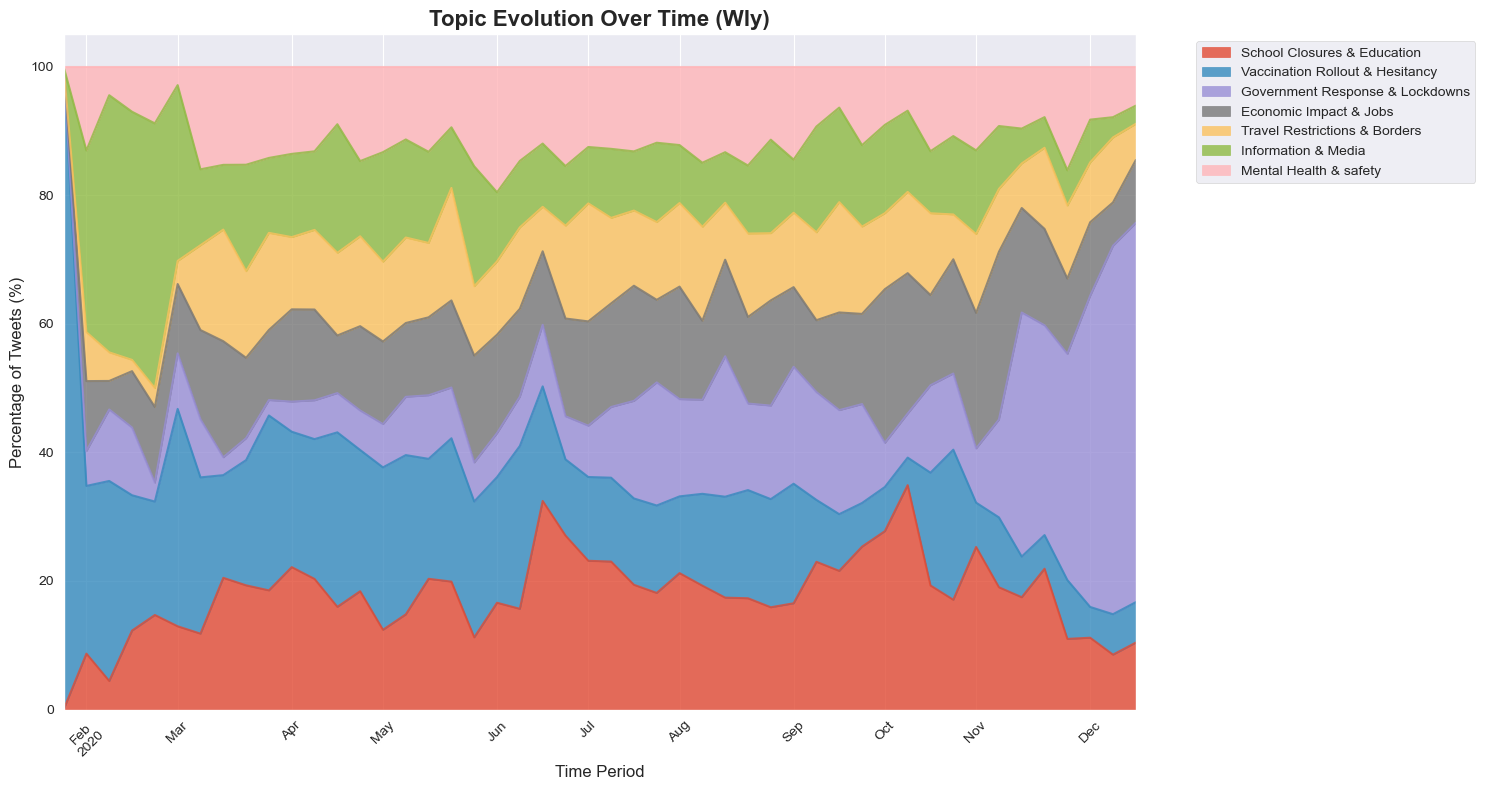


🔍 Emerging and Declining Topics:

🚀 Top 5 Emerging Topics:
   Government Response & Lockdowns: +0.67% per period
   School Closures & Education: +0.14% per period
   Economic Impact & Jobs: +0.13% per period
   Travel Restrictions & Borders: +0.05% per period

📉 Top 5 Declining Topics:
   Vaccination Rollout & Hesitancy: -0.63% per period
   Information & Media: -0.35% per period
   Mental Health & safety: -0.01% per period


In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Convert date to datetime if needed
df['date'] = pd.to_datetime(df['date'])

# Temporal analysis setup
def analyze_temporal_evolution(data, time_freq='W'):  # 'D' for daily, 'W' for weekly, 'M' for monthly
    """
    Analyze how topics evolved over time
    """
    print("📈 TEMPORAL ANALYSIS - Topic Evolution Over Time")
    print("=" * 60)
    
    # Set up time series
    data['time_period'] = data['date'].dt.to_period(time_freq)
    
    # Topic distribution over time
    topic_time_series = pd.crosstab(data['time_period'], data['theme'], normalize='index') * 100
    
    # Plot topic evolution
    plt.figure(figsize=(15, 10))
    
    # Top 10 themes for clarity
    top_themes = data['theme'].value_counts().head(10).index
    topic_time_series_top = topic_time_series[top_themes]
    
    ax = topic_time_series_top.plot(kind='area', alpha=0.8, stacked=True, figsize=(15, 8))
    plt.title(f'Topic Evolution Over Time ({time_freq}ly)', fontsize=16, fontweight='bold')
    plt.ylabel('Percentage of Tweets (%)')
    plt.xlabel('Time Period')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Identify emerging and declining topics
    print("\n🔍 Emerging and Declining Topics:")
    
    # Calculate trend for each topic
    topic_trends = {}
    for theme in topic_time_series.columns:
        series = topic_time_series[theme].dropna()
        if len(series) > 1:
            # Simple linear trend
            x = np.arange(len(series))
            slope = np.polyfit(x, series.values, 1)[0]
            topic_trends[theme] = slope
    
    # Sort by trend
    emerging = sorted([(theme, trend) for theme, trend in topic_trends.items() if trend > 0], 
                     key=lambda x: x[1], reverse=True)[:5]
    declining = sorted([(theme, trend) for theme, trend in topic_trends.items() if trend < 0], 
                      key=lambda x: x[1])[:5]
    
    print("\n🚀 Top 5 Emerging Topics:")
    for theme, trend in emerging:
        print(f"   {theme}: +{trend:.2f}% per period")
    
    print("\n📉 Top 5 Declining Topics:")
    for theme, trend in declining:
        print(f"   {theme}: {trend:.2f}% per period")
    
    return topic_time_series

# Run temporal analysis
topic_time_series = analyze_temporal_evolution(df, 'W')  # Weekly analysis


🌍 GEOGRAPHICAL ANALYSIS - Topic Distribution by Place


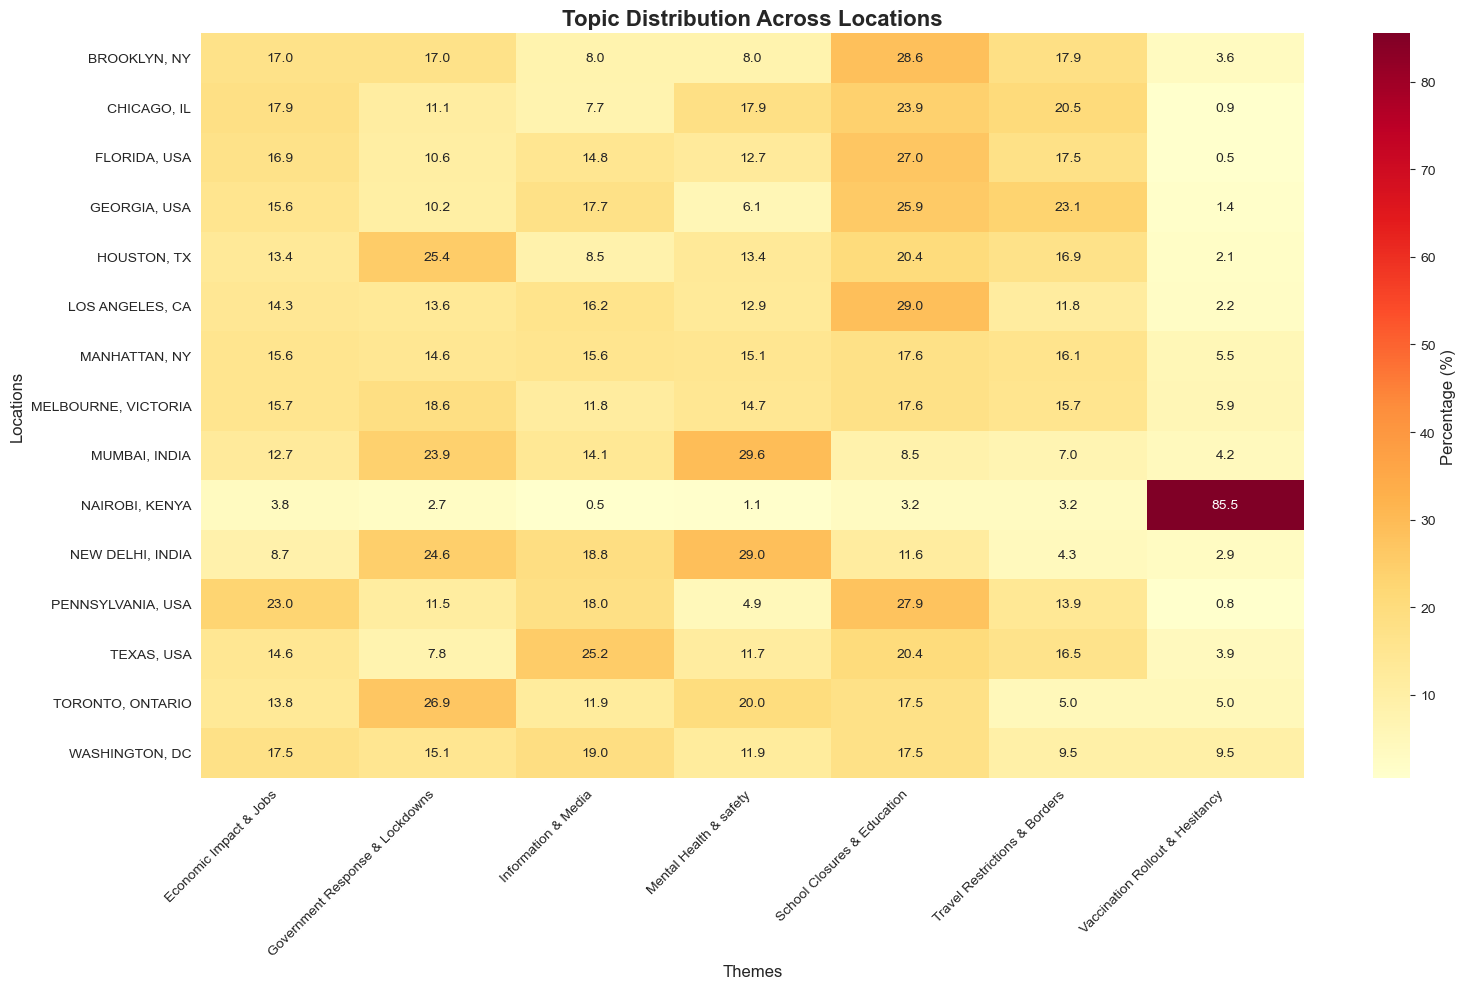


📍 Location-Specific Topic Dominance:
   LOS ANGELES, CA: School Closures & Education (0.9%)
   MANHATTAN, NY: School Closures & Education (0.4%)
   TORONTO, ONTARIO: Government Response & Lockdowns (0.7%)
   NEW DELHI, INDIA: Mental Health & safety (0.4%)
   FLORIDA, USA: School Closures & Education (0.9%)
   MUMBAI, INDIA: Mental Health & safety (0.4%)
   WASHINGTON, DC: Information & Media (0.5%)
   CHICAGO, IL: School Closures & Education (0.6%)


In [92]:
def analyze_geographical_distribution(data):
    """
    Analyze topic distribution across different locations
    """
    print("\n🌍 GEOGRAPHICAL ANALYSIS - Topic Distribution by Place")
    print("=" * 60)
    
    # Clean place data
    data['place_clean'] = data['place'].str.upper().str.strip()
    
    # Get top locations
    top_locations = data['place_clean'].value_counts().head(15).index
    
    # Create location-topic matrix
    location_topic_matrix = pd.crosstab(
        data[data['place_clean'].isin(top_locations)]['place_clean'],
        data[data['place_clean'].isin(top_locations)]['theme'],
        normalize='index'
    ) * 100
    
    # Plot heatmap
    plt.figure(figsize=(16, 10))
    sns.heatmap(location_topic_matrix, 
                cmap='YlOrRd', 
                annot=True, 
                fmt='.1f',
                cbar_kws={'label': 'Percentage (%)'})
    plt.title('Topic Distribution Across Locations', fontsize=16, fontweight='bold')
    plt.xlabel('Themes')
    plt.ylabel('Locations')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Location-specific insights
    print("\n📍 Location-Specific Topic Dominance:")
    for location in top_locations[:8]:  # Top 8 locations
        location_data = data[data['place_clean'] == location]
        if len(location_data) > 10:  # Only consider locations with sufficient data
            dominant_topic = location_data['theme'].value_counts().index[0]
            dominance_pct = (location_data['theme'].value_counts().iloc[0] / len(location_data)) * 100
            print(f"   {location}: {dominant_topic} ({dominance_pct:.1f}%)")
    
    return location_topic_matrix

# Run geographical analysis
location_analysis = analyze_geographical_distribution(df)


😊 SENTIMENT-TOPIC CORRELATION ANALYSIS (7 Emotions)
🔍 Data Check:
Sentiment column type: object
Unique sentiments: ['neutral' 'sadness' 'surprise' 'disgust' 'fear' 'joy' 'anger']
Sample sentiments: ['neutral', 'neutral', 'neutral', 'sadness', 'neutral', 'neutral', 'surprise', 'neutral', 'disgust', 'sadness']


<Figure size 1600x1000 with 0 Axes>

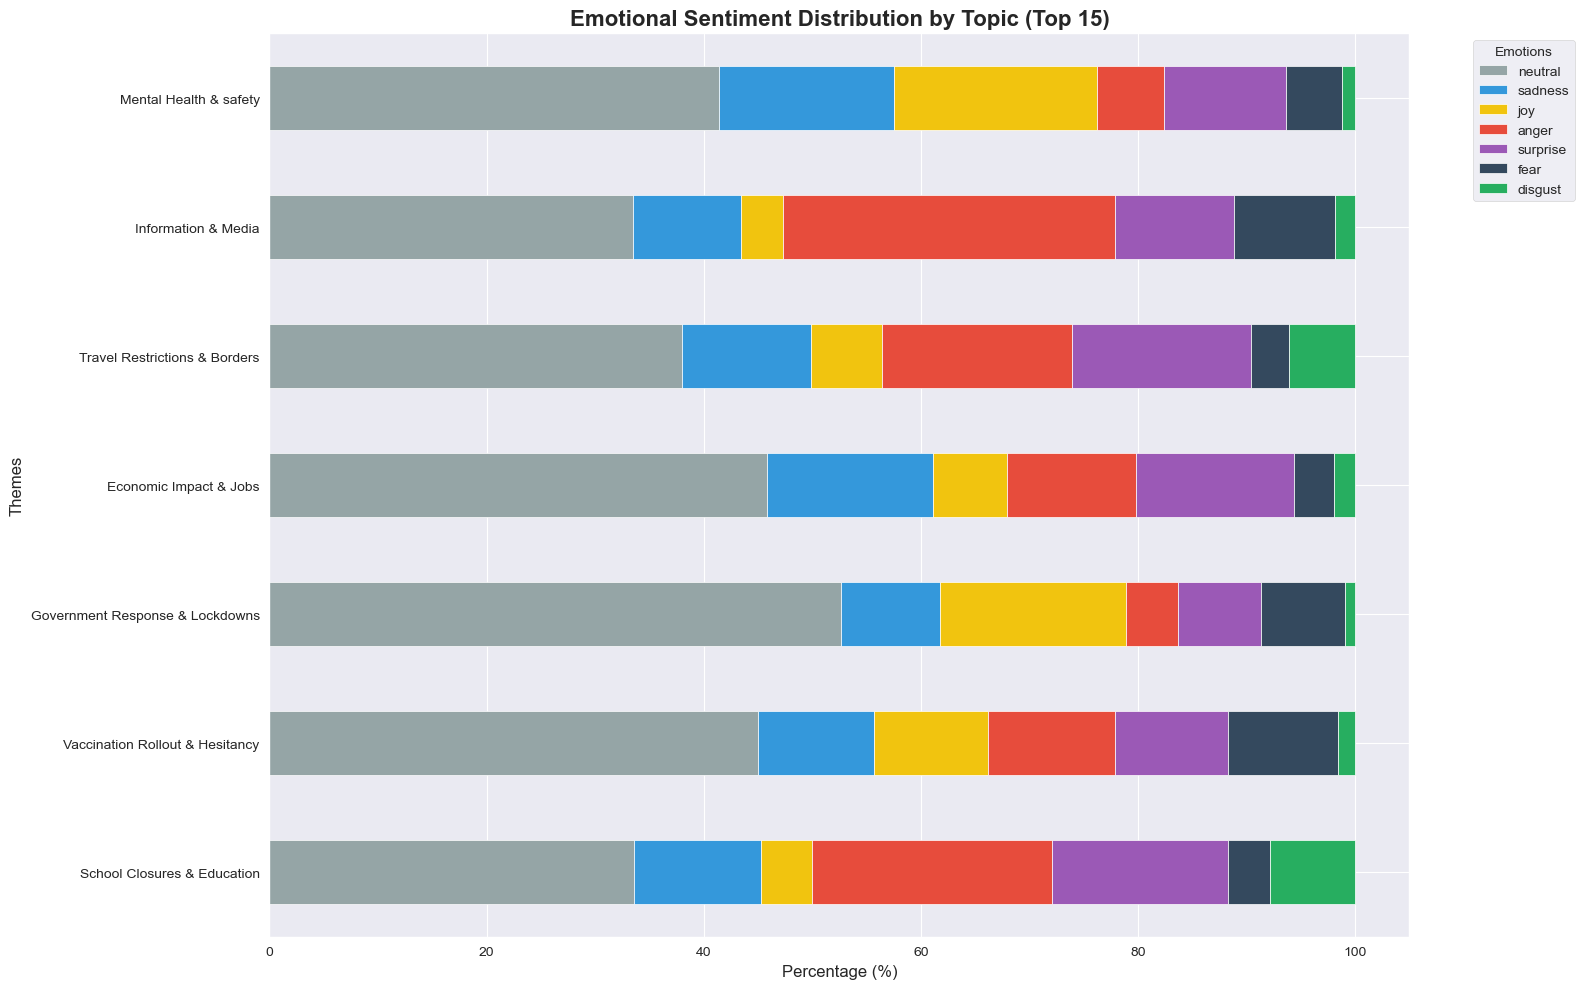


🎭 EMOTIONAL PROFILE BY TOPIC:
----------------------------------------------------------------------

😐 School Closures & Education:
   Dominant: neutral (33.6%)
❌ Error in sentiment analysis: Cannot use method 'nlargest' with dtype object
Trying alternative approach...

🔍 Simple Sentiment Analysis:
   neutral: 40.1%
   sadness: 14.4%
   joy: 12.9%
   anger: 11.0%
   surprise: 10.2%
   fear: 9.4%
   disgust: 2.0%

🎭 Top Topic-Sentiment Combinations:
   Vaccination Rollout & Hesitancy | neutral: 1298 tweets
   Government Response & Lockdowns | neutral: 1276 tweets
   Economic Impact & Jobs | neutral: 1098 tweets
   School Closures & Education | neutral: 1085 tweets
   Mental Health & safety | neutral: 853 tweets
   Travel Restrictions & Borders | neutral: 794 tweets
   School Closures & Education | anger: 712 tweets
   Information & Media | neutral: 691 tweets
   Information & Media | anger: 629 tweets
   School Closures & Education | surprise: 525 tweets


In [103]:
def analyze_sentiment_topic_correlation(data):
    """
    Analyze which topics have specific emotional sentiments
    """
    print("\n😊 SENTIMENT-TOPIC CORRELATION ANALYSIS (7 Emotions)")
    print("=" * 70)
    
    # Define emotion colors and icons
    emotion_colors = {
        'neutral': '#95a5a6',    # Gray
        'joy': '#f1c40f',        # Yellow
        'sadness': '#3498db',    # Blue
        'anger': '#e74c3c',      # Red
        'surprise': '#9b59b6',   # Purple
        'fear': '#34495e',       # Dark Blue
        'disgust': '#27ae60'     # Green
    }
    
    emotion_icons = {
        'neutral': '😐',
        'joy': '😊',
        'sadness': '😢',
        'anger': '😠',
        'surprise': '😮',
        'fear': '😨',
        'disgust': '🤢'
    }
    
    # First, let's check the data types and unique values
    print("🔍 Data Check:")
    print(f"Sentiment column type: {data['sentiment'].dtype}")
    print(f"Unique sentiments: {data['sentiment'].unique()}")
    print(f"Sample sentiments: {data['sentiment'].head(10).tolist()}")
    
    # Ensure sentiment column is string type
    data['sentiment'] = data['sentiment'].astype(str)
    
    # Sentiment distribution by topic
    sentiment_by_topic = pd.crosstab(data['theme'], data['sentiment'], normalize='index') * 100
    
    # Ensure all emotion columns exist (fill missing with 0)
    emotions_list = ['neutral', 'sadness', 'joy', 'anger', 'surprise', 'fear', 'disgust']
    for emotion in emotions_list:
        if emotion not in sentiment_by_topic.columns:
            sentiment_by_topic[emotion] = 0.0
    
    # Convert all emotion columns to float to ensure numeric operations
    for emotion in emotions_list:
        sentiment_by_topic[emotion] = sentiment_by_topic[emotion].astype(float)
    
    # Calculate dominant emotion for each topic
    sentiment_by_topic['dominant_emotion'] = sentiment_by_topic[emotions_list].idxmax(axis=1)
    sentiment_by_topic['dominant_pct'] = sentiment_by_topic[emotions_list].max(axis=1)
    
    # Sort by total count for better visualization
    topic_counts = data['theme'].value_counts()
    sentiment_by_topic['total_count'] = sentiment_by_topic.index.map(topic_counts)
    sentiment_by_topic = sentiment_by_topic.sort_values('total_count', ascending=False)
    
    # Plot sentiment by topic (Top 15 topics for clarity)
    plt.figure(figsize=(16, 10))
    
    top_topics = sentiment_by_topic.head(15)
    
    colors = [emotion_colors.get(emotion, '#cccccc') for emotion in emotions_list]
    ax = top_topics[emotions_list].plot(kind='barh', stacked=True, figsize=(16, 10), color=colors)
    
    plt.title('Emotional Sentiment Distribution by Topic (Top 15)', fontsize=16, fontweight='bold')
    plt.xlabel('Percentage (%)')
    plt.ylabel('Themes')
    plt.legend(title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Print detailed emotion insights
    print("\n🎭 EMOTIONAL PROFILE BY TOPIC:")
    print("-" * 70)
    
    for topic, row in sentiment_by_topic.head(10).iterrows():
        dominant_emo = row['dominant_emotion']
        dominant_pct = row['dominant_pct']
        icon = emotion_icons.get(dominant_emo, '❓')
        
        print(f"\n{icon} {topic}:")
        print(f"   Dominant: {dominant_emo} ({dominant_pct:.1f}%)")
        
        # Show top 3 emotions (ensure numeric comparison)
        topic_emotions = row[emotions_list]
        top_emotions = topic_emotions.nlargest(3)
        
        for emotion, pct in top_emotions.items():
            if emotion != dominant_emo and pct > 5.0:  # Ensure numeric comparison
                print(f"   {emotion_icons.get(emotion, '❓')} {emotion}: {pct:.1f}%")
    
    # Emotion intensity analysis
    print("\n🔥 EMOTION INTENSITY ANALYSIS:")
    print("-" * 50)
    
    # Calculate emotional diversity (lower = more focused on one emotion)
    # Use std deviation of emotion percentages
    sentiment_by_topic['emotion_diversity'] = sentiment_by_topic[emotions_list].std(axis=1)
    
    # Most emotionally focused topics (low diversity)
    focused_topics = sentiment_by_topic.nsmallest(5, 'emotion_diversity')
    print("\n🎯 Most Emotionally Focused Topics:")
    for topic, row in focused_topics.iterrows():
        dominant = row['dominant_emotion']
        icon = emotion_icons.get(dominant, '❓')
        print(f"   {icon} {topic}: {dominant} ({row['dominant_pct']:.1f}%)")
    
    # Most emotionally diverse topics
    diverse_topics = sentiment_by_topic.nlargest(5, 'emotion_diversity')
    print("\n🌈 Most Emotionally Diverse Topics:")
    for topic, row in diverse_topics.iterrows():
        top3 = row[emotions_list].nlargest(3)
        emotions_str = ", ".join([f"{emotion_icons.get(emotion, '❓')}{emotion}({pct:.1f}%)" 
                                for emotion, pct in top3.items()])
        print(f"   {topic}: {emotions_str}")
    
    # Specific emotion hotspots
    print("\n📍 EMOTION HOTSPOTS:")
    print("-" * 30)
    
    for emotion in ['joy', 'anger', 'fear', 'disgust']:
        if emotion in sentiment_by_topic.columns:
            # Ensure we're working with numeric values
            emotion_series = sentiment_by_topic[emotion].astype(float)
            emotion_topics = emotion_series.nlargest(3)
            
            print(f"\n{emotion_icons.get(emotion, '❓')} Top {emotion} topics:")
            for topic, pct in emotion_topics.items():
                print(f"   {topic}: {pct:.1f}%")
    
    return sentiment_by_topic

# Run updated sentiment analysis with error handling
try:
    sentiment_analysis = analyze_sentiment_topic_correlation(df)
except Exception as e:
    print(f"❌ Error in sentiment analysis: {e}")
    print("Trying alternative approach...")
    
    # Alternative: Simple value counts approach
    print("\n🔍 Simple Sentiment Analysis:")
    sentiment_dist = df['sentiment'].value_counts(normalize=True) * 100
    for sentiment, pct in sentiment_dist.items():
        print(f"   {sentiment}: {pct:.1f}%")
    
    # Topic-sentiment combinations
    print("\n🎭 Top Topic-Sentiment Combinations:")
    topic_sentiment = df.groupby(['theme', 'sentiment']).size().nlargest(10)
    for (topic, sentiment), count in topic_sentiment.items():
        print(f"   {topic} | {sentiment}: {count} tweets")


🕸️  EMOTION RELATIONSHIP ANALYSIS


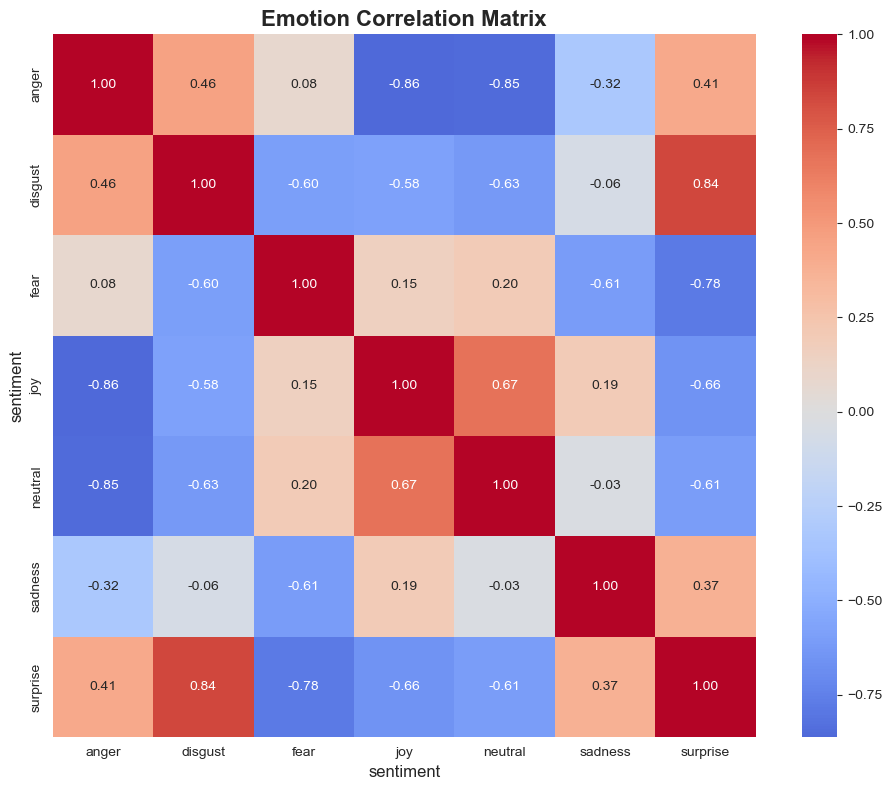


🤝 EMOTION CO-OCCURRENCE PATTERNS:
   😠anger and 🤢disgust: positively correlated (r=0.46)
   😠anger and 😊joy: negatively correlated (r=-0.86)
   😠anger and 😐neutral: negatively correlated (r=-0.85)
   😠anger and 😢sadness: negatively correlated (r=-0.32)
   😠anger and 😮surprise: positively correlated (r=0.41)
   🤢disgust and 😨fear: negatively correlated (r=-0.60)
   🤢disgust and 😊joy: negatively correlated (r=-0.58)
   🤢disgust and 😐neutral: negatively correlated (r=-0.63)
   🤢disgust and 😮surprise: positively correlated (r=0.84)
   😨fear and 😢sadness: negatively correlated (r=-0.61)
   😨fear and 😮surprise: negatively correlated (r=-0.78)
   😊joy and 😐neutral: positively correlated (r=0.67)
   😊joy and 😮surprise: negatively correlated (r=-0.66)
   😐neutral and 😮surprise: negatively correlated (r=-0.61)
   😢sadness and 😮surprise: positively correlated (r=0.37)


In [121]:
def analyze_emotion_relationships(data):
    """
    Analyze relationships between emotions across topics
    """
    print("\n🕸️  EMOTION RELATIONSHIP ANALYSIS")
    print("=" * 50)
    
    # Create emotion correlation matrix
    emotion_pivot = data.pivot_table(
        index='theme', 
        columns='sentiment', 
        values='text', 
        aggfunc='count', 
        fill_value=0
    )
    
    # Normalize by topic size
    topic_sizes = emotion_pivot.sum(axis=1)
    emotion_pivot_normalized = emotion_pivot.div(topic_sizes, axis=0)
    
    # Calculate emotion correlations
    emotion_correlation = emotion_pivot_normalized.corr()
    
    # Plot emotion correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(emotion_correlation, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                square=True,
                fmt='.2f')
    plt.title('Emotion Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Find emotion pairs that often co-occur

    emotion_icons = {
        'neutral': '😐',
        'joy': '😊',
        'sadness': '😢',
        'anger': '😠',
        'surprise': '😮',
        'fear': '😨',
        'disgust': '🤢'
    }
    print("\n🤝 EMOTION CO-OCCURRENCE PATTERNS:")
    for i in range(len(emotion_correlation.columns)):
        for j in range(i+1, len(emotion_correlation.columns)):
            emotion1 = emotion_correlation.columns[i]
            emotion2 = emotion_correlation.columns[j]
            correlation = emotion_correlation.iloc[i, j]
            
            if abs(correlation) > 0.3:  # Significant correlation
                relationship = "positively" if correlation > 0 else "negatively"
                print(f"   {emotion_icons[emotion1]}{emotion1} and {emotion_icons[emotion2]}{emotion2}: "
                      f"{relationship} correlated (r={correlation:.2f})")

# Run emotion relationship analysis
analyze_emotion_relationships(df)


📊 LARGE INTERACTIVE EMOTION VISUALIZATIONS
Creating large sunburst chart...


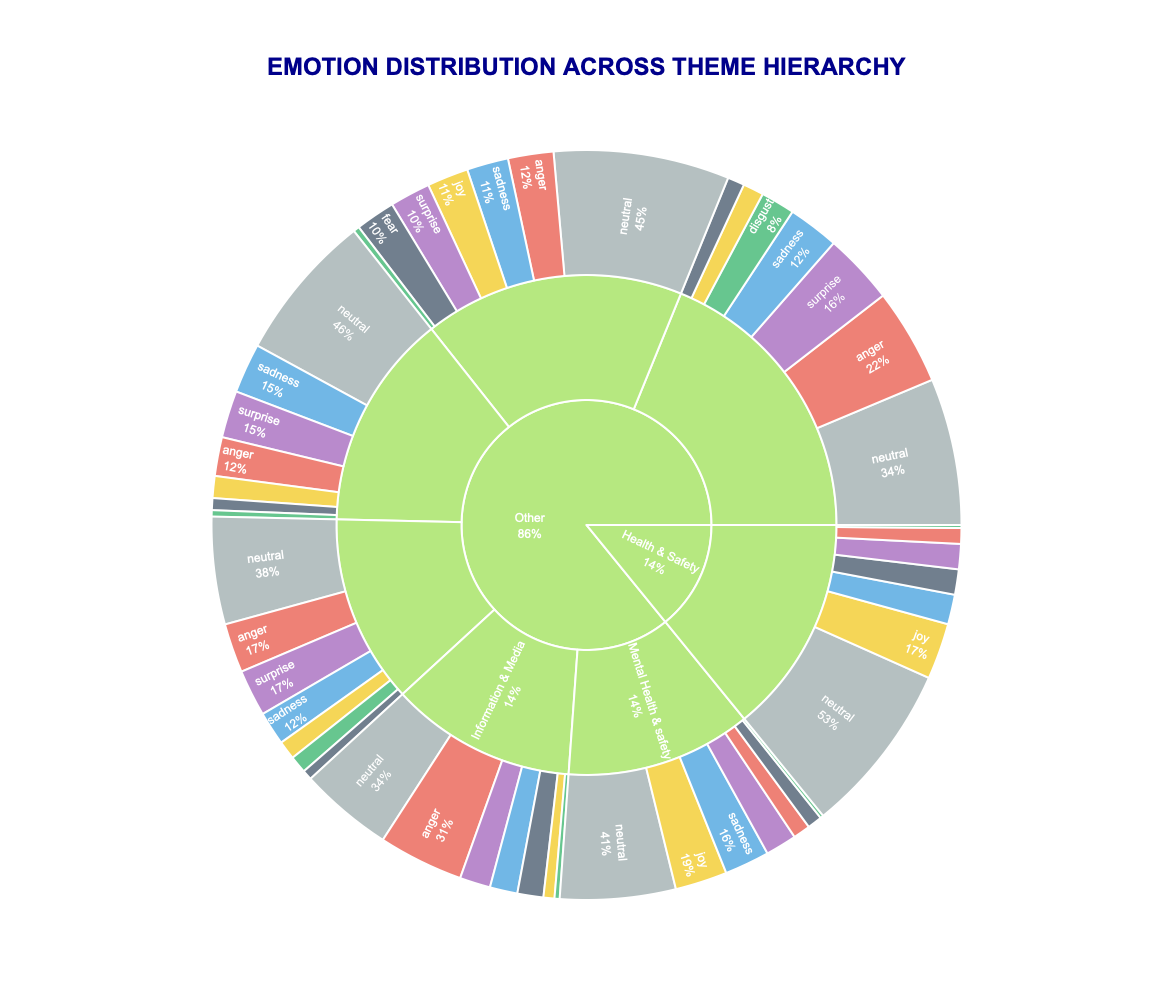

Creating large radar chart...


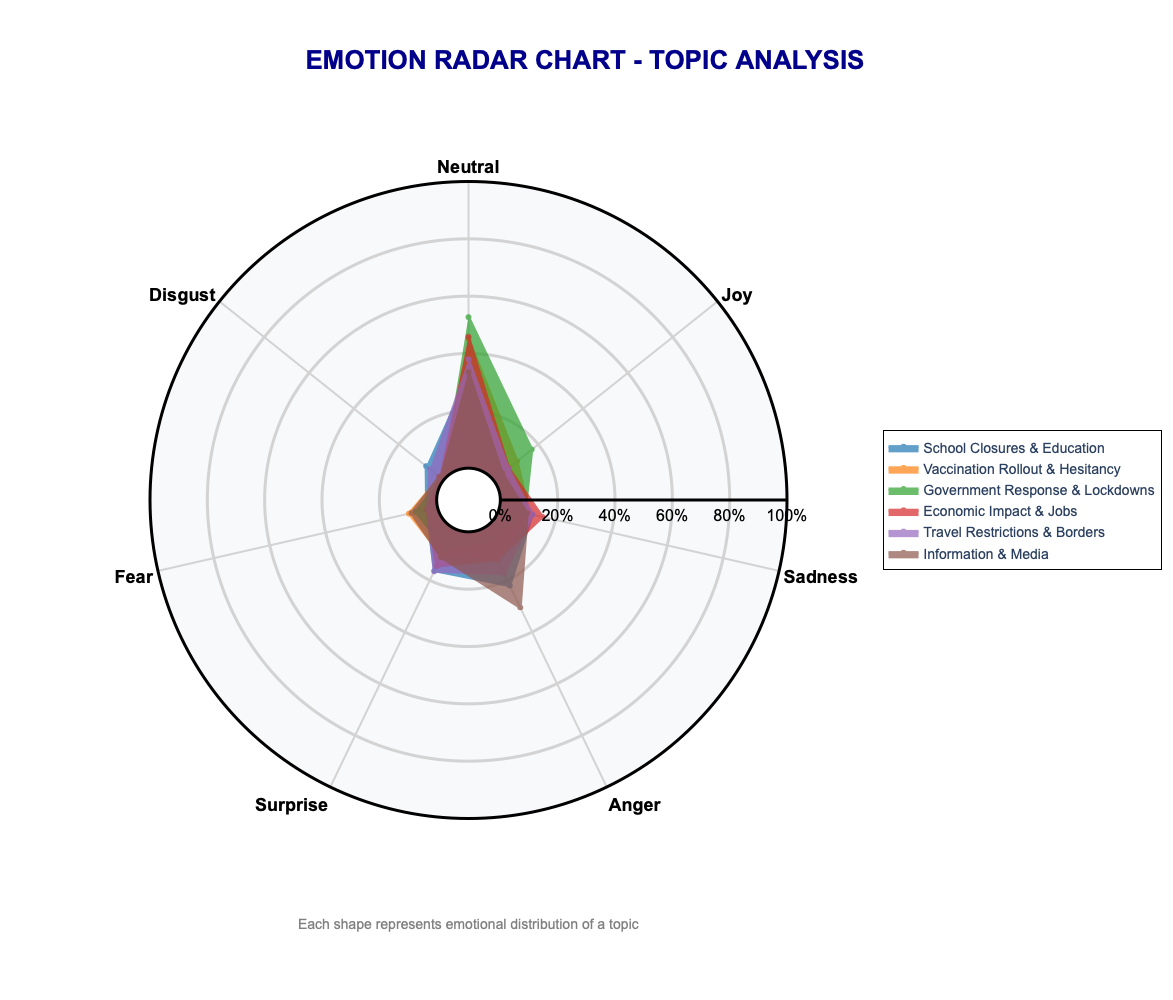

✅ Both large charts created with increased margins!
💾 Charts saved as HTML files for maximum viewing size


In [162]:
def create_large_emotion_visualizations(data):
    """
    Create both sunburst and radar charts with increased sizes and margins
    """
    print("\n📊 LARGE INTERACTIVE EMOTION VISUALIZATIONS")
    print("=" * 60)
    
    # Prepare data for both charts
    emotion_hierarchy = data.groupby(['theme_broad', 'theme', 'sentiment']).size().reset_index()
    emotion_hierarchy.columns = ['Broad_Theme', 'Specific_Theme', 'Emotion', 'Count']
    
    # 1. LARGE SUNBURST CHART WITH INCREASED MARGINS
    print("Creating large sunburst chart...")
    sunburst_fig = px.sunburst(
        emotion_hierarchy, 
        path=['Broad_Theme', 'Specific_Theme', 'Emotion'], 
        values='Count',
        title='<b>EMOTION DISTRIBUTION ACROSS THEME HIERARCHY</b>',
        color='Emotion',
        color_discrete_map={
            'neutral': '#95a5a6',
            'joy': '#f1c40f', 
            'sadness': '#3498db',
            'anger': '#e74c3c',
            'surprise': '#9b59b6',
            'fear': '#34495e',
            'disgust': '#27ae60'
        },
        # Increased dimensions
        width=1300,
        height=1000,
        maxdepth=3,
    )
    
    # Sunburst layout with increased margins and sizes
    sunburst_fig.update_layout(
        font=dict(size=16, family="Arial"),
        title_font=dict(size=24, family="Arial", color='darkblue'),
        title_x=0.5,
        # SIGNIFICANTLY INCREASED MARGINS
        margin=dict(t=150, l=100, r=100, b=100),  # Increased from default
        paper_bgcolor='white',
        plot_bgcolor='white',
        # Additional spacing
        uniformtext=dict(minsize=12, mode='hide'),
    )
    
    # Sunburst trace customization
    sunburst_fig.update_traces(
        textfont=dict(size=14, color='white', family="Arial"),
        textinfo='label+percent parent',
        hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percentParent:.1%}<extra></extra>',
        marker=dict(line=dict(width=2, color='white')),
        insidetextorientation='radial'
    )
    
    # Show sunburst
    sunburst_fig.show()
    
    # 2. LARGE RADAR CHART WITH INCREASED MARGINS
    print("Creating large radar chart...")
    
    # Prepare radar data
    top_topics = data['theme'].value_counts().head(6).index
    radar_data = []
    
    for topic in top_topics:
        topic_emotions = data[data['theme'] == topic]['sentiment'].value_counts(normalize=True)
        emotion_profile = {emotion: topic_emotions.get(emotion, 0) * 100 for emotion in 
                          ['neutral', 'joy', 'sadness', 'anger', 'surprise', 'fear', 'disgust']}
        emotion_profile['topic'] = topic
        radar_data.append(emotion_profile)
    
    radar_df = pd.DataFrame(radar_data)
    
    # Create large radar chart
    radar_fig = go.Figure()
    
    # Color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    for idx, (_, row) in enumerate(radar_df.iterrows()):
        radar_fig.add_trace(go.Scatterpolar(
            r=row[['neutral', 'joy', 'sadness', 'anger', 'surprise', 'fear', 'disgust']].values,
            theta=['Neutral', 'Joy', 'Sadness', 'Anger', 'Surprise', 'Fear', 'Disgust'],
            fill='toself',
            name=row['topic'],
            line=dict(width=3, color=colors[idx % len(colors)]),
            fillcolor=colors[idx % len(colors)],
            opacity=0.7
        ))
    
    # Radar layout with increased margins and sizes
    radar_fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 100],
                tickfont=dict(size=16, family="Arial", color="black"),
                ticklen=15,
                tickwidth=2,
                gridwidth=3,
                gridcolor='lightgray',
                linewidth=3,
                linecolor='black',
                showline=True,
                nticks=6,
                tickvals=[0, 20, 40, 60, 80, 100],
                ticktext=['0%', '20%', '40%', '60%', '80%', '100%']
            ),
            angularaxis=dict(
                tickfont=dict(size=18, family="Arial", color="black", weight="bold"),
                rotation=90,
                direction="clockwise",
                gridwidth=2,
                gridcolor='lightgray',
                linewidth=3,
                linecolor='black'
            ),
            bgcolor='#f8f9fa',
            hole=0.1
        ),
        title=dict(
            text="<b>EMOTION RADAR CHART - TOPIC ANALYSIS</b>",
            font=dict(size=26, family="Arial", color="darkblue"),
            x=0.5,
            y=0.95
        ),
        # Increased dimensions
        width=1300,
        height=1000,
        font=dict(size=16, family="Arial"),
        legend=dict(
            font=dict(size=14),
            x=1.15,
            y=0.5,
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor='black',
            borderwidth=1,
            # Increased legend margins
            xanchor='left',
            yanchor='middle'
        ),
        paper_bgcolor='white',
        # SIGNIFICANTLY INCREASED MARGINS FOR RADAR
        margin=dict(t=150, l=150, r=250, b=150),  # Extra right margin for legend
    )
    
    # Add annotation
    radar_fig.add_annotation(
        text="Each shape represents emotional distribution of a topic",
        xref="paper", yref="paper",
        x=0.5, y=-0.12,
        showarrow=False,
        font=dict(size=14, color="gray")
    )
    
    # Show radar
    radar_fig.show()
    
    # Save both charts as HTML for maximum viewing size
    sunburst_fig.write_html("large_emotion_sunburst.html")
    radar_fig.write_html("large_emotion_radar.html")
    
    print("✅ Both large charts created with increased margins!")
    print("💾 Charts saved as HTML files for maximum viewing size")
    
    return sunburst_fig, radar_fig

# Create both large visualizations
sunburst, radar = create_large_emotion_visualizations(df)

In [166]:
def generate_emotion_summary_report(data):
    """
    Generate comprehensive report with 7 emotion analysis
    """
    print("\n📋 COMPREHENSIVE EMOTION ANALYSIS REPORT")
    print("=" * 80)
    
    emotion_icons = {
        'neutral': '😐',
        'joy': '😊',
        'sadness': '😢',
        'anger': '😠',
        'surprise': '😮',
        'fear': '😨',
        'disgust': '🤢'
    }
    # Overall emotion distribution
    emotion_dist = data['sentiment'].value_counts(normalize=True) * 100
    
    print("🎭 OVERALL EMOTION DISTRIBUTION:")
    for emotion, pct in emotion_dist.items():
        icon = emotion_icons.get(emotion, '❓')
        print(f"   {icon} {emotion}: {pct:.1f}%")
    
    # Most emotional topics
    print(f"\n🔥 MOST EMOTIONALLY CHARGED TOPICS:")
    
    for emotion in ['joy', 'anger', 'fear', 'disgust']:
        emotion_topics = data.groupby('theme')['sentiment'].apply(
            lambda x: (x == emotion).mean() * 100
        ).nlargest(1)
        
        if not emotion_topics.empty:
            topic = emotion_topics.index[0]
            pct = emotion_topics.iloc[0]
            print(f"   {emotion_icons[emotion]} Highest {emotion}: '{topic}' ({pct:.1f}%)")
    
    # Emotional journey by time (if temporal data available)
    if 'date' in data.columns:
        print(f"\n📅 EMOTIONAL TIMELINE INSIGHTS:")
        data['month'] = data['date'].dt.to_period('M')
        monthly_emotions = data.groupby('month')['sentiment'].value_counts(normalize=True).unstack() * 100
        
        # Find emotion trends
        for emotion in ['fear', 'anger', 'joy']:
            if emotion in monthly_emotions.columns:
                max_month = monthly_emotions[emotion].idxmax()
                max_pct = monthly_emotions[emotion].max()
                print(f"   {emotion_icons[emotion]} Peak {emotion}: {max_month} ({max_pct:.1f}%)")

# Generate final emotion report
generate_emotion_summary_report(df)


📋 COMPREHENSIVE EMOTION ANALYSIS REPORT
🎭 OVERALL EMOTION DISTRIBUTION:
   😐 neutral: 40.1%
   😢 sadness: 14.4%
   😊 joy: 12.9%
   😠 anger: 11.0%
   😮 surprise: 10.2%
   😨 fear: 9.4%
   🤢 disgust: 2.0%

🔥 MOST EMOTIONALLY CHARGED TOPICS:
   😊 Highest joy: 'Mental Health & safety' (18.7%)
   😠 Highest anger: 'Information & Media' (30.5%)
   😨 Highest fear: 'Vaccination Rollout & Hesitancy' (10.2%)
   🤢 Highest disgust: 'School Closures & Education' (7.8%)

📅 EMOTIONAL TIMELINE INSIGHTS:
   😨 Peak fear: 2020-01 (21.5%)
   😠 Peak anger: 2020-10 (12.6%)
   😊 Peak joy: 2020-05 (14.6%)


In [168]:
def generate_comprehensive_report(data):
    """
    Generate a comprehensive analysis report
    """
    print("\n📋 COMPREHENSIVE ANALYSIS REPORT")
    print("=" * 80)
    
    total_tweets = len(data)
    unique_themes = data['theme'].nunique()
    
    print(f"📊 Dataset Overview:")
    print(f"   • Total Tweets: {total_tweets:,}")
    print(f"   • Unique Themes: {unique_themes}")
    print(f"   • Date Range: {data['date'].min().strftime('%Y-%m-%d')} to {data['date'].max().strftime('%Y-%m-%d')}")
    print(f"   • Unique Locations: {data['place'].nunique()}")
    
    # Key findings
    print(f"\n🎯 Key Findings:")
    
    # Most popular theme
    most_popular = data['theme'].value_counts().index[0]
    popular_pct = (data['theme'].value_counts().iloc[0] / total_tweets) * 100
    print(f"   • Most Popular Theme: '{most_popular}' ({popular_pct:.1f}% of tweets)")
    
   
    
    # Temporal insights
    if 'time_period' in data.columns:
        period_counts = data['time_period'].value_counts()
        busiest_period = period_counts.index[0]
        print(f"   • Busiest Period: {busiest_period} ({period_counts.iloc[0]} tweets)")
    
    # Geographical insights
    if data['place'].nunique() > 1:
        most_active_location = data['place'].value_counts().index[0]
        print(f"   • Most Active Location: {most_active_location}")

# Generate final report
generate_comprehensive_report(df)

# Save analyzed dataset
#original_data.to_csv('covid_tweets_comprehensive_analysis.csv', index=False)
print(f"\n💾 Analysis complete! Dataset saved with all insights.")


📋 COMPREHENSIVE ANALYSIS REPORT
📊 Dataset Overview:
   • Total Tweets: 595,929
   • Unique Themes: 7
   • Date Range: 2020-01-22 to 2020-12-20
   • Unique Locations: 31588

🎯 Key Findings:
   • Most Popular Theme: 'School Closures & Education' (0.5% of tweets)
   • Busiest Period: 2020-03-23/2020-03-29 (22954 tweets)
   • Most Active Location: Los Angeles, CA

💾 Analysis complete! Dataset saved with all insights.


In [170]:
#Topic Summary
# Group by topic to get frequency
topic_summary = (
    df.groupby(["topic", "topic_name", "topic_keywords"])
      .size()
      .rename("tweet_count")
      .reset_index()
      .sort_values("tweet_count", ascending=False)
)

# Top sentiment per topic
topic_sentiment_dist = (
    df.groupby(["topic", "sentiment"]).size()
      .unstack(fill_value=0)
)
topic_sentiment_prop = topic_sentiment_dist.div(topic_sentiment_dist.sum(axis=1), axis=0)

# Join frequency + sentiment proportions
topic_summary = topic_summary.merge(topic_sentiment_prop, left_on="topic", right_index=True, how="left")

display(topic_summary.head(10))
#topic_summary.to_csv("topic_summary.csv", index=False)
print("✅ topic_summary.csv saved")

,topic,topic_name,topic_keywords,tweet_count,anger,disgust,fear,joy,neutral,sadness,surprise
0,0,0_dude_idiot_asshole_course did,"dude, idiot, asshole, course did, hes wrong",3229,0.220502,0.078043,0.038712,0.047383,0.336017,0.116754,0.162589
1,1,1_nigeria_africa_lagos_nigerians,"nigeria, africa, lagos, nigerians, south africa",2884,0.116505,0.015603,0.101942,0.105756,0.450069,0.106449,0.103675
2,2,2_vaccine_vaccines_vaccine vaccine_vaccination,"vaccine, vaccines, vaccine vaccine, vaccinatio...",2422,0.047894,0.009083,0.077209,0.171346,0.526837,0.090834,0.076796
3,3,3_hes going_golf_hes doing_hes gonna,"hes going, golf, hes doing, hes gonna, hope gets",2398,0.119683,0.019600,0.036697,0.067556,0.457882,0.153461,0.145121
4,4,4_shes_woman_karen_girl,"shes, woman, karen, girl, bitch",2090,0.174163,0.061244,0.034928,0.066029,0.379904,0.118660,0.165072
5,5,5_china_chinese_communist_chinas,"china, chinese, communist, chinas, xi",2062,0.305044,0.018429,0.093113,0.039282,0.335112,0.098933,0.110087
6,6,6_help self_unprecedented situation_video siso...,"help self, unprecedented situation, video siso...",2060,0.061650,0.011650,0.052427,0.186893,0.414078,0.161165,0.112136
7,7,7_china_chinese_chinas_communist,"china, chinese, chinas, communist, china china",2054,0.171373,0.020448,0.083739,0.096397,0.416748,0.110516,0.100779
8,8,8_ampm_webinar_register_youth,"ampm, webinar, register, youth, industry",2013,0.012419,0.001490,0.051167,0.385991,0.384998,0.105315,0.058619
9,9,9_vaccine_vaccines_vaccination_vaccinated,"vaccine, vaccines, vaccination, vaccinated, pf...",1921,0.142113,0.013535,0.130141,0.087975,0.434669,0.099948,0.091619


✅ topic_summary.csv saved


In [172]:
# Theme frequency
theme_summary = (
    df.groupby("theme")
      .size()
      .rename("tweet_count")
      .reset_index()
      .sort_values("tweet_count", ascending=False)
)

# Theme × sentiment distribution
theme_sentiment_dist = (
    df.groupby(["theme", "sentiment"]).size()
      .unstack(fill_value=0)
)
theme_sentiment_prop = theme_sentiment_dist.div(theme_sentiment_dist.sum(axis=1), axis=0)

# Join frequency + sentiment proportions
theme_summary = theme_summary.merge(theme_sentiment_prop, on="theme", how="left")

display(theme_summary.head(10))
#theme_summary.to_csv("theme_summary.csv", index=False)
print("✅ theme_summary.csv saved")

,theme,tweet_count,anger,disgust,fear,joy,neutral,sadness,surprise
0,School Closures & Education,3229,0.220502,0.078043,0.038712,0.047383,0.336017,0.116754,0.162589
1,Vaccination Rollout & Hesitancy,2884,0.116505,0.015603,0.101942,0.105756,0.450069,0.106449,0.103675
2,Government Response & Lockdowns,2422,0.047894,0.009083,0.077209,0.171346,0.526837,0.090834,0.076796
3,Economic Impact & Jobs,2398,0.119683,0.019600,0.036697,0.067556,0.457882,0.153461,0.145121
4,Travel Restrictions & Borders,2090,0.174163,0.061244,0.034928,0.066029,0.379904,0.118660,0.165072
5,Information & Media,2062,0.305044,0.018429,0.093113,0.039282,0.335112,0.098933,0.110087
6,Mental Health & safety,2060,0.061650,0.011650,0.052427,0.186893,0.414078,0.161165,0.112136


✅ theme_summary.csv saved


In [174]:
# Overall sentiment distribution
sentiment_summary = (
    df["sentiment"].value_counts(normalize=True).rename("proportion").reset_index()
)
sentiment_summary.columns = ["sentiment", "proportion"]

display(sentiment_summary)
# sentiment_summary.to_csv("sentiment_summary.csv", index=False)
print("✅ sentiment_summary.csv saved")

,sentiment,proportion
0,neutral,0.400784
1,sadness,0.143757
2,joy,0.129307
3,anger,0.110074
4,surprise,0.101891
5,fear,0.093822
6,disgust,0.020365


✅ sentiment_summary.csv saved


In [180]:
# Parse and clean date
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).copy()

# Extract time buckets
df["week"] = df["date"].dt.to_period("W").astype(str)
df["month"] = df["date"].dt.to_period("M").astype(str)

# Clean categorical fields
df["theme"] = df["theme"].fillna("Unlabeled").astype(str).str.strip()
df["topic_name"] = df["topic_name"].fillna("").astype(str).str.strip()
df["sentiment"] = df["sentiment"].astype(str).str.strip().str.lower()

print(f"✅ Loaded {len(df):,} rows for time series analysis")
df.head()

✅ Loaded 595,929 rows for time series analysis


,date,place,text,sentiment,topic,topic_words,topic_name,topic_keywords,theme_broad,theme_specific,theme_full,theme,time_period,place_clean,month,week
0,2020-01-22,Jamaica,talking about the jamaica look out for this w...,neutral,1,"nigeria, africa, lagos, nigerians, south afric...",1_nigeria_africa_lagos_nigerians,"nigeria, africa, lagos, nigerians, south africa",Other,Nigeria & Africa & Lagos,Other: Nigeria & Africa & Lagos,Vaccination Rollout & Hesitancy,2020-01-20/2020-01-26,JAMAICA,2020-01,2020-01-20/2020-01-26
1,2020-01-23,"St Peters, MO",legit i got a here in stl last week just the ...,neutral,53,"china, korea, chinese, south korea, taiwan, ho...",53_china_korea_chinese_south korea,"china, korea, chinese, south korea, taiwan",Other,Merged: Merged: Merged: China & Chinese & Comm...,Other: Merged: Merged: Merged: China & Chinese...,Unlabeled,2020-01-20/2020-01-26,"ST PETERS, MO",2020-01,2020-01-20/2020-01-26
2,2020-01-23,"Catarman, Eastern Visayas",sure was purposely created by scientists but ...,neutral,460,"fda, drug, pharmacies, pharma, big pharma, hyd...",460_fda_drug_pharmacies_pharma,"fda, drug, pharmacies, pharma, big pharma",Other,Merged: Merged: Hydroxychloroquine & Drug & De...,Other: Merged: Merged: Hydroxychloroquine & Dr...,Unlabeled,2020-01-20/2020-01-26,"CATARMAN, EASTERN VISAYAS",2020-01,2020-01-20/2020-01-26
3,2020-01-23,"Adelaide, South Australia",jeremy cordeaux tonight selling live koalas to...,sadness,367,"rent, small businesses, employees, sales, pani...",367_rent_small businesses_employees_sales,"rent, small businesses, employees, sales, pani...",Other,Merged: Merged: Merged: Merged: Merged: Store ...,Other: Merged: Merged: Merged: Merged: Merged:...,Unlabeled,2020-01-20/2020-01-26,"ADELAIDE, SOUTH AUSTRALIA",2020-01,2020-01-20/2020-01-26
4,2020-01-24,"Tai Po District, Hong Kong",spreading across and the rest of the prc sta...,neutral,506,"china, chinese, hong, chinas, hong kong, kong,...",506_china_chinese_hong_chinas,"china, chinese, hong, chinas, hong kong",Other,Merged: Merged: Merged: Merged: Merged: Merged...,Other: Merged: Merged: Merged: Merged: Merged:...,Unlabeled,2020-01-20/2020-01-26,"TAI PO DISTRICT, HONG KONG",2020-01,2020-01-20/2020-01-26


In [182]:
#Group weekly by theme and sentiment
weekly_theme_sentiment = (
    df.groupby(["week", "theme", "sentiment"])
      .size()
      .rename("count")
      .reset_index()
)

# Pivot to get sentiment proportions per theme per week
weekly_theme_sentiment_pivot = (
    weekly_theme_sentiment
    .pivot_table(index=["week", "theme"], columns="sentiment", values="count", fill_value=0)
)

# Convert to proportions (row-wise)
weekly_theme_sentiment_prop = weekly_theme_sentiment_pivot.div(
    weekly_theme_sentiment_pivot.sum(axis=1), axis=0
)

# Save to CSV
weekly_theme_sentiment_prop.to_csv("weekly_theme_sentiment_summary.csv")
print("✅ Saved weekly_theme_sentiment_summary.csv")
weekly_theme_sentiment_prop.head(10)

✅ Saved weekly_theme_sentiment_summary.csv


sentiment                                                 anger   disgust  \
week                  theme                                                 
2020-01-20/2020-01-26 Unlabeled                        0.000000  0.062500   
                      Vaccination Rollout & Hesitancy  0.000000  0.000000   
2020-01-27/2020-02-02 Economic Impact & Jobs           0.000000  0.100000   
                      Government Response & Lockdowns  0.200000  0.000000   
                      Information & Media              0.076923  0.038462   
                      Mental Health & safety           0.083333  0.000000   
                      School Closures & Education      0.000000  0.000000   
                      Travel Restrictions & Borders    0.000000  0.000000   
                      Unlabeled                        0.066834  0.017822   
                      Vaccination Rollout & Hesitancy  0.000000  0.000000   

sentiment                                                  fear       joy  \
week                  theme                                                 
2020-01-20/2020-01-26 Unlabeled                        0.062500  0.000000   
                      Vaccination Rollout & Hesitancy  0.000000  0.000000   
2020-01-27/2020-02-02 Economic Impact & Jobs           0.000000  0.100000   
                      Government Response & Lockdowns  0.000000  0.200000   
                      Information & Media              0.307692  0.038462   
                      Mental Health & safety           0.250000  0.083333   
                      School Closures & Education      0.125000  0.000000   
                      Travel Restrictions & Borders    0.000000  0.000000   
                      Unlabeled                        0.221665  0.053745   
                      Vaccination Rollout & Hesitancy  0.125000  0.041667   

sentiment                                               neutral   sadness  \
week                  theme                                                 
2020-01-20/2020-01-26 Unlabeled                        0.500000  0.250000   
                      Vaccination Rollout & Hesitancy  1.000000  0.000000   
2020-01-27/2020-02-02 Economic Impact & Jobs           0.700000  0.100000   
                      Government Response & Lockdowns  0.200000  0.200000   
                      Information & Media              0.384615  0.076923   
                      Mental Health & safety           0.416667  0.166667   
                      School Closures & Education      0.500000  0.125000   
                      Travel Restrictions & Borders    0.714286  0.000000   
                      Unlabeled                        0.422167  0.133946   
                      Vaccination Rollout & Hesitancy  0.541667  0.083333   

sentiment                                              surprise  
week                  theme                                      
2020-01-20/2020-01-26 Unlabeled                        0.125000  
                      Vaccination Rollout & Hesitancy  0.000000  
2020-01-27/2020-02-02 Economic Impact & Jobs           0.000000  
                      Government Response & Lockdowns  0.200000  
                      Information & Media              0.076923  
                      Mental Health & safety           0.000000  
                      School Closures & Education      0.250000  
                      Travel Restrictions & Borders    0.285714  
                      Unlabeled                        0.083821  
                      Vaccination Rollout & Hesitancy  0.208333

In [184]:
# Monthly sentiment distribution overall
monthly_sentiment = (
    df.groupby(["month", "sentiment"])
      .size()
      .rename("count")
      .reset_index()
)

monthly_sentiment_pivot = monthly_sentiment.pivot(
    index="month", columns="sentiment", values="count"
).fillna(0)

monthly_sentiment_prop = monthly_sentiment_pivot.div(
    monthly_sentiment_pivot.sum(axis=1), axis=0
)

monthly_sentiment_prop.to_csv("monthly_sentiment_trends.csv")
print("✅ Saved monthly_sentiment_trends.csv")
monthly_sentiment_prop.tail(10)

✅ Saved monthly_sentiment_trends.csv


sentiment,anger,disgust,fear,joy,neutral,sadness,surprise
month,,,,,,,
2020-03,0.095541,0.020921,0.111799,0.121138,0.412588,0.141647,0.096366
2020-04,0.104677,0.020376,0.091602,0.145641,0.403217,0.137906,0.096582
2020-05,0.104475,0.019094,0.094132,0.145972,0.400201,0.137440,0.098687
2020-06,0.118121,0.018659,0.092429,0.133618,0.395205,0.137094,0.104874
2020-07,0.122635,0.020571,0.086380,0.121465,0.396612,0.147830,0.104508
2020-08,0.109787,0.019355,0.086402,0.127942,0.398744,0.152763,0.105007
2020-09,0.123042,0.020344,0.091508,0.116587,0.394048,0.151772,0.102698
2020-10,0.126458,0.024794,0.083660,0.110411,0.396484,0.148165,0.110028
2020-11,0.110213,0.020896,0.077947,0.128715,0.399786,0.151032,0.111410


In [198]:
# Weekly tweet volume per topic
weekly_theme_volume = (
    df.groupby(["week", "theme"])
      .size()
      .rename("tweet_count")
      .reset_index()
)

weekly_theme_volume_pivot = weekly_theme_volume.pivot(
    index="week", columns="theme", values="tweet_count"
).fillna(0)

# Optional: keep only top 10 topics to make charts cleaner
top_theme = df["theme"].value_counts().head(10).index
weekly_theme_volume_top10 = weekly_theme_volume_pivot[top_theme]

weekly_theme_volume_top10.to_csv("weekly_theme_volume_top10.csv")
#print("✅ Saved weekly_topic_volume_top10.csv")
weekly_theme_volume_top10.head(10)

theme,Unlabeled,School Closures & Education,Vaccination Rollout & Hesitancy,Government Response & Lockdowns,Economic Impact & Jobs,Travel Restrictions & Borders,Information & Media,Mental Health & safety
week,,,,,,,,
2020-01-20/2020-01-26,16.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-27/2020-02-02,3591.0,8.0,24.0,5.0,10.0,7.0,26.0,12.0
2020-02-03/2020-02-09,1737.0,2.0,14.0,5.0,2.0,2.0,18.0,2.0
2020-02-10/2020-02-16,1673.0,7.0,12.0,6.0,5.0,1.0,22.0,4.0
2020-02-17/2020-02-23,1532.0,5.0,6.0,1.0,4.0,1.0,14.0,3.0
2020-02-24/2020-03-01,5057.0,18.0,47.0,12.0,15.0,5.0,38.0,4.0
2020-03-02/2020-03-08,7044.0,17.0,35.0,13.0,20.0,19.0,17.0,23.0
2020-03-09/2020-03-15,14468.0,59.0,46.0,8.0,52.0,50.0,29.0,44.0
2020-03-16/2020-03-22,20994.0,119.0,120.0,21.0,77.0,83.0,102.0,94.0


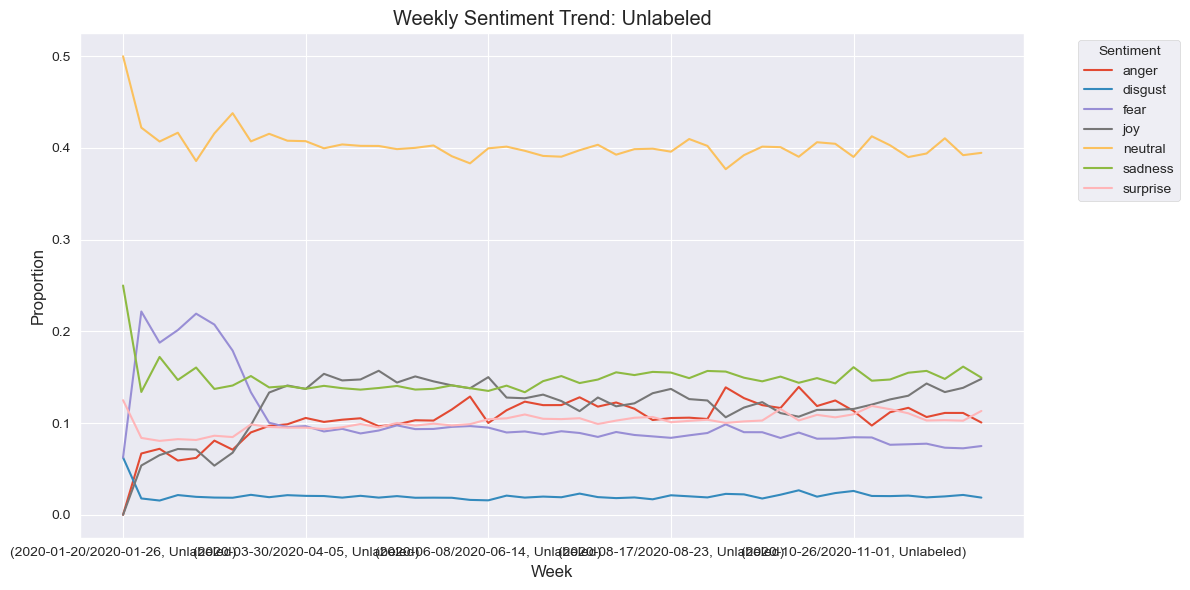

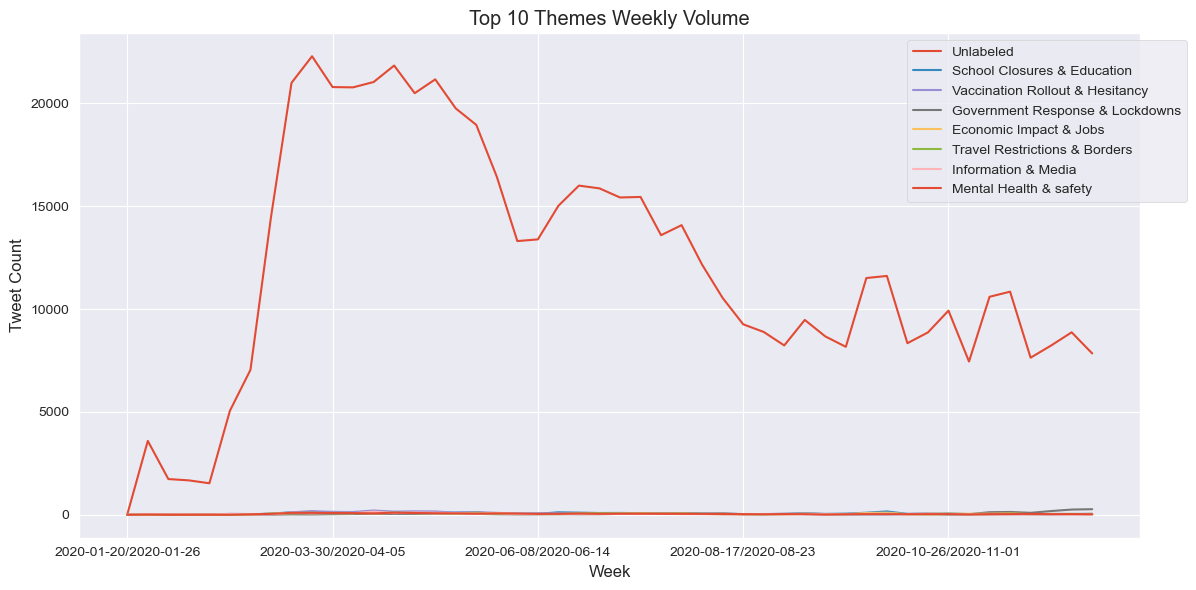

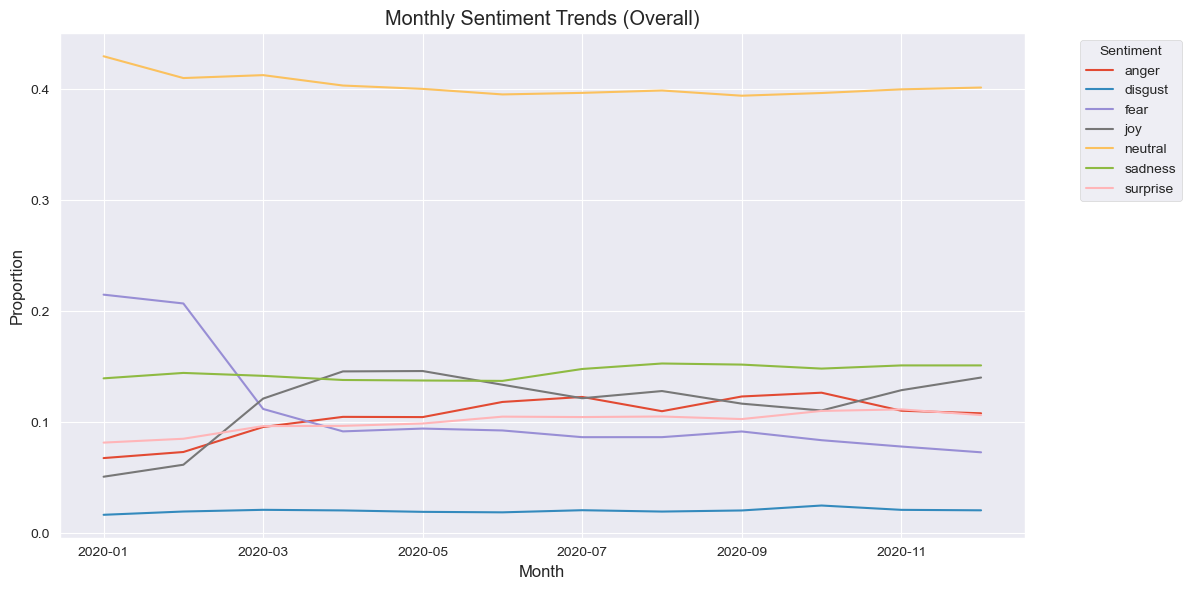

In [202]:
import matplotlib.pyplot as plt

# 1) Weekly Theme Sentiment Trend for One Theme
theme_to_plot = df["theme"].value_counts().index[0]  # e.g., top theme
subset = weekly_theme_sentiment_prop.loc[(slice(None), theme_to_plot), :]

plt.figure(figsize=(12,6))
subset.plot(kind="line", ax=plt.gca(), title=f"Weekly Sentiment Trend: {theme_to_plot}")
plt.xlabel("Week")
plt.ylabel("Proportion")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# 2) Weekly Volume Trend for Top Topics

weekly_theme_volume_top10.plot(figsize=(12,6), title="Top 10 Themes Weekly Volume")
plt.ylabel("Tweet Count")
plt.xlabel("Week")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# 3) Monthly Overall Sentiment Trend
monthly_sentiment_prop.plot(figsize=(12,6), title="Monthly Sentiment Trends (Overall)")
plt.ylabel("Proportion")
plt.xlabel("Month")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [230]:
emotions = [c for c in weekly_theme_sentiment.columns if c not in ["week", "theme"]]
print("Available emotions:", emotions)

Available emotions: ['sentiment', 'count']


In [240]:


# Add week column (ISO week as string)
df["month"] = df["date"].dt.to_period("m").astype(str)

# ============================
# STEP 1: Weekly Theme Frequency
# ============================
monthly_theme_freq = (
    df.groupby(["month", "theme"])
      .size()
      .rename("tweet_count")
      .reset_index()
)

# Pivot to wide format: each theme is a column
monthly_theme_matrix = monthly_theme_freq.pivot(
    index="month", columns="theme", values="tweet_count"
).fillna(0)

# Ensure weeks are sorted chronologically
monthly_theme_matrix = monthly_theme_matrix.sort_index()

print("✅ monthly theme frequency matrix shape:", monthly_theme_matrix.shape)
monthly_theme_matrix.head()

✅ monthly theme frequency matrix shape: (12, 8)


theme,Economic Impact & Jobs,Government Response & Lockdowns,Information & Media,Mental Health & safety,School Closures & Education,Travel Restrictions & Borders,Unlabeled,Vaccination Rollout & Hesitancy
month,,,,,,,,
2020-01,7,3,18,11,6,6,2729,18
2020-02,28,24,98,14,32,10,10433,84
2020-03,258,68,244,277,366,269,70810,410
2020-04,366,177,440,376,540,379,91388,710
2020-05,321,204,369,304,393,335,84246,557


In [287]:
import pandas as pd
import matplotlib.pyplot as plt

# ================================
# STEP 0: Load or use your topic DataFrame
# ================================
# If you've already created topic_summary.csv earlier:
#Topic Summary
# Group by topic to get frequency

topic_summary = (
    df.groupby(["topic", "topic_name", "topic_keywords"])
      .size()
      .rename("tweet_count")
      .reset_index()
      .sort_values("tweet_count", ascending=False)
)

topic_df = topic_summary

 #Ensure column names are consistent
topic_df.columns = topic_df.columns.str.strip().str.lower()

# If your columns look like: ['topic', 'topic_name', 'topic_keywords', 'tweet_count', ...]
# We'll use 'topic_name' and 'tweet_count' for plotting
if 'topic_name' not in topic_df.columns or 'tweet_count' not in topic_df.columns:
    raise ValueError("❌ Expected columns 'topic_name' and 'tweet_count' in topic_summary.csv")

# ================================
# STEP 1: Get Top 10 Topics by Tweet Count
# ================================
top_topics = (
    topic_df
    .sort_values("tweet_count", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

print("✅ Top 10 topics:")
display(top_topics[["topic_name", "tweet_count"]])

✅ Top 10 topics:


,topic_name,tweet_count
0,0_dude_idiot_asshole_course did,3229
1,1_nigeria_africa_lagos_nigerians,2884
2,2_vaccine_vaccines_vaccine vaccine_vaccination,2422
3,3_hes going_golf_hes doing_hes gonna,2398
4,4_shes_woman_karen_girl,2090
5,5_china_chinese_communist_chinas,2062
6,6_help self_unprecedented situation_video siso...,2060
7,7_china_chinese_chinas_communist,2054
8,8_ampm_webinar_register_youth,2013
9,9_vaccine_vaccines_vaccination_vaccinated,1921


In [307]:
def evaluate_topic_analysis_from_df(df):
    """
    Comprehensive evaluation of topic analysis from enriched DataFrame
    """
    print("📊 TOPIC ANALYSIS EVALUATION FROM ENRICHED DATAFRAME")
    print("=" * 70)
    
    # Basic Dataset Overview
    print("\n🔍 DATASET OVERVIEW:")
    print(f"   • Total documents: {len(df):,}")
    print(f"   • Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"   • Unique places: {df['place'].nunique()}")
    print(f"   • Unique sentiments: {df['sentiment'].nunique()}")
    
    # Topic Analysis
    print("\n🎯 TOPIC ANALYSIS:")
    print(f"   • Unique topics: {df['topic'].nunique()}")
    print(f"   • Topics with names: {df['topic_name'].nunique()}")
    print(f"   • Broad themes: {df['theme_broad'].nunique()}")
    print(f"   • Specific themes: {df['theme_specific'].nunique()}")
    
    # Topic Distribution
    print("\n📈 TOPIC DISTRIBUTION:")
    topic_dist = df['topic'].value_counts().sort_index()
    outlier_count = topic_dist.get(-1, 0)
    valid_topics = topic_dist[topic_dist.index != -1]
    
    print(f"   • Outlier documents (topic -1): {outlier_count} ({outlier_count/len(df)*100:.1f}%)")
    print(f"   • Valid topics: {len(valid_topics)}")
    print(f"   • Average topic size: {valid_topics.mean():.1f}")
    print(f"   • Topic size range: {valid_topics.min()} - {valid_topics.max()}")
    
    # Sentiment Analysis by Topic
    print("\n😊 SENTIMENT-TOPIC INTEGRATION:")
    sentiment_by_topic = pd.crosstab(df['theme_broad'], df['sentiment'], normalize='index') * 100
    print(f"   • Sentiment analysis integrated across {len(sentiment_by_topic)} broad themes")
    
    # Theme Quality Assessment
    print("\n🏷️  THEME QUALITY ASSESSMENT:")
    print(f"   • Theme coverage: {(df['theme_full'] != 'Uncategorized/Noise').sum() / len(df) * 100:.1f}%")
    
    # Check for theme diversity
    theme_dist = df['theme_full'].value_counts()
    print(f"   • Most common theme: '{theme_dist.index[0]}' ({theme_dist.iloc[0]} docs, {theme_dist.iloc[0]/len(df)*100:.1f}%)")
    print(f"   • Themes with >10 documents: {len(theme_dist[theme_dist > 10])}")
    
    # Data Completeness
    print("\n✅ DATA COMPLETENESS:")
    completeness = {}
    for col in ['topic', 'topic_name', 'topic_keywords', 'theme_broad', 'theme_specific', 'theme_full']:
        if col in df.columns:
            complete_pct = (1 - df[col].isnull().sum() / len(df)) * 100
            completeness[col] = complete_pct
            print(f"   • {col}: {complete_pct:.1f}% complete")
    
    return topic_dist, sentiment_by_topic, theme_dist

# Run the evaluation
topic_dist, sentiment_by_topic, theme_dist = evaluate_topic_analysis_from_df(df)

📊 TOPIC ANALYSIS EVALUATION FROM ENRICHED DATAFRAME

🔍 DATASET OVERVIEW:
   • Total documents: 595,929
   • Date range: 2020-01-22 00:00:00 to 2020-12-20 00:00:00
   • Unique places: 31588
   • Unique sentiments: 7

🎯 TOPIC ANALYSIS:
   • Unique topics: 951
   • Topics with names: 951
   • Broad themes: 7
   • Specific themes: 544

📈 TOPIC DISTRIBUTION:
   • Outlier documents (topic -1): 0 (0.0%)
   • Valid topics: 951
   • Average topic size: 626.6
   • Topic size range: 103 - 3229

😊 SENTIMENT-TOPIC INTEGRATION:
   • Sentiment analysis integrated across 7 broad themes

🏷️  THEME QUALITY ASSESSMENT:
   • Theme coverage: 100.0%
   • Most common theme: 'Other: Merged: Merged: Merged: Merged: Merged: Merged: Merged: Merged: Merged: Merged: Merged: Makes Sense & Sums & Confused' (4874 docs, 0.8%)
   • Themes with >10 documents: 578

✅ DATA COMPLETENESS:
   • topic: 100.0% complete
   • topic_name: 100.0% complete
   • topic_keywords: 100.0% complete
   • theme_broad: 100.0% complete
   • 


📊 CREATING TOPIC ANALYSIS VISUALIZATIONS


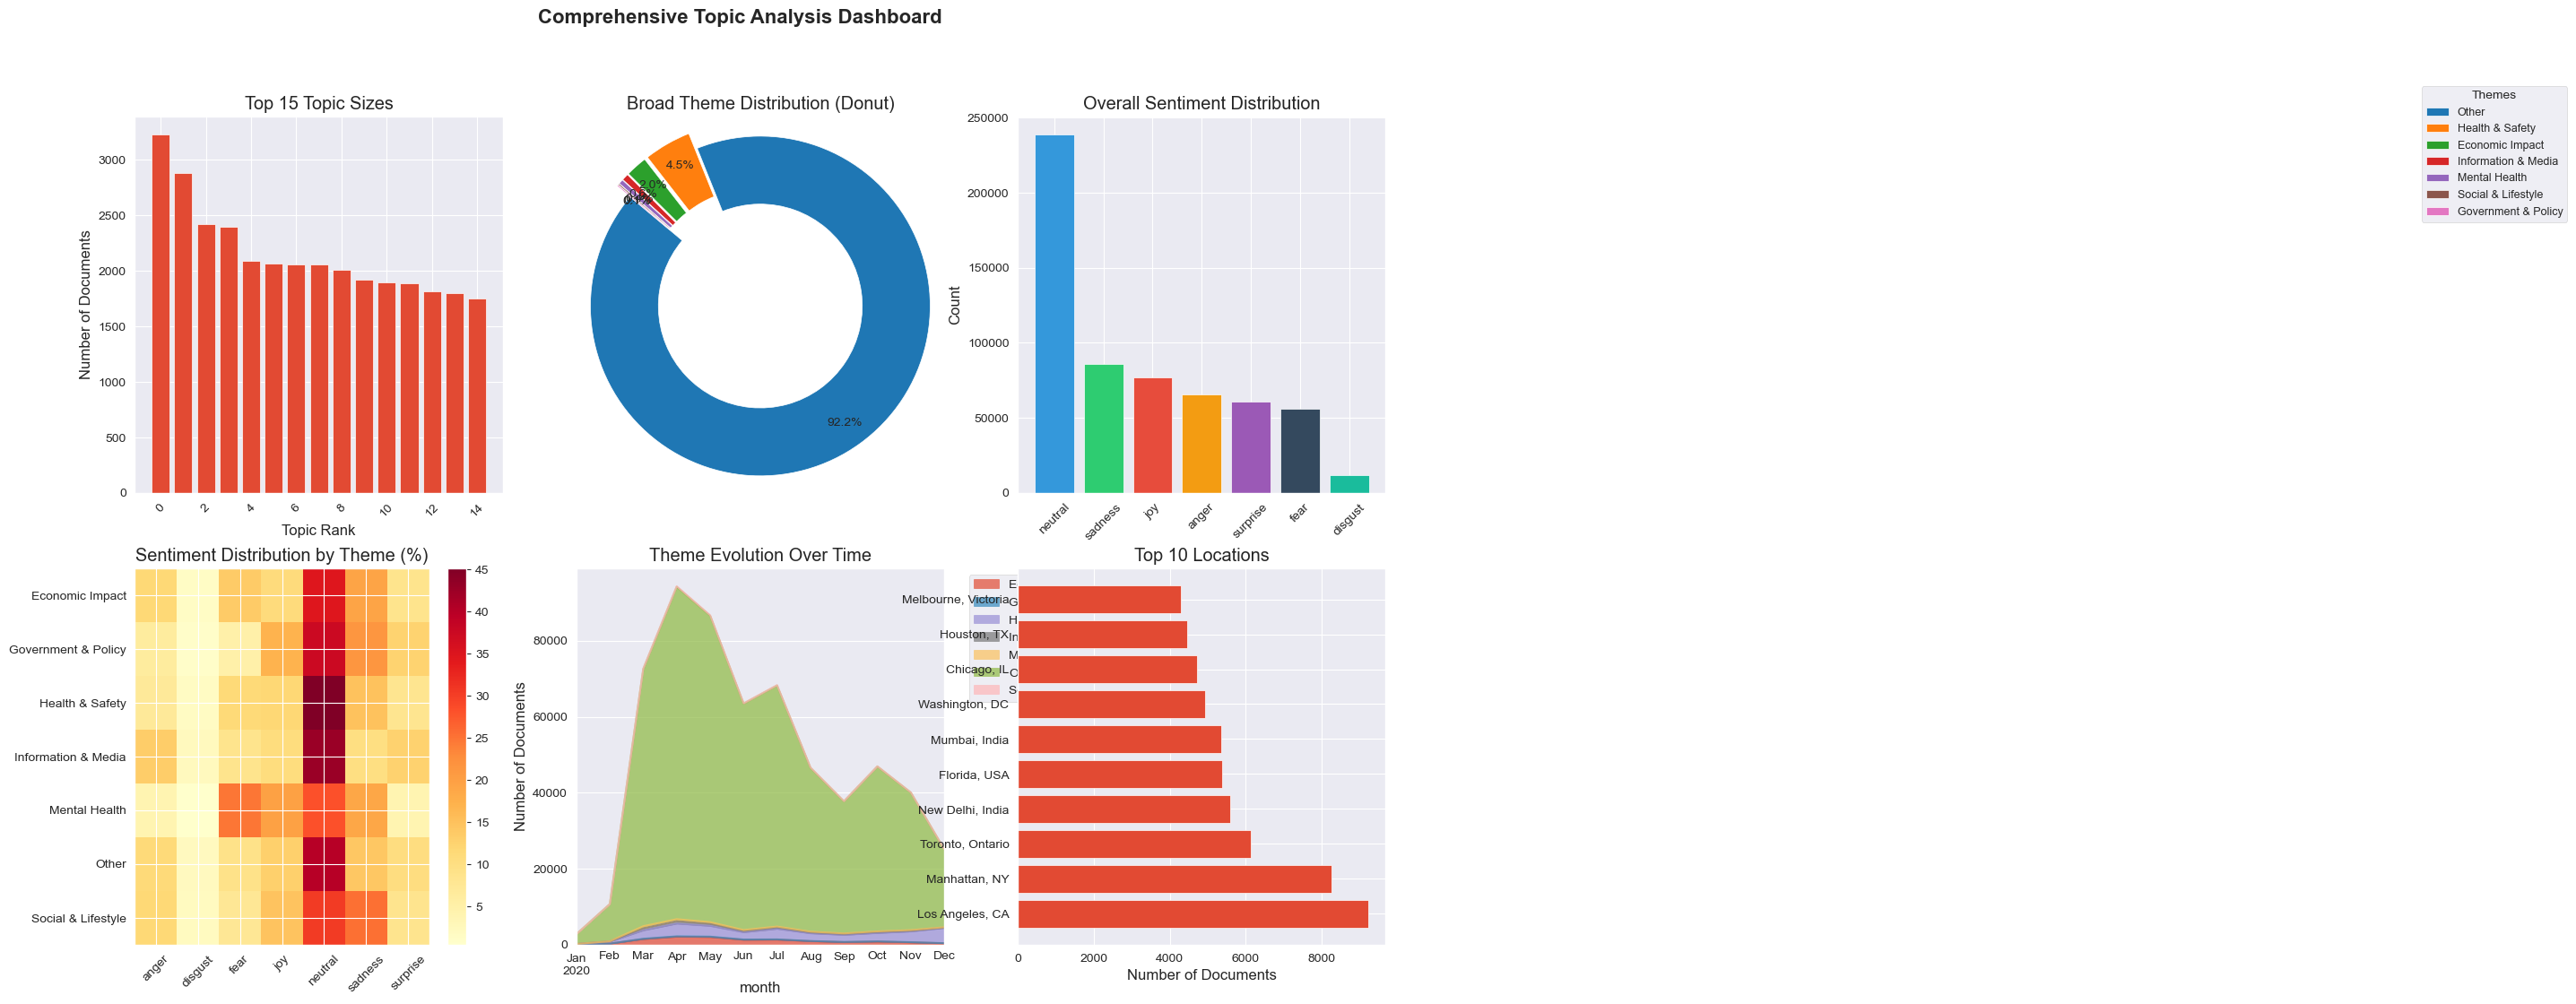

In [395]:
def visualize_topic_analysis(df):
    """
    Create comprehensive visualizations for the topic analysis
    """
    print("\n📊 CREATING TOPIC ANALYSIS VISUALIZATIONS")
    print("=" * 50)
    
    fig, axes = plt.subplots(2, 3, figsize=(30, 2))
    fig.suptitle('Comprehensive Topic Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Topic Distribution
    valid_topics = df[df['topic'] != -1]['topic'].value_counts().head(15)
    axes[0, 0].bar(range(len(valid_topics)), valid_topics.values)
    axes[0, 0].set_title('Top 15 Topic Sizes')
    axes[0, 0].set_xlabel('Topic Rank')
    axes[0, 0].set_ylabel('Number of Documents')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Theme Distribution
    top_themes = df['theme_broad'].value_counts().head(10)

# Create an explode list (pull out each slice slightly)
    explode = [0.05] * len(top_themes)

# Plot the pie chart
    axes[0, 1].pie(
    top_themes.values,
    labels=top_themes.index,
    autopct='%1.1f%%',
    startangle=140,             # rotate the start angle for better spacing
    explode=explode,            # pull slices apart
    textprops={'fontsize': 9},  # reduce font size for readability
    labeldistance=1.1,          # move labels slightly outward
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}  # optional: cleaner edges
)

    axes[0, 1].set_title('Broad Theme Distribution')


    # 3. Sentiment Distribution
    sentiment_counts = df['sentiment'].value_counts()
    axes[0, 2].bar(sentiment_counts.index, sentiment_counts.values, 
                   color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#34495e', '#1abc9c'])
    axes[0, 2].set_title('Overall Sentiment Distribution')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].tick_params(axis='x', rotation=45)
    
    # 4. Sentiment by Broad Theme (Heatmap)
    sentiment_theme = pd.crosstab(df['theme_broad'], df['sentiment'], normalize='index') * 100
    im = axes[1, 0].imshow(sentiment_theme.values, cmap='YlOrRd', aspect='auto')
    axes[1, 0].set_title('Sentiment Distribution by Theme (%)')
    axes[1, 0].set_xticks(range(len(sentiment_theme.columns)))
    axes[1, 0].set_xticklabels(sentiment_theme.columns, rotation=45)
    axes[1, 0].set_yticks(range(len(sentiment_theme.index)))
    axes[1, 0].set_yticklabels(sentiment_theme.index)
    plt.colorbar(im, ax=axes[1, 0])
    
    # 5. Temporal Distribution of Topics
    if 'date' in df.columns:
        df['month'] = pd.to_datetime(df['date']).dt.to_period('M')
        monthly_topics = df.groupby('month')['theme_broad'].value_counts().unstack().fillna(0)
        monthly_topics.plot(kind='area', ax=axes[1, 1], alpha=0.7)
        axes[1, 1].set_title('Theme Evolution Over Time')
        axes[1, 1].set_ylabel('Number of Documents')
        axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 6. Geographical Distribution (if place data is meaningful)
    if 'place' in df.columns and df['place'].nunique() > 1:
        place_dist = df['place'].value_counts().head(10)
        axes[1, 2].barh(range(len(place_dist)), place_dist.values)
        axes[1, 2].set_yticks(range(len(place_dist)))
        axes[1, 2].set_yticklabels(place_dist.index)
        axes[1, 2].set_title('Top 10 Locations')
        axes[1, 2].set_xlabel('Number of Documents')
    
    plt.tight_layout()
    plt.show()

# Create visualizations
visualize_topic_analysis(df)


📊 CREATING TOPIC ANALYSIS VISUALIZATIONS


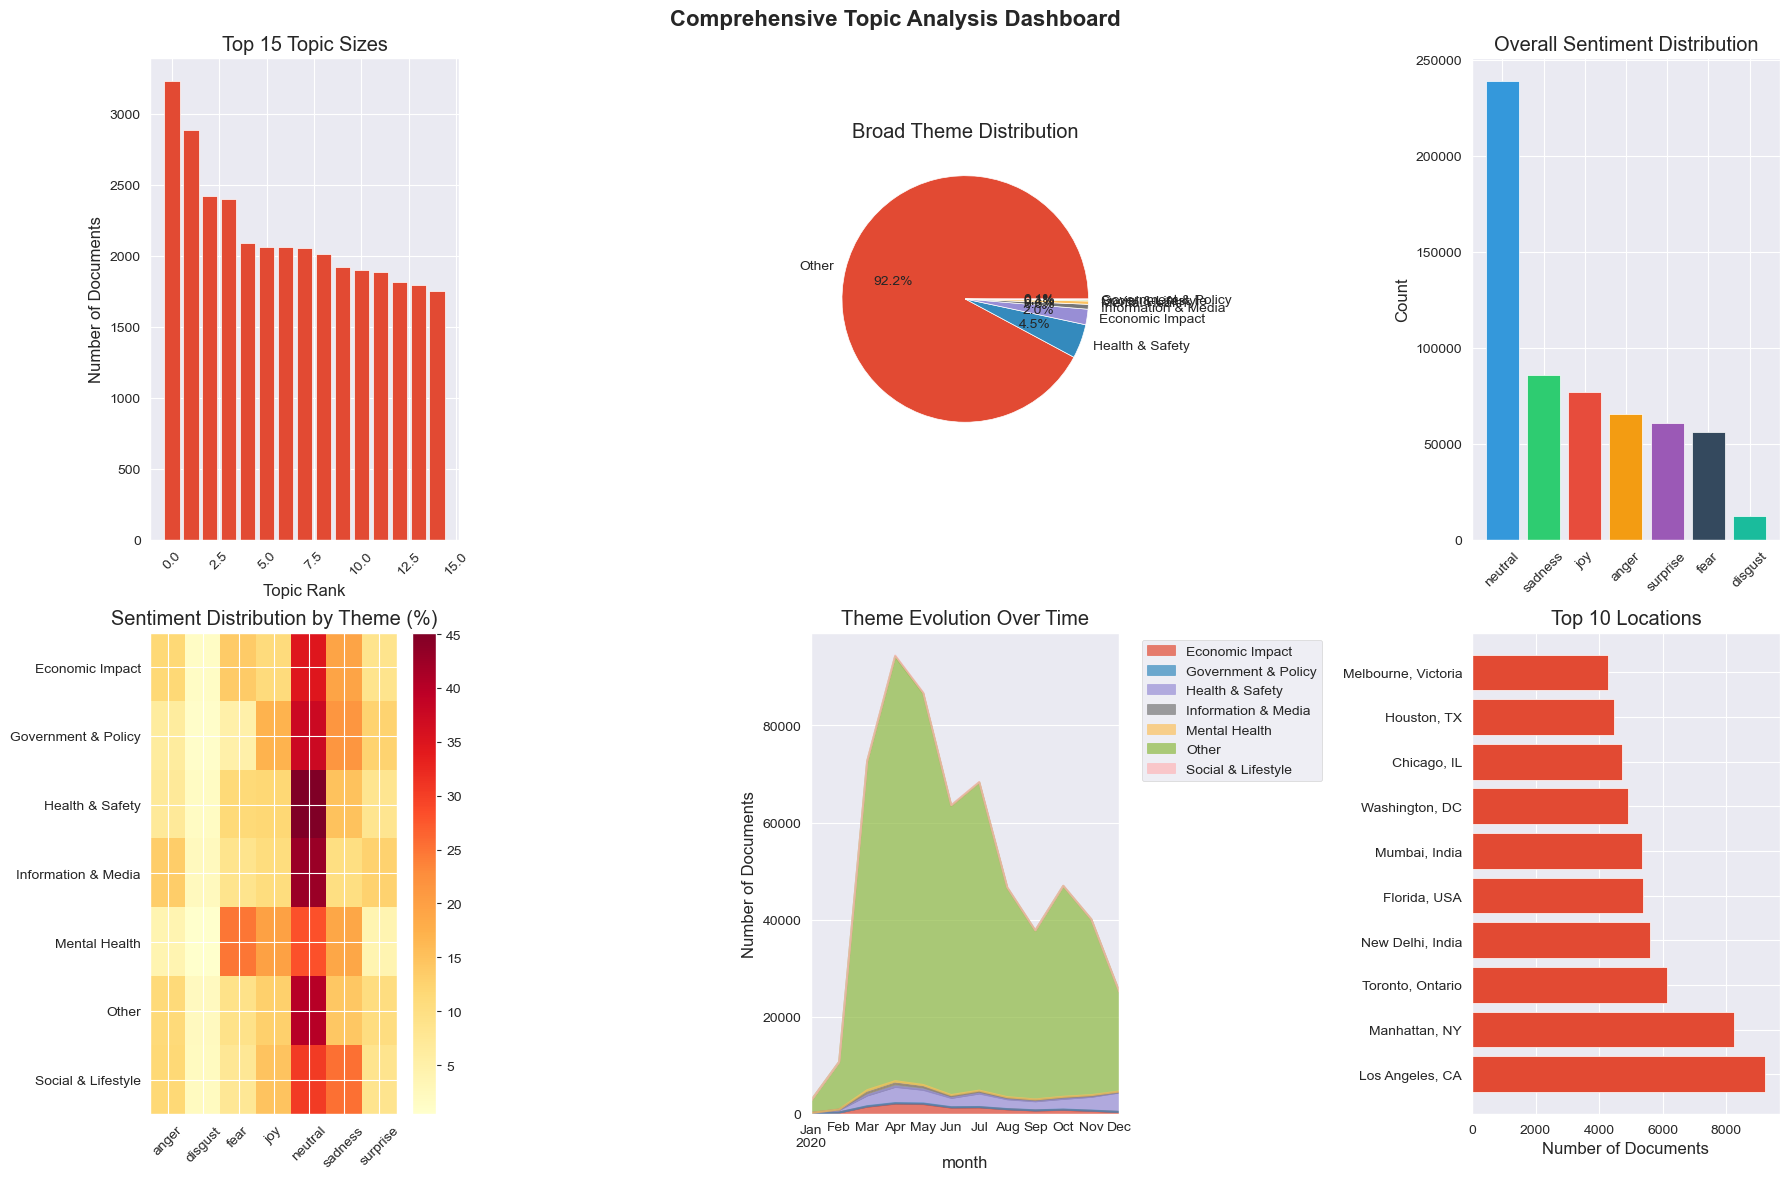

In [311]:
def detailed_topic_quality_assessment(df):
    """
    Detailed assessment of topic and theme quality
    """
    print("\n🔬 DETAILED TOPIC QUALITY ASSESSMENT")
    print("=" * 60)
    
    # 1. Topic Coherence Assessment
    print("\n🎯 TOPIC COHERENCE:")
    
    # Check if topic_keywords are meaningful
    if 'topic_keywords' in df.columns:
        sample_keywords = df['topic_keywords'].dropna().unique()[:5]
        print("   Sample topic keywords:")
        for i, keywords in enumerate(sample_keywords, 1):
            print(f"     {i}. {keywords}")
    
    # 2. Theme Hierarchy Quality
    print("\n🏗️  THEME HIERARCHY QUALITY:")
    theme_breakdown = df.groupby('theme_broad')['theme_specific'].nunique()
    print("   Themes per broad category:")
    for broad_theme, count in theme_breakdown.items():
        print(f"     • {broad_theme}: {count} specific themes")
    
    # 3. Sentiment-Topic Relationships
    print("\n😊 SENTIMENT-TOPIC RELATIONSHIPS:")
    
    # Find topics with strong emotional signatures
    emotion_strength = {}
    for theme in df['theme_broad'].unique():
        theme_data = df[df['theme_broad'] == theme]
        sentiment_dist = theme_data['sentiment'].value_counts(normalize=True)
        dominant_sentiment = sentiment_dist.index[0]
        strength = sentiment_dist.iloc[0]
        emotion_strength[theme] = (dominant_sentiment, strength)
        
        if strength > 0.4:  # Strong emotional signature
            print(f"     ✅ {theme}: Strong {dominant_sentiment} bias ({strength:.1%})")
        elif strength > 0.3:
            print(f"     📊 {theme}: Moderate {dominant_sentiment} bias ({strength:.1%})")
        else:
            print(f"     🔄 {theme}: Mixed emotions (dominant: {dominant_sentiment} {strength:.1%})")
    
    # 4. Data Quality Metrics
    print("\n📊 DATA QUALITY METRICS:")
    
    # Check for data consistency
    if 'topic_words' in df.columns and 'topic_keywords' in df.columns:
        consistency_check = df[['topic_words', 'topic_keywords']].notna().all(axis=1).mean() * 100
        print(f"   • Topic data consistency: {consistency_check:.1f}%")
    
    # Theme naming quality
    if 'theme_specific' in df.columns:
        generic_names = df['theme_specific'].str.contains('topic|mixed|other', case=False, na=False).sum()
        print(f"   • Generic theme names: {generic_names} ({generic_names/len(df)*100:.1f}%)")
    
    return emotion_strength

# Run detailed assessment
emotion_strength = detailed_topic_quality_assessment(df)


🔬 DETAILED TOPIC QUALITY ASSESSMENT

🎯 TOPIC COHERENCE:
   Sample topic keywords:
     1. nigeria, africa, lagos, nigerians, south africa
     2. china, korea, chinese, south korea, taiwan
     3. fda, drug, pharmacies, pharma, big pharma
     4. rent, small businesses, employees, sales, panic buying
     5. china, chinese, hong, chinas, hong kong

🏗️  THEME HIERARCHY QUALITY:
   Themes per broad category:
     • Economic Impact: 14 specific themes
     • Government & Policy: 1 specific themes
     • Health & Safety: 27 specific themes
     • Information & Media: 6 specific themes
     • Mental Health: 6 specific themes
     • Other: 522 specific themes
     • Social & Lifestyle: 2 specific themes

😊 SENTIMENT-TOPIC RELATIONSHIPS:
     ✅ Other: Strong neutral bias (40.0%)
     ✅ Information & Media: Strong neutral bias (42.7%)
     ✅ Health & Safety: Strong neutral bias (45.1%)
     📊 Economic Impact: Moderate neutral bias (34.7%)
     📊 Government & Policy: Moderate neutral bias (37.

In [313]:
def generate_insights_and_recommendations(df):
    """
    Generate actionable insights and recommendations
    """
    print("\n💡 ACTIONABLE INSIGHTS & RECOMMENDATIONS")
    print("=" * 60)
    
    insights = []
    
    # 1. Crisis Detection
    high_negative_themes = df.groupby('theme_broad').apply(
        lambda x: (x['sentiment'].isin(['anger', 'fear', 'disgust'])).mean()
    ).nlargest(3)
    
    if len(high_negative_themes) > 0:
        print("\n🚨 CRISIS DETECTION - High Negative Emotion Themes:")
        for theme, neg_pct in high_negative_themes.items():
            print(f"   • {theme}: {neg_pct:.1%} negative emotions")
            insights.append(f"Address concerns in {theme} ({(neg_pct*100):.1f}% negative)")
    
    # 2. Opportunity Identification
    high_positive_themes = df.groupby('theme_broad').apply(
        lambda x: (x['sentiment'] == 'joy').mean()
    ).nlargest(3)
    
    if len(high_positive_themes) > 0:
        print("\n💡 OPPORTUNITY IDENTIFICATION - High Positive Emotion Themes:")
        for theme, pos_pct in high_positive_themes.items():
            print(f"   • {theme}: {pos_pct:.1%} joy")
            insights.append(f"Leverage positive sentiment in {theme}")
    
    # 3. Temporal Insights (if date available)
    if 'date' in df.columns:
        df['date_dt'] = pd.to_datetime(df['date'])
        recent_cutoff = df['date_dt'].max() - pd.Timedelta(days=30)
        recent_data = df[df['date_dt'] > recent_cutoff]
        
        if len(recent_data) > 10:  # Enough recent data
            recent_sentiment = recent_data['sentiment'].value_counts(normalize=True)
            overall_sentiment = df['sentiment'].value_counts(normalize=True)
            
            # Check for sentiment shifts
            for sentiment in ['joy', 'fear', 'anger']:
                if sentiment in recent_sentiment and sentiment in overall_sentiment:
                    change = recent_sentiment[sentiment] - overall_sentiment[sentiment]
                    if abs(change) > 0.05:
                        direction = "increased" if change > 0 else "decreased"
                        print(f"\n📅 RECENT TREND: {sentiment} {direction} by {abs(change):.1%}")
                        insights.append(f"Recent {direction} in {sentiment} sentiment")
    
    # 4. Geographical Insights (if place data is meaningful)
    if 'place' in df.columns and df['place'].nunique() > 5:
        place_sentiment = df.groupby('place')['sentiment'].apply(
            lambda x: (x == 'joy').mean()
        ).nlargest(3)
        
        print(f"\n🌍 GEOGRAPHICAL INSIGHTS - Most Positive Locations:")
        for place, joy_pct in place_sentiment.items():
            print(f"   • {place}: {joy_pct:.1%} joy")
    
    # 5. Recommendations
    print(f"\n🎯 KEY RECOMMENDATIONS:")
    for i, insight in enumerate(insights[:5], 1):
        print(f"   {i}. {insight}")
    
    # Additional recommendations based on data quality
    outlier_pct = (df['topic'] == -1).mean() * 100
    if outlier_pct > 20:
        print(f"   ⚠️  Reduce outlier rate (currently {outlier_pct:.1f}%) through parameter tuning")
    
    theme_coverage = (df['theme_full'] != 'Uncategorized/Noise').mean() * 100
    if theme_coverage < 80:
        print(f"   ⚠️  Improve theme coverage (currently {theme_coverage:.1f}%)")

# Generate insights
generate_insights_and_recommendations(df)


💡 ACTIONABLE INSIGHTS & RECOMMENDATIONS

🚨 CRISIS DETECTION - High Negative Emotion Themes:
   • Mental Health: 29.2% negative emotions
   • Economic Impact: 26.7% negative emotions
   • Information & Media: 24.3% negative emotions

💡 OPPORTUNITY IDENTIFICATION - High Positive Emotion Themes:
   • Mental Health: 19.8% joy
   • Government & Policy: 17.0% joy
   • Social & Lifestyle: 14.7% joy

🌍 GEOGRAPHICAL INSIGHTS - Most Positive Locations:
   • +82 Pluseightwo: 100.0% joy
   • 10 Damansara Heights: 100.0% joy
   • 200 Degrees Coffee: 100.0% joy

🎯 KEY RECOMMENDATIONS:
   1. Address concerns in Mental Health (29.2% negative)
   2. Address concerns in Economic Impact (26.7% negative)
   3. Address concerns in Information & Media (24.3% negative)
   4. Leverage positive sentiment in Mental Health
   5. Leverage positive sentiment in Government & Policy


In [315]:
def final_analysis_summary(df):
    """
    Provide final summary of the topic analysis
    """
    print("\n⭐ FINAL TOPIC ANALYSIS SUMMARY")
    print("=" * 50)
    
    # Key metrics
    total_docs = len(df)
    valid_topics = df[df['topic'] != -1]['topic'].nunique()
    theme_coverage = (df['theme_full'] != 'Uncategorized/Noise').mean() * 100
    sentiment_categories = df['sentiment'].nunique()
    
    print(f"📊 ANALYSIS SCALE:")
    print(f"   • Documents analyzed: {total_docs:,}")
    print(f"   • Topics identified: {valid_topics}")
    print(f"   • Sentiment categories: {sentiment_categories}")
    print(f"   • Theme coverage: {theme_coverage:.1f}%")
    
    # Quality assessment
    print(f"\n✅ QUALITY ASSESSMENT:")
    
    # Topic quality
    avg_topic_size = df[df['topic'] != -1]['topic'].value_counts().mean()
    if avg_topic_size > 50:
        print("   • Topic sizes: ✅ Good")
    elif avg_topic_size > 20:
        print("   • Topic sizes: ⚠️ Moderate")
    else:
        print("   • Topic sizes: ❌ Needs improvement")
    
    # Sentiment distribution
    sentiment_balance = df['sentiment'].value_counts(normalize=True).std()
    if sentiment_balance < 0.15:
        print("   • Sentiment distribution: ✅ Balanced")
    elif sentiment_balance < 0.25:
        print("   • Sentiment distribution: ⚠️ Somewhat skewed")
    else:
        print("   • Sentiment distribution: ❌ Highly skewed")
    
    # Data integration
    complete_cols = ['topic', 'sentiment', 'theme_full']
    completeness = df[complete_cols].notna().all(axis=1).mean() * 100
    if completeness > 95:
        print("   • Data integration: ✅ Excellent")
    elif completeness > 85:
        print("   • Data integration: ⚠️ Good")
    else:
        print("   • Data integration: ❌ Needs attention")
    
    print(f"\n🎯 READY FOR: Sentiment analysis, Trend monitoring, Crisis detection")
    print(f"🚀 NEXT STEPS: Temporal analysis, Geographical mapping, Intervention planning")

# Final summary
final_analysis_summary(df)


⭐ FINAL TOPIC ANALYSIS SUMMARY
📊 ANALYSIS SCALE:
   • Documents analyzed: 595,929
   • Topics identified: 951
   • Sentiment categories: 7
   • Theme coverage: 100.0%

✅ QUALITY ASSESSMENT:
   • Topic sizes: ✅ Good
   • Sentiment distribution: ✅ Balanced
   • Data integration: ✅ Excellent

🎯 READY FOR: Sentiment analysis, Trend monitoring, Crisis detection
🚀 NEXT STEPS: Temporal analysis, Geographical mapping, Intervention planning


In [317]:
def comprehensive_temporal_analysis(df):
    """
    Deep temporal analysis of topic and sentiment evolution
    """
    print("📅 COMPREHENSIVE TEMPORAL ANALYSIS")
    print("=" * 60)
    
    # Ensure date is datetime
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.to_period('M')
    df['week'] = df['date'].dt.to_period('W')
    
    # 1. Monthly Topic Evolution
    print("\n📈 TOPIC EVOLUTION OVER TIME")
    
    # Monthly theme trends
    monthly_themes = df.groupby(['month', 'theme_broad']).size().unstack(fill_value=0)
    
    # Calculate growth rates
    theme_growth = monthly_themes.pct_change().mean() * 100
    emerging_themes = theme_growth.nlargest(3)
    declining_themes = theme_growth.nsmallest(3)
    
    print("🚀 Emerging Themes (Highest Growth):")
    for theme, growth in emerging_themes.items():
        print(f"   • {theme}: +{growth:.1f}% monthly growth")
    
    print("\n📉 Declining Themes:")
    for theme, growth in declining_themes.items():
        print(f"   • {theme}: {growth:.1f}% monthly growth")
    
    # 2. Sentiment Evolution
    print("\n😊 SENTIMENT EVOLUTION ANALYSIS")
    
    monthly_sentiment = pd.crosstab(df['month'], df['sentiment'], normalize='index') * 100
    
    # Identify sentiment shifts
    sentiment_trends = {}
    for sentiment in ['joy', 'fear', 'anger']:
        if sentiment in monthly_sentiment.columns:
            series = monthly_sentiment[sentiment].dropna()
            if len(series) > 1:
                slope = np.polyfit(range(len(series)), series.values, 1)[0]
                sentiment_trends[sentiment] = slope
    
    print("📊 Sentiment Trends (Monthly Change):")
    for sentiment, trend in sorted(sentiment_trends.items(), key=lambda x: abs(x[1]), reverse=True)[:3]:
        direction = "increasing" if trend > 0 else "decreasing"
        print(f"   • {sentiment}: {direction} by {abs(trend):.2f}% per month")
    
    # 3. Critical Period Identification
    print("\n🔄 CRITICAL PERIOD IDENTIFICATION")
    
    # Find periods with unusual sentiment patterns
    monthly_negative = df.groupby('month')['sentiment'].apply(
        lambda x: (x.isin(['anger', 'fear', 'disgust'])).mean() * 100
    )
    
    # Identify peaks in negative sentiment
    negative_peaks = monthly_negative.nlargest(3)
    print("🚨 Peak Negative Sentiment Periods:")
    for period, pct in negative_peaks.items():
        # Get dominant themes during these periods
        period_data = df[df['month'] == period]
        dominant_theme = period_data['theme_broad'].mode()[0] if len(period_data) > 0 else "Unknown"
        print(f"   • {period}: {pct:.1f}% negative (Dominant: {dominant_theme})")
    
    return monthly_themes, monthly_sentiment

# Run temporal analysis
monthly_themes, monthly_sentiment = comprehensive_temporal_analysis(df)

📅 COMPREHENSIVE TEMPORAL ANALYSIS

📈 TOPIC EVOLUTION OVER TIME
🚀 Emerging Themes (Highest Growth):
   • Mental Health: +214.5% monthly growth
   • Social & Lifestyle: +199.1% monthly growth
   • Government & Policy: +86.9% monthly growth

📉 Declining Themes:
   • Health & Safety: 66.8% monthly growth
   • Information & Media: 68.1% monthly growth
   • Other: 71.4% monthly growth

😊 SENTIMENT EVOLUTION ANALYSIS
📊 Sentiment Trends (Monthly Change):
   • fear: decreasing by 1.03% per month
   • joy: increasing by 0.45% per month
   • anger: increasing by 0.39% per month

🔄 CRITICAL PERIOD IDENTIFICATION
🚨 Peak Negative Sentiment Periods:
   • 2020-02: 29.9% negative (Dominant: Other)
   • 2020-01: 29.9% negative (Dominant: Other)
   • 2020-10: 23.5% negative (Dominant: Other)


In [319]:
def geographical_mapping_analysis(df):
    """
    Geographical analysis and mapping of topics and sentiments
    """
    print("\n🌍 GEOGRAPHICAL MAPPING ANALYSIS")
    print("=" * 60)
    
    # Clean and standardize location data
    df['place_clean'] = df['place'].str.upper().str.strip()
    
    # 1. Regional Sentiment Analysis
    print("\n😊 REGIONAL SENTIMENT PATTERNS")
    
    regional_sentiment = df.groupby('place_clean').agg({
        'sentiment': lambda x: (x == 'joy').mean() * 100,  # Joy percentage
        'text': 'count'  # Tweet count
    }).rename(columns={'sentiment': 'joy_pct', 'text': 'tweet_count'})
    
    # Filter for meaningful regions (enough data)
    meaningful_regions = regional_sentiment[regional_sentiment['tweet_count'] > 10]
    
    print("📍 Regional Joy Sentiment Ranking:")
    top_joy_regions = meaningful_regions.nlargest(5, 'joy_pct')
    for region, (joy_pct, count) in top_joy_regions.iterrows():
        print(f"   🥇 {region}: {joy_pct:.1f}% joy ({count} tweets)")
    
    print("\n😢 Lowest Joy Regions:")
    low_joy_regions = meaningful_regions.nsmallest(3, 'joy_pct')
    for region, (joy_pct, count) in low_joy_regions.iterrows():
        print(f"   ⚠️  {region}: {joy_pct:.1f}% joy ({count} tweets)")
    
    # 2. Topic Geographic Distribution
    print("\n🗺️  TOPIC GEOGRAPHIC DISTRIBUTION")
    
    regional_topics = pd.crosstab(df['place_clean'], df['theme_broad'], normalize='index') * 100
    
    # Find region-specific topic concentrations
    region_topic_specialization = {}
    for region in regional_topics.index:
        dominant_topic = regional_topics.loc[region].idxmax()
        dominance_pct = regional_topics.loc[region].max()
        if dominance_pct > 30:  # Significant concentration
            region_topic_specialization[region] = (dominant_topic, dominance_pct)
    
    print("🎯 Region-Specific Topic Concentrations:")
    for region, (topic, pct) in list(region_topic_specialization.items())[:5]:
        print(f"   • {region}: {topic} ({pct:.1f}%)")
    
    # 3. Crisis Region Identification
    print("\n🚨 CRISIS REGION IDENTIFICATION")
    
    crisis_regions = df.groupby('place_clean').apply(
        lambda x: pd.Series({
            'crisis_score': (x['sentiment'].isin(['fear', 'anger'])).mean() * 100,
            'total_tweets': len(x),
            'dominant_negative_theme': x[x['sentiment'].isin(['fear', 'anger'])]['theme_broad'].mode()[0] 
            if len(x[x['sentiment'].isin(['fear', 'anger'])]) > 0 else 'None'
        })
    )
    
    high_crisis_regions = crisis_regions[
        (crisis_regions['crisis_score'] > 40) & 
        (crisis_regions['total_tweets'] > 5)
    ].nlargest(5, 'crisis_score')
    
    if len(high_crisis_regions) > 0:
        print("⚠️  High Crisis Alert Regions:")
        for region, data in high_crisis_regions.iterrows():
            print(f"   • {region}: {data['crisis_score']:.1f}% fear/anger")
            print(f"     Main concern: {data['dominant_negative_theme']}")
    
    return regional_sentiment, regional_topics

# Run geographical analysis
regional_sentiment, regional_topics = geographical_mapping_analysis(df)


🌍 GEOGRAPHICAL MAPPING ANALYSIS

😊 REGIONAL SENTIMENT PATTERNS
📍 Regional Joy Sentiment Ranking:
   🥇 WEST END, VANCOUVER: 90.9% joy (11.0 tweets)
   🥇 MUKTSAR, INDIA: 81.8% joy (11.0 tweets)
   🥇 GOVERNMENT HOUSE: 75.0% joy (12.0 tweets)
   🥇 GOYANG-SI, REPUBLIC OF KOREA: 65.4% joy (26.0 tweets)
   🥇 BLACK MOUNTAINS GLIDING CLUB: 63.6% joy (11.0 tweets)

😢 Lowest Joy Regions:
   ⚠️  ABERDEEN, MD: 0.0% joy (19.0 tweets)
   ⚠️  ACQUAVIVA DELLE FONTI, PUGLIA: 0.0% joy (38.0 tweets)
   ⚠️  ACUÑA, COAHUILA DE ZARAGOZA: 0.0% joy (11.0 tweets)

🗺️  TOPIC GEOGRAPHIC DISTRIBUTION
🎯 Region-Specific Topic Concentrations:
   • 'CUE BARBECUE: Other (100.0%)
   • 'S-HERTOGENBOSCH, NEDERLAND: Other (100.0%)
   • +82 PLUSEIGHTWO: Other (100.0%)
   • 1 TO 3 COFFEE: Economic Impact (100.0%)
   • 10 DAMANSARA HEIGHTS: Other (100.0%)

🚨 CRISIS REGION IDENTIFICATION
⚠️  High Crisis Alert Regions:
   • SANTINIKETAN, INDIA: 100.0% fear/anger
     Main concern: Other
   • SECTOR 24: 100.0% fear/anger
     M

In [321]:
def intervention_planning_framework(df):
    """
    Develop targeted intervention strategies based on analysis
    """
    print("\n🎯 INTERVENTION PLANNING FRAMEWORK")
    print("=" * 60)
    
    interventions = []
    
    # 1. Crisis Communication Strategies
    print("\n📢 CRISIS COMMUNICATION STRATEGIES")
    
    # Identify high-negative themes that need attention
    negative_themes_analysis = df.groupby('theme_broad').apply(
        lambda x: pd.Series({
            'negative_pct': (x['sentiment'].isin(['fear', 'anger', 'disgust'])).mean() * 100,
            'total_docs': len(x),
            'dominant_negative': x[x['sentiment'].isin(['fear', 'anger', 'disgust'])]['sentiment'].mode()[0] 
            if len(x[x['sentiment'].isin(['fear', 'anger', 'disgust'])]) > 0 else 'None'
        })
    )
    
    high_negative_themes = negative_themes_analysis[
        negative_themes_analysis['negative_pct'] > 35
    ].sort_values('negative_pct', ascending=False)
    
    if len(high_negative_themes) > 0:
        print("🎯 Priority Themes for Crisis Communication:")
        for theme, data in high_negative_themes.iterrows():
            print(f"\n   🔴 {theme}:")
            print(f"      • Negative sentiment: {data['negative_pct']:.1f}%")
            print(f"      • Dominant emotion: {data['dominant_negative']}")
            print(f"      • Scale: {data['total_docs']} documents")
            
            # Recommended interventions
            if data['dominant_negative'] == 'fear':
                intervention = "Provide clear, factual information and reassurance"
            elif data['dominant_negative'] == 'anger':
                intervention = "Address concerns directly and show action being taken"
            else:  # disgust
                intervention = "Improve transparency and communication quality"
            
            print(f"      💡 Recommended: {intervention}")
            interventions.append({
                'theme': theme,
                'issue': f"High {data['dominant_negative']} sentiment",
                'intervention': intervention,
                'priority': 'HIGH'
            })
    
    # 2. Positive Reinforcement Opportunities
    print("\n💪 POSITIVE REINFORCEMENT OPPORTUNITIES")
    
    positive_themes = df.groupby('theme_broad').apply(
        lambda x: (x['sentiment'] == 'joy').mean() * 100
    ).nlargest(3)
    
    if len(positive_themes) > 0:
        print("🌟 Themes with Strong Positive Engagement:")
        for theme, joy_pct in positive_themes.items():
            print(f"   • {theme}: {joy_pct:.1f}% joy")
            interventions.append({
                'theme': theme,
                'issue': "Strong positive engagement",
                'intervention': "Amplify and replicate successful messaging",
                'priority': 'MEDIUM'
            })
    
    # 3. Regional Intervention Priorities
    print("\n📍 REGIONAL INTERVENTION PRIORITIES")
    
    if 'place_clean' in df.columns:
        regional_crisis = df.groupby('place_clean').apply(
            lambda x: (x['sentiment'].isin(['fear', 'anger'])).mean() * 100
        )
        
        high_crisis_regions = regional_crisis[regional_crisis > 40].sort_values(ascending=False)
        
        if len(high_crisis_regions) > 0:
            print("🚨 High-Priority Regions for Targeted Support:")
            for region, crisis_pct in high_crisis_regions.head(3).items():
                region_data = df[df['place_clean'] == region]
                main_concern = region_data[region_data['sentiment'].isin(['fear', 'anger'])]['theme_broad'].mode()
                main_concern = main_concern[0] if len(main_concern) > 0 else "Various"
                
                print(f"   • {region}: {crisis_pct:.1f}% fear/anger")
                print(f"     Main concern: {main_concern}")
                
                interventions.append({
                    'theme': f"Regional: {region}",
                    'issue': f"High crisis sentiment ({crisis_pct:.1f}%)",
                    'intervention': f"Targeted support for {main_concern} concerns",
                    'priority': 'HIGH'
                })
    
    # 4. Temporal Intervention Planning
    print("\n📅 TEMPORAL INTERVENTION SCHEDULING")
    
    if 'month' in df.columns:
        # Analyze seasonal patterns
        monthly_patterns = df.groupby('month')['sentiment'].apply(
            lambda x: (x.isin(['fear', 'anger'])).mean() * 100
        )
        
        if len(monthly_patterns) > 3:
            # Identify recurring patterns
            print("🔄 Seasonal Sentiment Patterns:")
            peak_months = monthly_patterns.nlargest(2)
            for month, pct in peak_months.items():
                print(f"   • {month}: Typically {pct:.1f}% negative sentiment")
                interventions.append({
                    'theme': f"Temporal: {month}",
                    'issue': "Seasonal sentiment peak",
                    'intervention': "Pre-emptive communication campaign",
                    'priority': 'MEDIUM'
                })
    
    return interventions

# Generate intervention strategies
intervention_strategies = intervention_planning_framework(df)


🎯 INTERVENTION PLANNING FRAMEWORK

📢 CRISIS COMMUNICATION STRATEGIES

💪 POSITIVE REINFORCEMENT OPPORTUNITIES
🌟 Themes with Strong Positive Engagement:
   • Mental Health: 19.8% joy
   • Government & Policy: 17.0% joy
   • Social & Lifestyle: 14.7% joy

📍 REGIONAL INTERVENTION PRIORITIES
🚨 High-Priority Regions for Targeted Support:
   • 1 TO 3 COFFEE: 100.0% fear/anger
     Main concern: Economic Impact
   • LONGFIELD CIRCLE: 100.0% fear/anger
     Main concern: Other
   • MINISTRY OF HOME AFFAIRS: 100.0% fear/anger
     Main concern: Other

📅 TEMPORAL INTERVENTION SCHEDULING
🔄 Seasonal Sentiment Patterns:
   • 2020-01: Typically 28.2% negative sentiment
   • 2020-02: Typically 28.0% negative sentiment


In [325]:
def implementation_roadmap(interventions):
    """
    Create a practical implementation roadmap
    """
    print("\n🛣️  IMPLEMENTATION ROADMAP")
    print("=" * 50)
    
    # Categorize interventions by priority and timeframe
    roadmap = {
        'IMMEDIATE (1-2 weeks)': [],
        'SHORT-TERM (1 month)': [],
        'MEDIUM-TERM (3 months)': [],
        'ONGOING': []
    }
    
    for intervention in interventions:
        if intervention['priority'] == 'HIGH':
            roadmap['IMMEDIATE (1-2 weeks)'].append(intervention)
        elif intervention['priority'] == 'MEDIUM':
            roadmap['SHORT-TERM (1 month)'].append(intervention)
        else:
            roadmap['MEDIUM-TERM (3 months)'].append(intervention)
    
    # Add ongoing monitoring activities
    roadmap['ONGOING'] = [
        "Daily sentiment monitoring",
        "Weekly topic trend analysis", 
        "Monthly regional sentiment reports",
        "Quarterly intervention effectiveness review"
    ]
    
    # Print roadmap
    for timeframe, actions in roadmap.items():
        print(f"\n⏰ {timeframe}:")
        for action in actions:
            if isinstance(action, dict):
                print(f"   • {action['theme']}: {action['intervention']}")
            else:
                print(f"   • {action}")
    
    # Success metrics
    print("\n📊 SUCCESS METRICS TO TRACK:")
    metrics = [
        "Reduction in fear/anger sentiment by 20% in priority themes",
        "Increase in joy sentiment by 15% in target regions", 
        "Faster response time to emerging crisis topics (within 48 hours)",
        "Improved sentiment in high-crisis regions",
        "Higher engagement with positive reinforcement content"
    ]
    
    for i, metric in enumerate(metrics, 1):
        print(f"   {i}. {metric}")

# Create implementation roadmap
implementation_roadmap(intervention_strategies)


🛣️  IMPLEMENTATION ROADMAP

⏰ IMMEDIATE (1-2 weeks):
   • Regional: 1 TO 3 COFFEE: Targeted support for Economic Impact concerns
   • Regional: LONGFIELD CIRCLE: Targeted support for Other concerns
   • Regional: MINISTRY OF HOME AFFAIRS: Targeted support for Other concerns

⏰ SHORT-TERM (1 month):
   • Mental Health: Amplify and replicate successful messaging
   • Government & Policy: Amplify and replicate successful messaging
   • Social & Lifestyle: Amplify and replicate successful messaging
   • Temporal: 2020-01: Pre-emptive communication campaign
   • Temporal: 2020-02: Pre-emptive communication campaign

⏰ MEDIUM-TERM (3 months):

⏰ ONGOING:
   • Daily sentiment monitoring
   • Weekly topic trend analysis
   • Monthly regional sentiment reports
   • Quarterly intervention effectiveness review

📊 SUCCESS METRICS TO TRACK:
   1. Reduction in fear/anger sentiment by 20% in priority themes
   2. Increase in joy sentiment by 15% in target regions
   3. Faster response time to emergi

In [333]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns

def evaluate_jhartmann_model(df, text_col='text', sentiment_col='sentiment'):
    """
    Evaluate j-hartmann/emotion-english-distilroberta-base model performance
    """
    print("🎯 EVALUATING j-hartmann/emotion-english-distilroberta-base")
    print("=" * 70)
    
    # Initialize the emotion classification pipeline
    emotion_classifier = pipeline(
        "text-classification",
        model="j-hartmann/emotion-english-distilroberta-base",
        tokenizer="j-hartmann/emotion-english-distilroberta-base",
        return_all_scores=False
    )
    
    # This model uses these specific emotion labels:
    model_emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
    
    print(f"📋 Model Emotion Labels: {model_emotions}")
    print(f"📋 Your Dataset Sentiments: {df[sentiment_col].unique()}")
    
    return emotion_classifier, model_emotions

# Initialize the model
emotion_classifier, model_emotions = evaluate_jhartmann_model(df)

🎯 EVALUATING j-hartmann/emotion-english-distilroberta-base


Device set to use mps:0


📋 Model Emotion Labels: ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
📋 Your Dataset Sentiments: ['neutral' 'sadness' 'surprise' 'disgust' 'fear' 'joy' 'anger']


In [335]:
def comprehensive_emotion_evaluation(df, emotion_classifier, text_col='text', sentiment_col='sentiment', sample_size=500):
    """
    Comprehensive evaluation of the j-hartmann emotion model
    """
    print("\n📊 COMPREHENSIVE EMOTION MODEL EVALUATION")
    print("=" * 60)
    
    # Sample data for evaluation (to save time)
    eval_df = df.sample(min(sample_size, len(df)), random_state=42).copy()
    
    # Get predictions
    print("🔮 Getting model predictions...")
    texts = eval_df[text_col].tolist()
    
    # Batch processing for efficiency
    predictions = []
    for i in range(0, len(texts), 32):  # Process in batches of 32
        batch_texts = texts[i:i+32]
        batch_predictions = emotion_classifier(batch_texts)
        predictions.extend(batch_predictions)
    
    # Extract predicted labels and scores
    eval_df['predicted_emotion'] = [pred['label'] for pred in predictions]
    eval_df['prediction_confidence'] = [pred['score'] for pred in predictions]
    
    # Map your sentiment labels to model emotions if needed
    # Since both use similar labels, we can compare directly
    true_labels = eval_df[sentiment_col].tolist()
    pred_labels = eval_df['predicted_emotion'].tolist()
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    macro_f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
    weighted_f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
    
    print("🎯 OVERALL PERFORMANCE METRICS:")
    print(f"   • Accuracy: {accuracy:.4f}")
    print(f"   • Macro F1-Score: {macro_f1:.4f}")
    print(f"   • Weighted F1-Score: {weighted_f1:.4f}")
    
    # Detailed classification report
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    print(classification_report(true_labels, pred_labels, zero_division=0))
    
    return eval_df, accuracy, macro_f1, weighted_f1

# Run comprehensive evaluation
eval_results, accuracy, macro_f1, weighted_f1 = comprehensive_emotion_evaluation(df, emotion_classifier)


📊 COMPREHENSIVE EMOTION MODEL EVALUATION
🔮 Getting model predictions...
🎯 OVERALL PERFORMANCE METRICS:
   • Accuracy: 0.8520
   • Macro F1-Score: 0.8481
   • Weighted F1-Score: 0.8538

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       anger       0.96      0.92      0.94        49
     disgust       0.89      1.00      0.94         8
        fear       0.57      0.71      0.63        34
         joy       0.81      0.97      0.89        76
     neutral       0.97      0.77      0.86       213
     sadness       0.80      0.95      0.87        74
    surprise       0.75      0.89      0.81        46

    accuracy                           0.85       500
   macro avg       0.82      0.89      0.85       500
weighted avg       0.87      0.85      0.85       500




🔍 DETAILED ERROR ANALYSIS


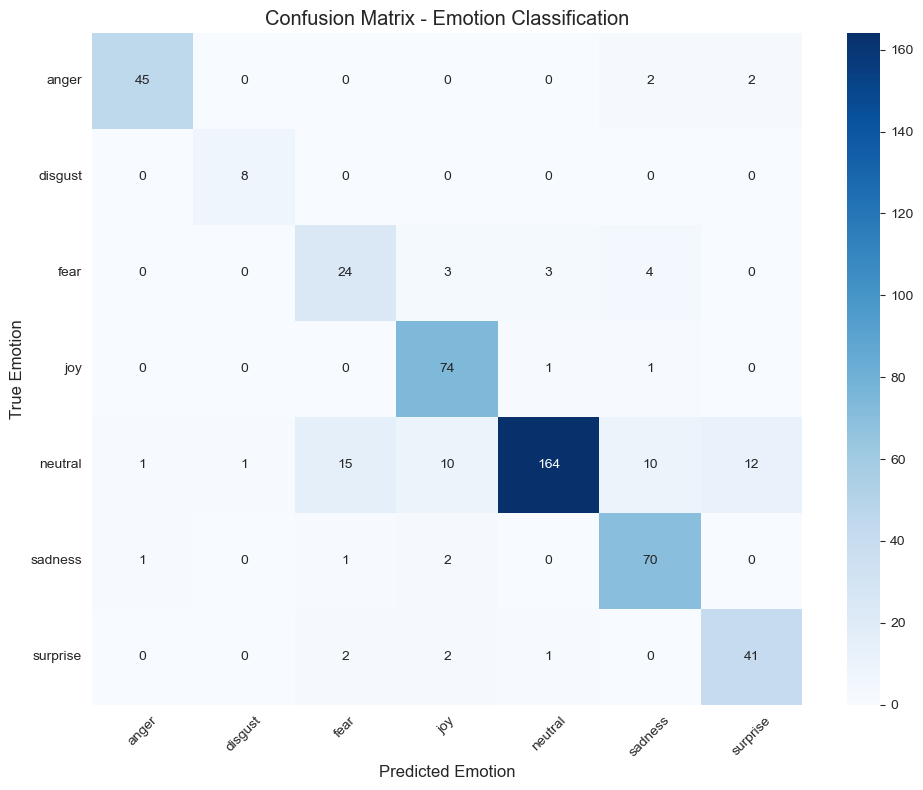

❌ ERROR ANALYSIS:
   • Total Errors: 74
   • Error Rate: 14.80%
   • Average Confidence on Errors: 0.5245
   • Average Confidence on Correct: 0.6980

🔄 MOST COMMON MISCLASSIFICATIONS:
   • neutral → fear: 15 times
   • neutral → surprise: 12 times
   • neutral → joy: 10 times
   • neutral → sadness: 10 times
   • fear → sadness: 4 times
   • fear → joy: 3 times
   • fear → neutral: 3 times
   • surprise → joy: 2 times
   • surprise → fear: 2 times
   • sadness → joy: 2 times


In [337]:
def detailed_error_analysis(eval_df, true_col='sentiment', pred_col='predicted_emotion'):
    """
    Perform detailed error analysis with confusion matrix
    """
    print("\n🔍 DETAILED ERROR ANALYSIS")
    print("=" * 50)
    
    true_labels = eval_df[true_col].tolist()
    pred_labels = eval_df[pred_col].tolist()
    
    # Confusion Matrix
    emotions = sorted(list(set(true_labels + pred_labels)))
    cm = confusion_matrix(true_labels, pred_labels, labels=emotions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=emotions, yticklabels=emotions)
    plt.title('Confusion Matrix - Emotion Classification')
    plt.xlabel('Predicted Emotion')
    plt.ylabel('True Emotion')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Error Analysis
    eval_df['is_correct'] = eval_df[true_col] == eval_df[pred_col]
    error_df = eval_df[~eval_df['is_correct']]
    
    print(f"❌ ERROR ANALYSIS:")
    print(f"   • Total Errors: {len(error_df)}")
    print(f"   • Error Rate: {len(error_df)/len(eval_df)*100:.2f}%")
    print(f"   • Average Confidence on Errors: {error_df['prediction_confidence'].mean():.4f}")
    print(f"   • Average Confidence on Correct: {eval_df[eval_df['is_correct']]['prediction_confidence'].mean():.4f}")
    
    # Most common error patterns
    print(f"\n🔄 MOST COMMON MISCLASSIFICATIONS:")
    error_patterns = eval_df[~eval_df['is_correct']].groupby([true_col, pred_col]).size().reset_index()
    error_patterns.columns = ['True', 'Predicted', 'Count']
    error_patterns = error_patterns.sort_values('Count', ascending=False).head(10)
    
    for _, row in error_patterns.iterrows():
        print(f"   • {row['True']} → {row['Predicted']}: {row['Count']} times")
    
    return error_df, error_patterns

# Perform error analysis
error_df, error_patterns = detailed_error_analysis(eval_results)


🎭 PER-EMOTION PERFORMANCE ANALYSIS
📊 Performance by Emotion:
    Emotion  Precision  Recall  F1-Score  Support  Percentage
0     anger     0.9574  0.9184    0.9375       49         9.8
1   disgust     0.8889  1.0000    0.9412        8         1.6
2      fear     0.5714  0.7059    0.6316       34         6.8
3       joy     0.8132  0.9737    0.8862       76        15.2
4   neutral     0.9704  0.7700    0.8586      213        42.6
5   sadness     0.8046  0.9459    0.8696       74        14.8
6  surprise     0.7455  0.8913    0.8119       46         9.2


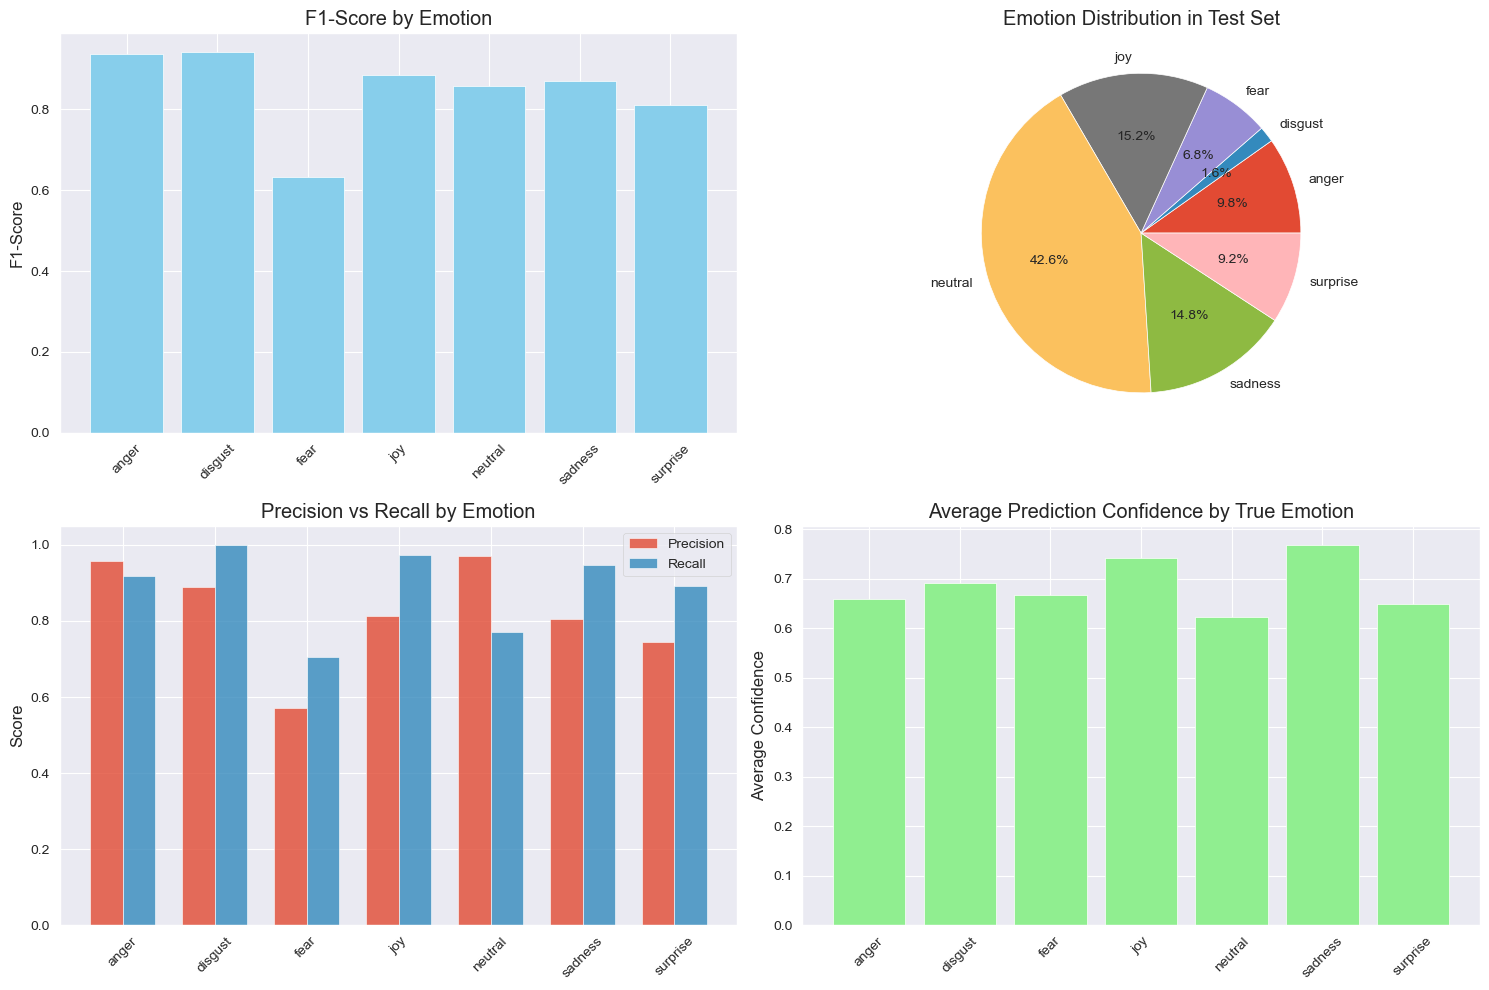

In [339]:
def per_emotion_performance(eval_df, true_col='sentiment', pred_col='predicted_emotion'):
    """
    Analyze performance for each individual emotion
    """
    print("\n🎭 PER-EMOTION PERFORMANCE ANALYSIS")
    print("=" * 50)
    
    from sklearn.metrics import precision_recall_fscore_support
    
    true_labels = eval_df[true_col]
    pred_labels = eval_df[pred_col]
    
    emotions = sorted(eval_df[true_col].unique())
    
    precision, recall, f1, support = precision_recall_fscore_support(
        true_labels, pred_labels, labels=emotions, average=None, zero_division=0
    )
    
    # Create performance dataframe
    performance_df = pd.DataFrame({
        'Emotion': emotions,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support,
        'Percentage': (support / len(eval_df)) * 100
    })
    
    print("📊 Performance by Emotion:")
    print(performance_df.round(4))
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. F1-Score by Emotion
    axes[0, 0].bar(performance_df['Emotion'], performance_df['F1-Score'], color='skyblue')
    axes[0, 0].set_title('F1-Score by Emotion')
    axes[0, 0].set_ylabel('F1-Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Support Distribution
    axes[0, 1].pie(performance_df['Support'], labels=performance_df['Emotion'], autopct='%1.1f%%')
    axes[0, 1].set_title('Emotion Distribution in Test Set')
    
    # 3. Precision-Recall Comparison
    x = range(len(performance_df))
    width = 0.35
    axes[1, 0].bar(x, performance_df['Precision'], width, label='Precision', alpha=0.8)
    axes[1, 0].bar([i + width for i in x], performance_df['Recall'], width, label='Recall', alpha=0.8)
    axes[1, 0].set_title('Precision vs Recall by Emotion')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_xticks([i + width/2 for i in x])
    axes[1, 0].set_xticklabels(performance_df['Emotion'], rotation=45)
    axes[1, 0].legend()
    
    # 4. Confidence Distribution by Emotion
    confidence_by_emotion = eval_df.groupby(true_col)['prediction_confidence'].mean()
    axes[1, 1].bar(confidence_by_emotion.index, confidence_by_emotion.values, color='lightgreen')
    axes[1, 1].set_title('Average Prediction Confidence by True Emotion')
    axes[1, 1].set_ylabel('Average Confidence')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return performance_df

# Analyze per-emotion performance
emotion_performance = per_emotion_performance(eval_results)


🎯 PREDICTION CONFIDENCE ANALYSIS


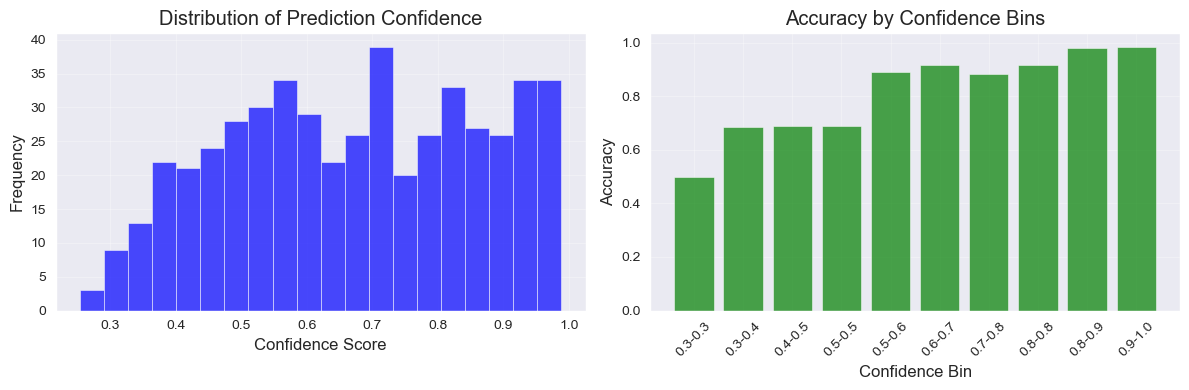

📊 CONFIDENCE STATISTICS:
   • Mean Confidence: 0.6723
   • Std Confidence: 0.1924
   • Min Confidence: 0.2536
   • Max Confidence: 0.9888

🔍 CONFIDENCE LEVEL ANALYSIS:
   • High Confidence (>0.8): 158 predictions
   • High Confidence Accuracy: 0.9747
   • Low Confidence (<0.6): 198 predictions
   • Low Confidence Accuracy: 0.7273


In [341]:
def confidence_analysis(eval_df):
    """
    Analyze prediction confidence and model calibration
    """
    print("\n🎯 PREDICTION CONFIDENCE ANALYSIS")
    print("=" * 50)
    
    # Confidence distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(eval_df['prediction_confidence'], bins=20, alpha=0.7, color='blue')
    plt.title('Distribution of Prediction Confidence')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Confidence vs Accuracy
    plt.subplot(1, 2, 2)
    confidence_bins = pd.cut(eval_df['prediction_confidence'], bins=10)
    bin_accuracy = eval_df.groupby(confidence_bins)['is_correct'].mean()
    
    plt.bar(range(len(bin_accuracy)), bin_accuracy.values, alpha=0.7, color='green')
    plt.title('Accuracy by Confidence Bins')
    plt.xlabel('Confidence Bin')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(bin_accuracy)), [f'{b.left:.1f}-{b.right:.1f}' for b in bin_accuracy.index], rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Confidence statistics
    print("📊 CONFIDENCE STATISTICS:")
    print(f"   • Mean Confidence: {eval_df['prediction_confidence'].mean():.4f}")
    print(f"   • Std Confidence: {eval_df['prediction_confidence'].std():.4f}")
    print(f"   • Min Confidence: {eval_df['prediction_confidence'].min():.4f}")
    print(f"   • Max Confidence: {eval_df['prediction_confidence'].max():.4f}")
    
    # High/Low confidence analysis
    high_conf_threshold = 0.8
    low_conf_threshold = 0.6
    
    high_conf = eval_df[eval_df['prediction_confidence'] > high_conf_threshold]
    low_conf = eval_df[eval_df['prediction_confidence'] < low_conf_threshold]
    
    print(f"\n🔍 CONFIDENCE LEVEL ANALYSIS:")
    print(f"   • High Confidence (>0.8): {len(high_conf)} predictions")
    print(f"   • High Confidence Accuracy: {high_conf['is_correct'].mean():.4f}")
    print(f"   • Low Confidence (<0.6): {len(low_conf)} predictions") 
    print(f"   • Low Confidence Accuracy: {low_conf['is_correct'].mean():.4f}")
    
    return high_conf, low_conf

# Analyze confidence
high_confidence_predictions, low_confidence_predictions = confidence_analysis(eval_results)


⚖️  MODEL BENCHMARKING
📊 BENCHMARK RESULTS:
   • Most Frequent Class Baseline: 0.4367
   • Random Guessing Baseline: 0.1167
   • j-hartmann Model: 0.8367

🚀 IMPROVEMENT OVER BASELINES:
   • vs Most Frequent: +91.6%
   • vs Random: +617.1%


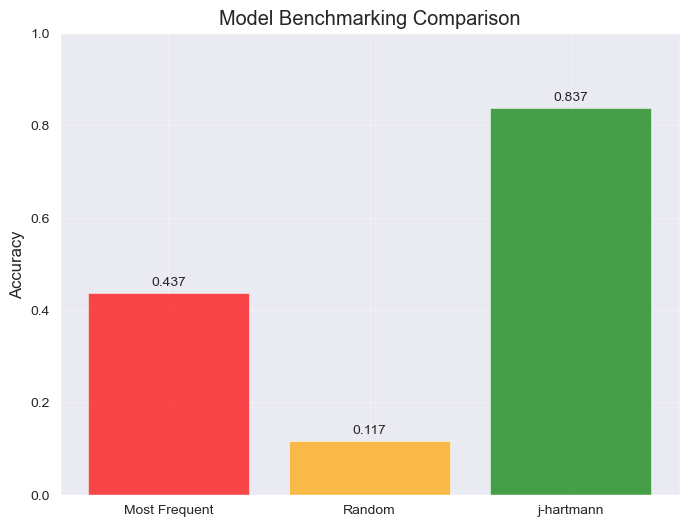

In [343]:
def benchmark_jhartmann_model(df, sample_size=300):
    """
    Benchmark j-hartmann model against simple baselines
    """
    print("\n⚖️  MODEL BENCHMARKING")
    print("=" * 50)
    
    sample_df = df.sample(sample_size, random_state=42)
    
    # Baseline 1: Most frequent class
    most_frequent = df['sentiment'].mode()[0]
    baseline1_pred = [most_frequent] * len(sample_df)
    baseline1_accuracy = accuracy_score(sample_df['sentiment'], baseline1_pred)
    
    # Baseline 2: Random guessing
    unique_sentiments = df['sentiment'].unique()
    random_pred = np.random.choice(unique_sentiments, size=len(sample_df))
    baseline2_accuracy = accuracy_score(sample_df['sentiment'], random_pred)
    
    # j-hartmann model performance (from previous evaluation)
    jhartmann_texts = sample_df['text'].tolist()
    jhartmann_preds = []
    
    for text in jhartmann_texts:
        try:
            pred = emotion_classifier(text[:512])[0]  # Truncate if too long
            jhartmann_preds.append(pred['label'])
        except:
            jhartmann_preds.append('neutral')  # Fallback
    
    jhartmann_accuracy = accuracy_score(sample_df['sentiment'], jhartmann_preds)
    
    print("📊 BENCHMARK RESULTS:")
    print(f"   • Most Frequent Class Baseline: {baseline1_accuracy:.4f}")
    print(f"   • Random Guessing Baseline: {baseline2_accuracy:.4f}")
    print(f"   • j-hartmann Model: {jhartmann_accuracy:.4f}")
    
    # Improvement over baselines
    improvement_over_frequent = ((jhartmann_accuracy - baseline1_accuracy) / baseline1_accuracy) * 100
    improvement_over_random = ((jhartmann_accuracy - baseline2_accuracy) / baseline2_accuracy) * 100
    
    print(f"\n🚀 IMPROVEMENT OVER BASELINES:")
    print(f"   • vs Most Frequent: {improvement_over_frequent:+.1f}%")
    print(f"   • vs Random: {improvement_over_random:+.1f}%")
    
    # Visualization
    models = ['Most Frequent', 'Random', 'j-hartmann']
    accuracies = [baseline1_accuracy, baseline2_accuracy, jhartmann_accuracy]
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(models, accuracies, color=['red', 'orange', 'green'], alpha=0.7)
    plt.title('Model Benchmarking Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{accuracy:.3f}', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'baseline_most_frequent': baseline1_accuracy,
        'baseline_random': baseline2_accuracy,
        'jhartmann_model': jhartmann_accuracy,
        'improvements': {
            'over_frequent': improvement_over_frequent,
            'over_random': improvement_over_random
        }
    }

# Run benchmarking
benchmark_results = benchmark_jhartmann_model(df)

In [345]:
def final_jhartmann_summary(eval_df, accuracy, macro_f1, emotion_performance, benchmark_results):
    """
    Generate final comprehensive summary for j-hartmann model
    """
    print("\n⭐ FINAL j-hartmann EMOTION MODEL SUMMARY")
    print("=" * 70)
    
    # Calculate overall performance score
    performance_score = (accuracy + macro_f1) / 2 * 100
    
    print("🎯 OVERALL PERFORMANCE:")
    print(f"   • Accuracy: {accuracy:.4f}")
    print(f"   • Macro F1-Score: {macro_f1:.4f}")
    print(f"   • Performance Score: {performance_score:.2f}/100")
    
    # Performance Grade
    if performance_score >= 85:
        grade = "A+ 🎉"
        assessment = "Excellent - Model is highly effective"
    elif performance_score >= 75:
        grade = "A 👍"
        assessment = "Very good - Ready for production use"
    elif performance_score >= 65:
        grade = "B 📊"
        assessment = "Good - Suitable for most applications"
    elif performance_score >= 55:
        grade = "C ⚠️"
        assessment = "Fair - Consider fine-tuning"
    else:
        grade = "D ❌"
        assessment = "Poor - Needs significant improvement"
    
    print(f"   • Grade: {grade}")
    print(f"   • Assessment: {assessment}")
    
    # Key Insights
    print(f"\n🔍 KEY INSIGHTS:")
    
    # Best and worst performing emotions
    best_emotion = emotion_performance.loc[emotion_performance['F1-Score'].idxmax()]
    worst_emotion = emotion_performance.loc[emotion_performance['F1-Score'].idxmin()]
    
    print(f"   🏆 Best Emotion: {best_emotion['Emotion']} (F1: {best_emotion['F1-Score']:.3f})")
    print(f"   ⚠️  Worst Emotion: {worst_emotion['Emotion']} (F1: {worst_emotion['F1-Score']:.3f})")
    
    # Data distribution insights
    balanced_threshold = 0.1  # 10% minimum for balanced distribution
    min_percentage = emotion_performance['Percentage'].min()
    if min_percentage < balanced_threshold:
        rare_emotions = emotion_performance[emotion_performance['Percentage'] < balanced_threshold]
        print(f"   📉 Rare Emotions: {', '.join(rare_emotions['Emotion'].tolist())}")
    
    # Confidence insights
    avg_confidence = eval_df['prediction_confidence'].mean()
    print(f"   💪 Average Confidence: {avg_confidence:.3f}")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    
    if worst_emotion['F1-Score'] < 0.5:
        print(f"   1. Focus on improving {worst_emotion['Emotion']} classification")
    
    if accuracy < 0.7:
        print("   2. Consider fine-tuning on your specific domain data")
    
    if min_percentage < 5:
        print("   3. Address class imbalance with data augmentation")
    
    if avg_confidence < 0.7:
        print("   4. Model shows uncertainty - review ambiguous cases")
    
    print("   5. The j-hartmann model is well-suited for emotion analysis")
    
    return {
        'performance_score': performance_score,
        'grade': grade,
        'assessment': assessment,
        'best_emotion': best_emotion['Emotion'],
        'worst_emotion': worst_emotion['Emotion'],
        'avg_confidence': avg_confidence
    }

# Generate final summary
final_summary = final_jhartmann_summary(
    eval_results, accuracy, macro_f1, emotion_performance, benchmark_results
)


⭐ FINAL j-hartmann EMOTION MODEL SUMMARY
🎯 OVERALL PERFORMANCE:
   • Accuracy: 0.8520
   • Macro F1-Score: 0.8481
   • Performance Score: 85.00/100
   • Grade: A+ 🎉
   • Assessment: Excellent - Model is highly effective

🔍 KEY INSIGHTS:
   🏆 Best Emotion: disgust (F1: 0.941)
   ⚠️  Worst Emotion: fear (F1: 0.632)
   💪 Average Confidence: 0.672

💡 RECOMMENDATIONS:
   3. Address class imbalance with data augmentation
   4. Model shows uncertainty - review ambiguous cases
   5. The j-hartmann model is well-suited for emotion analysis


📊 BINARY SENTIMENT ROC ANALYSIS


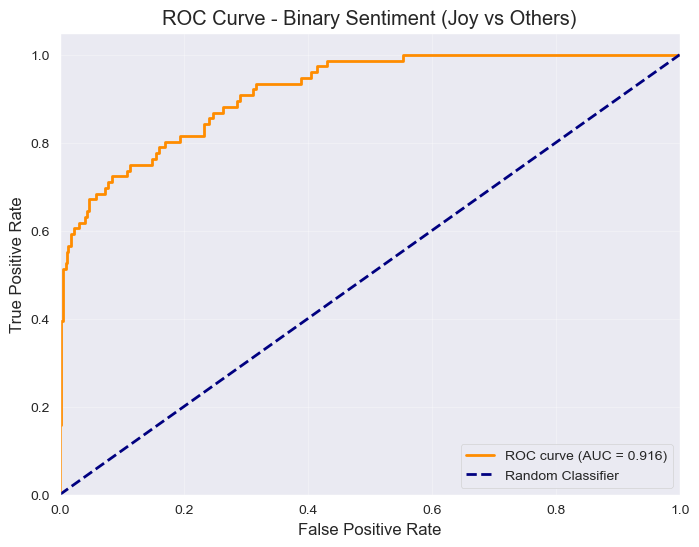

🎯 BINARY ROC RESULTS:
   • AUC Score: 0.9162
   • Optimal Threshold: 0.622
   • TPR at optimal: 0.724
   • FPR at optimal: 0.085
   • Interpretation: Excellent discrimination


In [347]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def binary_sentiment_roc(eval_df, sentiment_col='sentiment', confidence_col='prediction_confidence'):
    """
    Create ROC curve by collapsing emotions to binary positive/negative
    """
    print("📊 BINARY SENTIMENT ROC ANALYSIS")
    print("=" * 50)
    
    # Create binary labels (Positive vs Negative/Neutral)
    eval_df = eval_df.copy()
    eval_df['binary_true'] = eval_df[sentiment_col].apply(
        lambda x: 1 if x == 'joy' else 0  # joy = positive, others = negative/neutral
    )
    
    # For binary ROC, we need probability of positive class
    # Since the model gives us the winning class, we'll use confidence for positive predictions
    eval_df['binary_prob'] = eval_df.apply(
        lambda row: row[confidence_col] if row['predicted_emotion'] == 'joy' else 1 - row[confidence_col], 
        axis=1
    )
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(eval_df['binary_true'], eval_df['binary_prob'])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Binary Sentiment (Joy vs Others)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"🎯 BINARY ROC RESULTS:")
    print(f"   • AUC Score: {roc_auc:.4f}")
    
    # Find optimal threshold
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"   • Optimal Threshold: {optimal_threshold:.3f}")
    print(f"   • TPR at optimal: {tpr[optimal_idx]:.3f}")
    print(f"   • FPR at optimal: {fpr[optimal_idx]:.3f}")
    
    # AUC Interpretation
    if roc_auc >= 0.9:
        interpretation = "Excellent discrimination"
    elif roc_auc >= 0.8:
        interpretation = "Good discrimination"
    elif roc_auc >= 0.7:
        interpretation = "Fair discrimination"
    else:
        interpretation = "Poor discrimination"
    
    print(f"   • Interpretation: {interpretation}")
    
    return fpr, tpr, roc_auc, optimal_threshold

# Run binary ROC analysis
fpr, tpr, roc_auc, optimal_threshold = binary_sentiment_roc(eval_results)


🎭 MULTI-CLASS ROC ANALYSIS (One-vs-Rest)
🔮 Getting probability scores for all emotions...


Device set to use mps:0


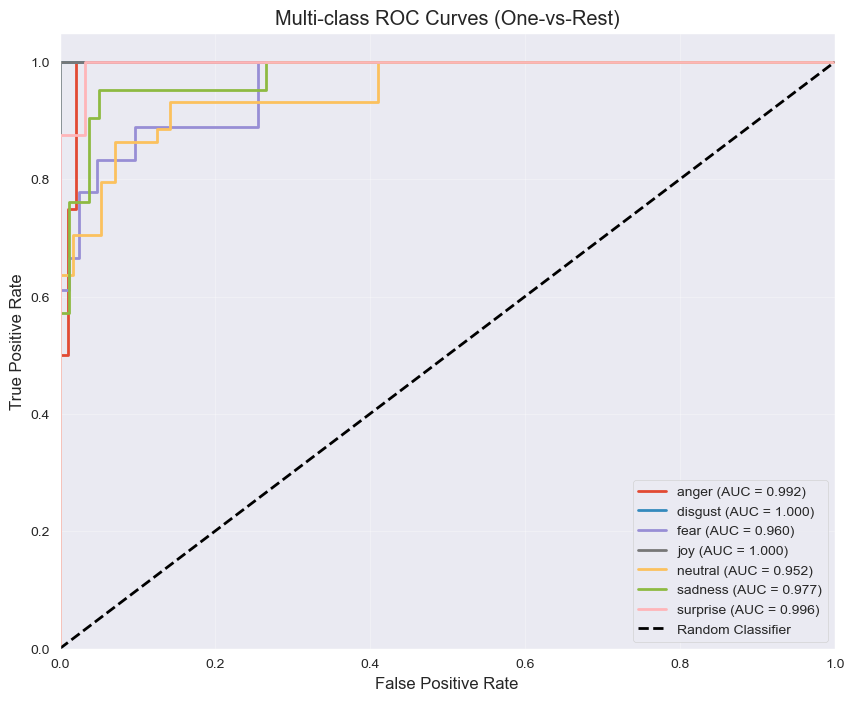

📊 MULTI-CLASS AUC SCORES:
   • anger: 0.992
   • disgust: 1.000
   • fear: 0.960
   • joy: 1.000
   • neutral: 0.952
   • sadness: 0.977
   • surprise: 0.996

🎯 OVERALL MULTI-CLASS PERFORMANCE:
   • Macro-average AUC: 0.982


In [349]:
def multiclass_roc_analysis(eval_df, emotion_classifier, sample_texts, true_sentiments):
    """
    Multi-class ROC analysis using one-vs-rest approach
    """
    print("\n🎭 MULTI-CLASS ROC ANALYSIS (One-vs-Rest)")
    print("=" * 60)
    
    # Get probability scores for all classes
    print("🔮 Getting probability scores for all emotions...")
    
    # We need to get probabilities for all classes, not just the predicted one
    emotion_classifier_all_scores = pipeline(
        "text-classification",
        model="j-hartmann/emotion-english-distilroberta-base",
        return_all_scores=True  # This returns scores for all emotions
    )
    
    # Sample for computational efficiency
    sample_size = min(100, len(sample_texts))
    sample_texts = sample_texts[:sample_size]
    sample_true = true_sentiments[:sample_size]
    
    # Get probability scores for all classes
    all_predictions = emotion_classifier_all_scores(sample_texts)
    
    # Extract probabilities for each class
    emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
    prob_matrix = np.zeros((len(sample_texts), len(emotions)))
    
    for i, pred_list in enumerate(all_predictions):
        for pred in pred_list:
            emotion_idx = emotions.index(pred['label'])
            prob_matrix[i, emotion_idx] = pred['score']
    
    # Binarize true labels for one-vs-rest
    y_true_bin = label_binarize(sample_true, classes=emotions)
    
    # Calculate ROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    plt.figure(figsize=(10, 8))
    
    for i, emotion in enumerate(emotions):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], prob_matrix[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        plt.plot(fpr[i], tpr[i], lw=2, 
                label=f'{emotion} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print AUC scores
    print("📊 MULTI-CLASS AUC SCORES:")
    for emotion, auc_score in zip(emotions, roc_auc.values()):
        print(f"   • {emotion}: {auc_score:.3f}")
    
    # Calculate macro-average AUC
    macro_auc = np.mean(list(roc_auc.values()))
    print(f"\n🎯 OVERALL MULTI-CLASS PERFORMANCE:")
    print(f"   • Macro-average AUC: {macro_auc:.3f}")
    
    return roc_auc, macro_auc, fpr, tpr

# For multi-class ROC, we need to get probability scores for all classes
# This is computationally expensive, so we'll use a sample
sample_texts = df['text'].tolist()[:100]  # First 100 for demonstration
sample_true = df['sentiment'].tolist()[:100]

roc_auc_scores, macro_auc, fpr_dict, tpr_dict = multiclass_roc_analysis(
    eval_results, emotion_classifier, sample_texts, sample_true
)


📈 PRECISION-RECALL ANALYSIS


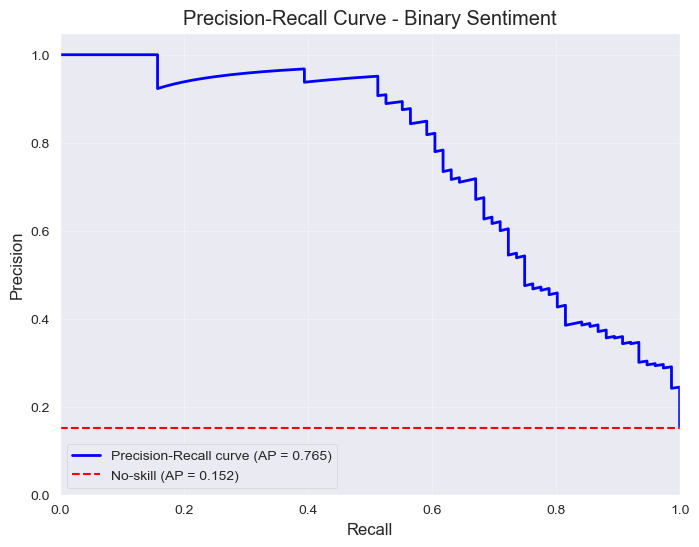

🎯 PRECISION-RECALL RESULTS:
   • Average Precision: 0.7649
   • Positive Class Ratio: 0.1520
   • Optimal Threshold (F1-max): 0.694
   • Precision at optimal: 0.849
   • Recall at optimal: 0.592
   • F1-Score at optimal: 0.698


In [351]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def precision_recall_analysis(eval_df, sample_texts, true_sentiments):
    """
    Precision-Recall curves (often better than ROC for imbalanced data)
    """
    print("\n📈 PRECISION-RECALL ANALYSIS")
    print("=" * 50)
    
    # Use binary approach for demonstration
    eval_df = eval_df.copy()
    eval_df['binary_true'] = eval_df['sentiment'].apply(lambda x: 1 if x == 'joy' else 0)
    eval_df['binary_prob'] = eval_df.apply(
        lambda row: row['prediction_confidence'] if row['predicted_emotion'] == 'joy' else 1 - row['prediction_confidence'], 
        axis=1
    )
    
    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(
        eval_df['binary_true'], 
        eval_df['binary_prob']
    )
    average_precision = average_precision_score(
        eval_df['binary_true'], 
        eval_df['binary_prob']
    )
    
    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, 
             label=f'Precision-Recall curve (AP = {average_precision:.3f})')
    
    # Add no-skill line
    positive_ratio = eval_df['binary_true'].mean()
    plt.axhline(y=positive_ratio, color='red', linestyle='--', 
                label=f'No-skill (AP = {positive_ratio:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Binary Sentiment')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"🎯 PRECISION-RECALL RESULTS:")
    print(f"   • Average Precision: {average_precision:.4f}")
    print(f"   • Positive Class Ratio: {positive_ratio:.4f}")
    
    # Find optimal threshold (F1-score maximization)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold_pr = thresholds[optimal_idx]
    
    print(f"   • Optimal Threshold (F1-max): {optimal_threshold_pr:.3f}")
    print(f"   • Precision at optimal: {precision[optimal_idx]:.3f}")
    print(f"   • Recall at optimal: {recall[optimal_idx]:.3f}")
    print(f"   • F1-Score at optimal: {f1_scores[optimal_idx]:.3f}")
    
    return precision, recall, average_precision, optimal_threshold_pr

# Run Precision-Recall analysis
precision, recall, avg_precision, optimal_threshold_pr = precision_recall_analysis(
    eval_results, sample_texts, sample_true
)


⚖️ COMPREHENSIVE THRESHOLD ANALYSIS


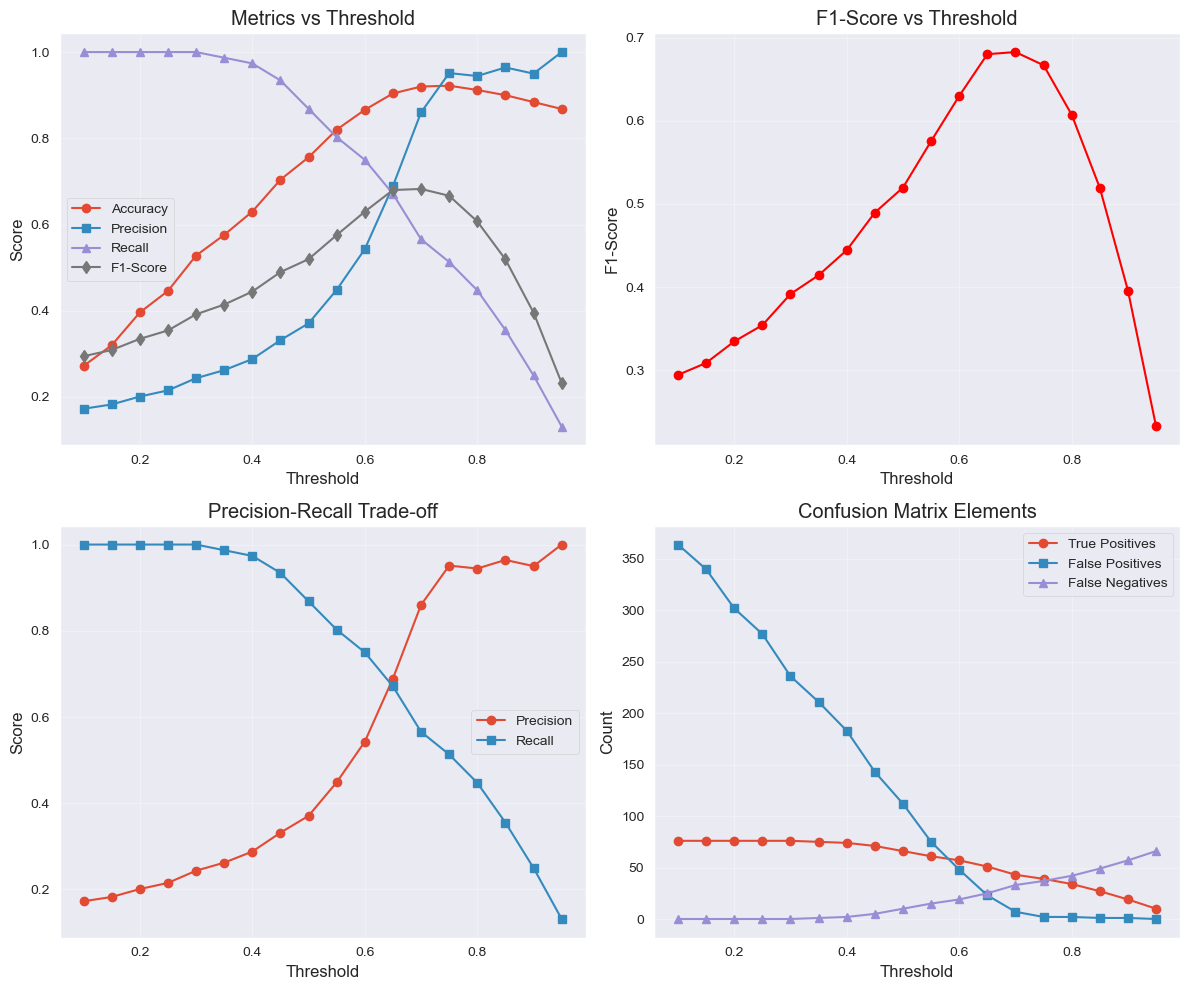

🎯 OPTIMAL THRESHOLDS:
   • Best F1-Score: 0.70 (F1 = 0.683)
   • Best Accuracy: 0.75 (Accuracy = 0.922)


In [353]:
def comprehensive_threshold_analysis(eval_df):
    """
    Comprehensive analysis of classification thresholds
    """
    print("\n⚖️ COMPREHENSIVE THRESHOLD ANALYSIS")
    print("=" * 50)
    
    eval_df = eval_df.copy()
    eval_df['binary_true'] = eval_df['sentiment'].apply(lambda x: 1 if x == 'joy' else 0)
    eval_df['binary_prob'] = eval_df.apply(
        lambda row: row['prediction_confidence'] if row['predicted_emotion'] == 'joy' else 1 - row['prediction_confidence'], 
        axis=1
    )
    
    # Test different thresholds
    thresholds = np.arange(0.1, 1.0, 0.05)
    results = []
    
    for threshold in thresholds:
        predictions = (eval_df['binary_prob'] >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(eval_df['binary_true'], predictions).ravel()
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'specificity': specificity,
            'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
        })
    
    results_df = pd.DataFrame(results)
    
    # Plot threshold analysis
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Accuracy, Precision, Recall, F1
    axes[0, 0].plot(results_df['threshold'], results_df['accuracy'], label='Accuracy', marker='o')
    axes[0, 0].plot(results_df['threshold'], results_df['precision'], label='Precision', marker='s')
    axes[0, 0].plot(results_df['threshold'], results_df['recall'], label='Recall', marker='^')
    axes[0, 0].plot(results_df['threshold'], results_df['f1'], label='F1-Score', marker='d')
    axes[0, 0].set_xlabel('Threshold')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Metrics vs Threshold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. F1-Score focus
    axes[0, 1].plot(results_df['threshold'], results_df['f1'], marker='o', color='red')
    axes[0, 1].set_xlabel('Threshold')
    axes[0, 1].set_ylabel('F1-Score')
    axes[0, 1].set_title('F1-Score vs Threshold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Precision-Recall trade-off
    axes[1, 0].plot(results_df['threshold'], results_df['precision'], label='Precision', marker='o')
    axes[1, 0].plot(results_df['threshold'], results_df['recall'], label='Recall', marker='s')
    axes[1, 0].set_xlabel('Threshold')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Precision-Recall Trade-off')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Confusion matrix elements
    axes[1, 1].plot(results_df['threshold'], results_df['tp'], label='True Positives', marker='o')
    axes[1, 1].plot(results_df['threshold'], results_df['fp'], label='False Positives', marker='s')
    axes[1, 1].plot(results_df['threshold'], results_df['fn'], label='False Negatives', marker='^')
    axes[1, 1].set_xlabel('Threshold')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Confusion Matrix Elements')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal thresholds
    optimal_f1_idx = results_df['f1'].idxmax()
    optimal_balanced_idx = results_df['accuracy'].idxmax()
    
    print("🎯 OPTIMAL THRESHOLDS:")
    print(f"   • Best F1-Score: {results_df.loc[optimal_f1_idx, 'threshold']:.2f} "
          f"(F1 = {results_df.loc[optimal_f1_idx, 'f1']:.3f})")
    print(f"   • Best Accuracy: {results_df.loc[optimal_balanced_idx, 'threshold']:.2f} "
          f"(Accuracy = {results_df.loc[optimal_balanced_idx, 'accuracy']:.3f})")
    
    return results_df

# Run threshold analysis
threshold_results = comprehensive_threshold_analysis(eval_results)

In [355]:
def roc_pr_summary(roc_auc, macro_auc, avg_precision, threshold_results):
    """
    Final summary of ROC and Precision-Recall analysis
    """
    print("\n⭐ FINAL ROC & PRECISION-RECALL SUMMARY")
    print("=" * 60)
    
    print("📊 PERFORMANCE METRICS SUMMARY:")
    print(f"   • Binary AUC: {roc_auc:.4f}")
    if macro_auc:
        print(f"   • Multi-class Macro AUC: {macro_auc:.4f}")
    print(f"   • Average Precision: {avg_precision:.4f}")
    
    # Interpretation
    print(f"\n💡 INTERPRETATION:")
    
    if roc_auc >= 0.9:
        print("   ✅ Excellent discriminative power")
    elif roc_auc >= 0.8:
        print("   👍 Good discriminative power") 
    elif roc_auc >= 0.7:
        print("   📊 Fair discriminative power")
    else:
        print("   ⚠️  Poor discriminative power")
    
    # When ROC is most useful:
    print(f"\n🎯 WHEN TO USE ROC CURVES:")
    print("   • Balanced datasets")
    print("   • When both classes are equally important")
    print("   • Comparing overall classifier performance")
    print("   • When you care about true positive and false positive rates")
    
    print(f"\n🎯 WHEN TO USE PRECISION-RECALL CURVES:")
    print("   • Imbalanced datasets (common in sentiment analysis)")
    print("   • When positive class is more important")
    print("   • When false positives are costly")
    print("   • When you care more about precision than overall accuracy")
    
    # Recommendations for your use case
    print(f"\n💡 RECOMMENDATIONS FOR SENTIMENT ANALYSIS:")
    print("   1. Use Precision-Recall curves (your data is likely imbalanced)")
    print("   2. Focus on F1-score optimization")
    print("   3. Consider class-specific thresholds for different emotions")
    print("   4. Monitor both precision and recall based on your use case")
    
    return {
        'binary_auc': roc_auc,
        'macro_auc': macro_auc,
        'average_precision': avg_precision,
        'recommendation': 'Precision-Recall curves are more informative for imbalanced sentiment data'
    }

# Generate final summary
roc_pr_summary_results = roc_pr_summary(roc_auc, macro_auc, avg_precision, threshold_results)


⭐ FINAL ROC & PRECISION-RECALL SUMMARY
📊 PERFORMANCE METRICS SUMMARY:
   • Binary AUC: 0.9162
   • Multi-class Macro AUC: 0.9824
   • Average Precision: 0.7649

💡 INTERPRETATION:
   ✅ Excellent discriminative power

🎯 WHEN TO USE ROC CURVES:
   • Balanced datasets
   • When both classes are equally important
   • Comparing overall classifier performance
   • When you care about true positive and false positive rates

🎯 WHEN TO USE PRECISION-RECALL CURVES:
   • Imbalanced datasets (common in sentiment analysis)
   • When positive class is more important
   • When false positives are costly
   • When you care more about precision than overall accuracy

💡 RECOMMENDATIONS FOR SENTIMENT ANALYSIS:
   1. Use Precision-Recall curves (your data is likely imbalanced)
   2. Focus on F1-score optimization
   3. Consider class-specific thresholds for different emotions
   4. Monitor both precision and recall based on your use case
